# Last experiments with the CNN GAN

In this notebook, more experiments are done. The model with the best performances is dowloaded and final plots are generated.

In [17]:
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D
import tensorflow.keras
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D,LSTM, BatchNormalization, Conv2DTranspose,Flatten, Input, Reshape, UpSampling2D,ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.datasets import mnist
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam
import math
import nolds

## Data generation, preprocessing and model definition

In [18]:
def generate_data_as_images(N,l=100,T=1, dt = 0.001,n_rows=32,n_cols=32):
    
    #Model parameters
    #dt = 0.001 # integration time step
    sigma = 10
    rho = 28
    beta = 8/3
    #l = int((T-dt)/dt)
    
    #T = dt*(l+1)
    #dt = T/(l+1)
    
    #X = np.zeros((N,3*(l-9)))
    X = []
    time = np.arange(0.01, T, dt)

    for n in range(N):    

        x0 = [np.random.randn(), np.random.randn(), np.random.randn()]

        # generate the Lorenz-63 system
        x = odeint(Lorenz_63, x0, time, args=(sigma, rho, beta))
        
        x_padded = np.zeros((n_rows*n_cols,x.shape[1]))
        x_padded[:x.shape[0],:] = x
        x_padded = x_padded.reshape(n_rows,n_cols,x.shape[1])
        
        #X[n,...] = np.ndarray.flatten(x)
        #X.append(np.ndarray.flatten(x))
        X.append(x_padded)
        #X.append(x.reshape(x.shape[0]*x.shape[1]))
        

    return np.array(X), time

# Lorenz-63 dynamical model
def Lorenz_63(x, dx, sigma, rho, beta):
    dx = np.zeros((3))
    dx[0] = sigma*(x[1]-x[0])
    dx[1] = x[0]*(rho-x[2])-x[1]
    dx[2] = x[0]*x[1] - beta*x[2]
    return dx

In [4]:
N = 100
n_rows = 32
n_cols = 32

X,time = generate_data_as_images(N,T=100, dt=0.1,n_rows=n_rows,n_cols=n_cols)

X.shape

(100, 32, 32, 3)

In [6]:
max_vec = np.max(np.max(abs(X),axis=1),axis=1)

max_matrix = np.expand_dims(np.expand_dims(max_vec,axis=1),axis=2)
max_matrix = np.repeat(np.repeat(max_matrix,n_rows,axis=1),n_cols,axis=2)

X_normalized = np.add(np.divide(X,2*max_matrix),0.5)
X_normalized

array([[[[0.46402836, 0.52343878, 0.49979645],
         [0.48416067, 0.48341515, 0.49976831],
         [0.4586689 , 0.43650771, 0.50168081],
         ...,
         [0.76078067, 0.68867248, 0.79301775],
         [0.74652455, 0.65524586, 0.80135532],
         [0.71422164, 0.63188942, 0.78733426]],

        [[0.69628142, 0.63695958, 0.76682924],
         [0.70595368, 0.66304749, 0.75627771],
         [0.7359361 , 0.6920798 , 0.76534052],
         ...,
         [0.75409566, 0.65323858, 0.80930925],
         [0.70960045, 0.6205174 , 0.79069324],
         [0.68415949, 0.62593289, 0.76328713]],

        [[0.69463247, 0.65845322, 0.74770297],
         [0.73342826, 0.69903541, 0.75701855],
         [0.77104112, 0.70849939, 0.78968195],
         ...,
         [0.71576813, 0.60884278, 0.80323408],
         [0.6701079 , 0.60457839, 0.76601436],
         [0.67025862, 0.63783727, 0.73842083]],

        ...,

        [[0.65888977, 0.70768116, 0.61705395],
         [0.838807  , 0.88810825, 0.72563542]

In [6]:
class gan_CNN(object): 

    def __init__(self):

        self.noise_dim = 300
        self.img_cols = 32
        self.img_rows = 32
        self.channels = 3
        self.optimizer_gan = Adam(0.0001,0.75)#0.5
        self.optimizer_discriminator = Adam(0.0004,0.75)

        
        self.generator = Sequential() 
        self.discriminator = Sequential()
        self.gan = Model()
        
        self.create_generator()
        self.create_discriminator()
        self.create_gan()

    def create_generator(self):
        
        # Starting size
        d = 2
        self.generator.add(Dense(d*d*256, kernel_initializer=RandomNormal(0, 0.02), input_dim=self.noise_dim))
        self.generator.add(LeakyReLU(0.2))
        # 4x4x256
        self.generator.add(Reshape((d, d, 256)))
        
        # 8x8x128
        self.generator.add(Conv2DTranspose(128, (d, d), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
        self.generator.add(BatchNormalization())
        self.generator.add(LeakyReLU(0.2))
        
        # 16x16*128
        self.generator.add(Conv2DTranspose(128, (d, d), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
        self.generator.add(BatchNormalization())
        self.generator.add(LeakyReLU(0.2))
        
        # 32x32x128
        self.generator.add(Conv2DTranspose(128, (d, d), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
        self.generator.add(BatchNormalization())
        self.generator.add(LeakyReLU(0.2))
        
        # 32x32x128
        self.generator.add(Conv2DTranspose(128, (d, d), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
        self.generator.add(BatchNormalization())
        self.generator.add(LeakyReLU(0.2))
        
        # 32x32x3
        self.generator.add(Conv2D(self.channels, (3, 3), padding='same', activation='linear', kernel_initializer=RandomNormal(0, 0.02)))
        # activation should be linear
        
        self.generator.compile(loss='binary_crossentropy', optimizer=self.optimizer_gan)
        # maybe put a batch normalzation layer
      
    def create_discriminator(self):

        self.discriminator.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(self.img_cols, self.img_rows, self.channels)))
        self.discriminator.add(BatchNormalization())
        self.discriminator.add(LeakyReLU(0.2))

        self.discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
        self.discriminator.add(BatchNormalization())
        self.discriminator.add(LeakyReLU(0.2))

        self.discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
        self.discriminator.add(BatchNormalization())
        self.discriminator.add(LeakyReLU(0.2))

        self.discriminator.add(Conv2D(256, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
        self.discriminator.add(BatchNormalization())
        self.discriminator.add(LeakyReLU(0.2))

        self.discriminator.add(Flatten())
        self.discriminator.add(Dropout(0.4))
        self.discriminator.add(Dense(1, activation='sigmoid', input_shape=(self.img_cols, self.img_rows, self.channels)))

        self.discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizer_discriminator)

    def create_gan(self):

        # Make the discriminator untrainable when we are training the generator.  This doesn't effect the discriminator by itself
        self.discriminator.trainable = False

        # Link the two models to create the GAN
        gan_input = Input(shape=(self.noise_dim,))
        print(gan_input.shape)
        fake_image = self.generator(gan_input)

        gan_output = self.discriminator(fake_image)

        self.gan = Model(gan_input, gan_output)
        self.gan.compile(loss='binary_crossentropy', optimizer=self.optimizer_gan)
    
    def gan_summary(self):
        
        self.gan.summary()
        
    def generator_summary(self):
        
        self.generator.summary()

    def discriminator_summary(self):
        
        self.discriminator.summary()
        
    def train(self,X_train, epochs=1, batch_size=128):

        #Loading the data
        batch_count = math.ceil((X_train.shape[0] / batch_size))

        loss_list_generator = []
        loss_list_discriminator = []
        for e in range(1,epochs+1 ):
            print("Epoch %d" %e)
            loss_generator = 0
            loss_discriminator = 0
            idx = np.random.randint(0,X_train.shape[0],X_train.shape[0])
            
            max_noise = 1
            if e < 0.2 * (epochs+1):
                noise_std = max_noise
                p_inversion = 0.2
            elif e < 0.4 * (epochs+1):
                noise_std = max_noise
                p_inversion = 0.2
            elif e < 0.6 * (epochs+1):
                noise_std = max_noise/2
                p_inversion = 0.1
            elif e < 0.8 * (epochs+1):
                noise_std = max_noise/6
                p_inversion = 0.5
            elif e < 0.9 * (epochs+1):
                noise_std = max_noise/10
                p_inversion = 0.01
            else:
                noise_std = 0
                p_inversion = 0
                
            print('Noise std: ', noise_std)

            for _ in tqdm(range(batch_count)):
                
                # Real trajectories
                real_trajectory = X_train[idx[batch_size*_:batch_size*_+batch_size,...]]

                N = np.shape(real_trajectory)[0]#we now use N instead of batch_size, as the last batch
                                                #may be smaller than the batch size
                #real_trajectory = real_trajectory.reshape(N, self.img_rows, self.img_cols, self.channels)
                #generate  random noise as an input  to  initialize the  generator
                
                #noise= np.random.normal(0,1, [N, self.noise_dim])

                generated_trajectory = self.generate(N)
                
                #Construct different batches of  real and fake data 
                X= np.concatenate([real_trajectory, generated_trajectory], axis=0) + noise_std * np.random.randn(2*N,n_rows,n_cols,1)

                # Labels for generated and real data
                y_dis=np.zeros(2*N)
                y_dis[:N]= np.random.uniform(0,0.1,N) + 0.9*np.random.binomial(1,p_inversion,N)
                y_dis[N:2*N]= np.random.uniform(0.9,1,N) - 0.9*np.random.binomial(1,p_inversion,N)
                
                # we try the discriminator in about one third of the total cases
                if e % e == 0:

                    #Pre train discriminator on  fake and real data  before starting the gan. 
                    self.discriminator.trainable=True

                    loss_discriminator = loss_discriminator + self.discriminator.train_on_batch(X, y_dis)

                #Tricking the noised input of the Generator as real data
                noise= np.random.normal(0,1, [N, self.noise_dim])
                y_gen = np.zeros(N)

                # During the training of gan, 
                # the weights of discriminator should be fixed. 
                #We can enforce that by setting the trainable flag
                self.discriminator.trainable=False

                #training  the GAN by alternating the training of the Discriminator 
                #and training the chained GAN model with Discriminator’s weights freezed.
                loss_generator = loss_generator + self.gan.train_on_batch(noise, y_gen)
                
            if e % 3 != 0 and e != 1:
                
                loss_discriminator = loss_list_discriminator[-1]
                
            loss_list_generator.append(loss_generator)
            loss_list_discriminator.append(loss_discriminator)
                                           
            print('Generator loss: ',loss_generator)
            print('Discriminator loss: ',loss_discriminator)
            
            if e == 1 or e % 20 == 0 or e==epochs:

                plt.imshow(X[0,...])
                plt.title('Real image')
                plt.show()
                plt.title('Fake image')
                plt.imshow(X[-1,...])
                plt.show()
                
        return loss_list_generator, loss_list_discriminator

            
    def generate(self,N):

        noise= np.random.normal(0,1, [N, self.noise_dim])

        return self.generator.predict(noise)
    
    def save_weights(self, gen_name, discr_name):
        
        self.generator.save_weights(gen_name)
        self.discriminator.save_weights(discr_name)
        
    def load_weights(self, gen_name, discr_name):
        
        self.generator.load_weights(gen_name)
        self.discriminator.load_weights(discr_name)
      

## Training without normalized images

In [73]:
g_CNN=gan_CNN()
g_CNN.generator_summary()
g_CNN.discriminator_summary()
g_CNN.gan_summary()

(None, 300)
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 1024)              308224    
_________________________________________________________________
leaky_re_lu_81 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
reshape_9 (Reshape)          (None, 2, 2, 256)         0         
_________________________________________________________________
conv2d_transpose_36 (Conv2DT (None, 4, 4, 128)         131200    
_________________________________________________________________
batch_normalization_72 (Batc (None, 4, 4, 128)         512       
_________________________________________________________________
leaky_re_lu_82 (LeakyReLU)   (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose_37 (Conv2DT (None, 8, 8,

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1
Noise std:  1


100%|██████████| 4/4 [00:03<00:00,  1.13it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  2.763986051082611
Discriminator loss:  4.336691200733185


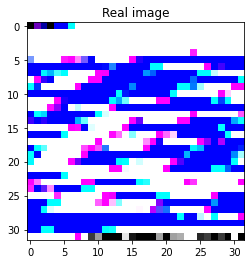

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


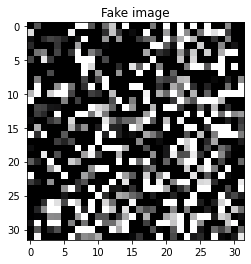

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  2.776630222797394
Discriminator loss:  4.336691200733185
Epoch 3
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  2.7645354866981506
Discriminator loss:  3.044717490673065
Epoch 4
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  2.7644883394241333
Discriminator loss:  3.044717490673065
Epoch 5
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  2.749551296234131
Discriminator loss:  3.044717490673065
Epoch 6
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  2.7600207924842834
Discriminator loss:  2.8692575693130493
Epoch 7
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  2.7235734462738037
Discriminator loss:  2.8692575693130493
Epoch 8
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  2.6726555824279785
Discriminator loss:  2.8692575693130493
Epoch 9
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  2.900492012500763
Discriminator loss:  2.2541225850582123
Epoch 10
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  2.7247763872146606
Discriminator loss:  2.2541225850582123
Epoch 11
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  2.6410937905311584
Discriminator loss:  2.2541225850582123
Epoch 12
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  2.679315686225891
Discriminator loss:  2.194042593240738
Epoch 13
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  2.592124879360199
Discriminator loss:  2.194042593240738
Epoch 14
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  2.5196709632873535
Discriminator loss:  2.194042593240738
Epoch 15
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  2.437507748603821
Discriminator loss:  2.5832764506340027
Epoch 16
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  2.304861545562744
Discriminator loss:  2.5832764506340027
Epoch 17
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  2.402777075767517
Discriminator loss:  2.5832764506340027
Epoch 18
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  2.1549327969551086
Discriminator loss:  2.454574406147003
Epoch 19
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  2.0988845825195312
Discriminator loss:  2.454574406147003
Epoch 20
Noise std:  1


100%|██████████| 4/4 [00:00<00:00,  4.10it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  2.158876419067383
Discriminator loss:  2.454574406147003


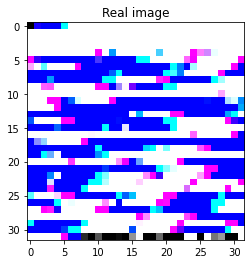

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


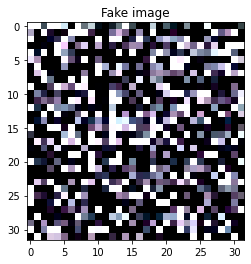

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  2.0349040925502777
Discriminator loss:  2.1593641340732574
Epoch 22
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  2.076802134513855
Discriminator loss:  2.1593641340732574
Epoch 23
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.9574137926101685
Discriminator loss:  2.1593641340732574
Epoch 24
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.842198222875595
Discriminator loss:  2.221968650817871
Epoch 25
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.8620485365390778
Discriminator loss:  2.221968650817871
Epoch 26
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.848854899406433
Discriminator loss:  2.221968650817871
Epoch 27
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.6541761457920074
Discriminator loss:  2.3845774233341217
Epoch 28
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.616724282503128
Discriminator loss:  2.3845774233341217
Epoch 29
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.5666614770889282
Discriminator loss:  2.3845774233341217
Epoch 30
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.4813326001167297
Discriminator loss:  2.262717843055725
Epoch 31
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.4771161377429962
Discriminator loss:  2.262717843055725
Epoch 32
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.429656207561493
Discriminator loss:  2.262717843055725
Epoch 33
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.4572155177593231
Discriminator loss:  2.16986483335495
Epoch 34
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.4113095700740814
Discriminator loss:  2.16986483335495
Epoch 35
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.2424513697624207
Discriminator loss:  2.16986483335495
Epoch 36
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.255255401134491
Discriminator loss:  1.9960366487503052
Epoch 37
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.2913524508476257
Discriminator loss:  1.9960366487503052
Epoch 38
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.185630977153778
Discriminator loss:  1.9960366487503052
Epoch 39
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.133314073085785
Discriminator loss:  2.609573721885681
Epoch 40
Noise std:  1


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  1.097665011882782
Discriminator loss:  2.609573721885681


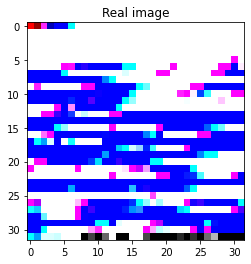

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


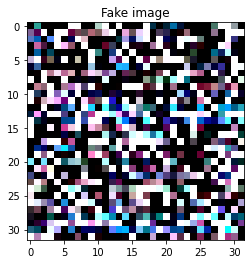

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 41
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.0940503776073456
Discriminator loss:  2.609573721885681
Epoch 42
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.011469528079033
Discriminator loss:  2.506529599428177
Epoch 43
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.019125446677208
Discriminator loss:  2.506529599428177
Epoch 44
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.0699641406536102
Discriminator loss:  2.506529599428177
Epoch 45
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.9724157601594925
Discriminator loss:  2.388350009918213
Epoch 46
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.9122092872858047
Discriminator loss:  2.388350009918213
Epoch 47
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.001796081662178
Discriminator loss:  2.388350009918213
Epoch 48
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.8443939089775085
Discriminator loss:  2.476594567298889
Epoch 49
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.9486376196146011
Discriminator loss:  2.476594567298889
Epoch 50
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.9464885294437408
Discriminator loss:  2.476594567298889
Epoch 51
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.72773377597332
Discriminator loss:  2.322971999645233
Epoch 52
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.7166445106267929
Discriminator loss:  2.322971999645233
Epoch 53
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.6856137812137604
Discriminator loss:  2.322971999645233
Epoch 54
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.580930233001709
Discriminator loss:  2.2012501060962677
Epoch 55
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.6508238613605499
Discriminator loss:  2.2012501060962677
Epoch 56
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.6244861707091331
Discriminator loss:  2.2012501060962677
Epoch 57
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.40805187821388245
Discriminator loss:  2.6014556884765625
Epoch 58
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.46972279250621796
Discriminator loss:  2.6014556884765625
Epoch 59
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.3502906858921051
Discriminator loss:  2.6014556884765625
Epoch 60
Noise std:  1


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.29508358240127563
Discriminator loss:  2.540574073791504


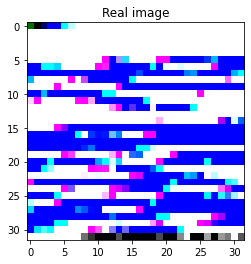

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


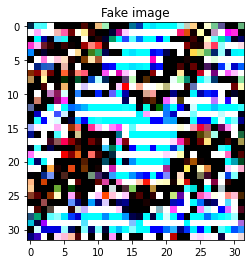

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 61
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.2913013845682144
Discriminator loss:  2.540574073791504
Epoch 62
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.23109329119324684
Discriminator loss:  2.540574073791504
Epoch 63
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.18550387769937515
Discriminator loss:  2.4642675518989563
Epoch 64
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.2407192587852478
Discriminator loss:  2.4642675518989563
Epoch 65
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.15090955048799515
Discriminator loss:  2.4642675518989563
Epoch 66
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.16185475885868073
Discriminator loss:  2.6488293409347534
Epoch 67
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.125596197322011
Discriminator loss:  2.6488293409347534
Epoch 68
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.15952140279114246
Discriminator loss:  2.6488293409347534
Epoch 69
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.13258027285337448
Discriminator loss:  2.562949478626251
Epoch 70
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.1430964209139347
Discriminator loss:  2.562949478626251
Epoch 71
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.12829213961958885
Discriminator loss:  2.562949478626251
Epoch 72
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.14355175755918026
Discriminator loss:  2.436498463153839
Epoch 73
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.09422936290502548
Discriminator loss:  2.436498463153839
Epoch 74
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.0780030358582735
Discriminator loss:  2.436498463153839
Epoch 75
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.1827352773398161
Discriminator loss:  2.465456962585449
Epoch 76
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.14397303573787212
Discriminator loss:  2.465456962585449
Epoch 77
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.09637569449841976
Discriminator loss:  2.465456962585449
Epoch 78
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.08884239569306374
Discriminator loss:  2.3690801858901978
Epoch 79
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.12987794168293476
Discriminator loss:  2.3690801858901978
Epoch 80
Noise std:  1


100%|██████████| 4/4 [00:00<00:00,  4.06it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.12018222734332085
Discriminator loss:  2.3690801858901978


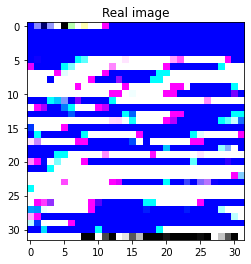

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


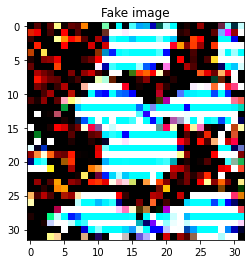

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 81
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.18129556253552437
Discriminator loss:  2.2391137182712555
Epoch 82
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.14164876006543636
Discriminator loss:  2.2391137182712555
Epoch 83
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.13697070069611073
Discriminator loss:  2.2391137182712555
Epoch 84
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.1133784856647253
Discriminator loss:  2.309821516275406
Epoch 85
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.15618169121444225
Discriminator loss:  2.309821516275406
Epoch 86
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.3388282358646393
Discriminator loss:  2.309821516275406
Epoch 87
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.2193109430372715
Discriminator loss:  2.3890408873558044
Epoch 88
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.1393208485096693
Discriminator loss:  2.3890408873558044
Epoch 89
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.1443098485469818
Discriminator loss:  2.3890408873558044
Epoch 90
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.22379427775740623
Discriminator loss:  2.2057767510414124
Epoch 91
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.1805050242692232
Discriminator loss:  2.2057767510414124
Epoch 92
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.24194090068340302
Discriminator loss:  2.2057767510414124
Epoch 93
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.16478902474045753
Discriminator loss:  2.336361676454544
Epoch 94
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.28698985651135445
Discriminator loss:  2.336361676454544
Epoch 95
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.44030097872018814
Discriminator loss:  2.336361676454544
Epoch 96
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.3055884689092636
Discriminator loss:  2.3318448066711426
Epoch 97
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.26844437420368195
Discriminator loss:  2.3318448066711426
Epoch 98
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.5105305463075638
Discriminator loss:  2.3318448066711426
Epoch 99
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.6352095752954483
Discriminator loss:  2.2042471170425415
Epoch 100
Noise std:  1


100%|██████████| 4/4 [00:00<00:00,  4.06it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.6957123205065727
Discriminator loss:  2.2042471170425415


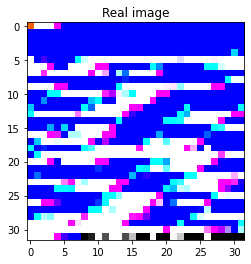

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


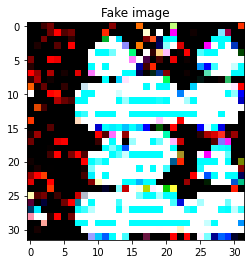

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 101
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.538495272397995
Discriminator loss:  2.2042471170425415
Epoch 102
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.5503910556435585
Discriminator loss:  2.365376353263855
Epoch 103
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.7453742474317551
Discriminator loss:  2.365376353263855
Epoch 104
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.47847675532102585
Discriminator loss:  2.365376353263855
Epoch 105
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.35165881365537643
Discriminator loss:  2.476712942123413
Epoch 106
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.3317187987267971
Discriminator loss:  2.476712942123413
Epoch 107
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.4106165766716003
Discriminator loss:  2.476712942123413
Epoch 108
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.8398745059967041
Discriminator loss:  2.619091808795929
Epoch 109
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.9405757784843445
Discriminator loss:  2.619091808795929
Epoch 110
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.927150696516037
Discriminator loss:  2.619091808795929
Epoch 111
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.6676318049430847
Discriminator loss:  2.7856134176254272
Epoch 112
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.6259292885661125
Discriminator loss:  2.7856134176254272
Epoch 113
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.6876692920923233
Discriminator loss:  2.7856134176254272
Epoch 114
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.7355362325906754
Discriminator loss:  2.171939432621002
Epoch 115
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.5455420985817909
Discriminator loss:  2.171939432621002
Epoch 116
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.7129124104976654
Discriminator loss:  2.171939432621002
Epoch 117
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.4819682165980339
Discriminator loss:  2.847999155521393
Epoch 118
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.8146061301231384
Discriminator loss:  2.847999155521393
Epoch 119
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.4361102469265461
Discriminator loss:  2.847999155521393
Epoch 120
Noise std:  1


100%|██████████| 4/4 [00:00<00:00,  4.01it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.5598015934228897
Discriminator loss:  2.477937638759613


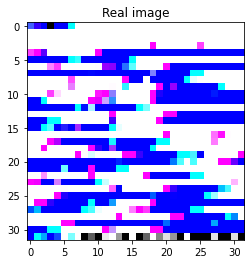

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


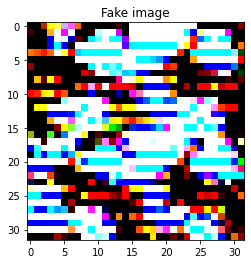

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 121
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.5329835787415504
Discriminator loss:  2.477937638759613
Epoch 122
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.45380062609910965
Discriminator loss:  2.477937638759613
Epoch 123
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.38635824620723724
Discriminator loss:  2.3812034726142883
Epoch 124
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.29327207803726196
Discriminator loss:  2.3812034726142883
Epoch 125
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.5501969531178474
Discriminator loss:  2.3812034726142883
Epoch 126
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.2996381036937237
Discriminator loss:  2.3073622584342957
Epoch 127
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.20157646015286446
Discriminator loss:  2.3073622584342957
Epoch 128
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.29865632951259613
Discriminator loss:  2.3073622584342957
Epoch 129
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.3234303817152977
Discriminator loss:  2.506905674934387
Epoch 130
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.39133070409297943
Discriminator loss:  2.506905674934387
Epoch 131
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.39203978329896927
Discriminator loss:  2.506905674934387
Epoch 132
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.16633381508290768
Discriminator loss:  2.6190765500068665
Epoch 133
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.306836549192667
Discriminator loss:  2.6190765500068665
Epoch 134
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.43449103087186813
Discriminator loss:  2.6190765500068665
Epoch 135
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.30789342522621155
Discriminator loss:  2.3451071977615356
Epoch 136
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.2842121981084347
Discriminator loss:  2.3451071977615356
Epoch 137
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.2906827926635742
Discriminator loss:  2.3451071977615356
Epoch 138
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.09410064946860075
Discriminator loss:  2.6388237476348877
Epoch 139
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.32839439809322357
Discriminator loss:  2.6388237476348877
Epoch 140
Noise std:  1


100%|██████████| 4/4 [00:00<00:00,  4.01it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.2530439496040344
Discriminator loss:  2.6388237476348877


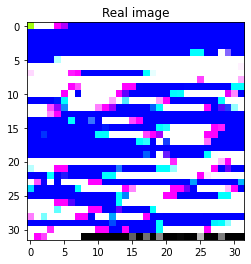

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


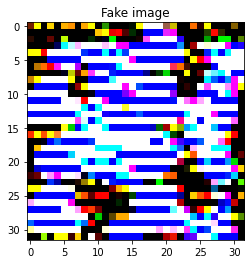

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 141
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.19411717541515827
Discriminator loss:  2.1808739602565765
Epoch 142
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.38223062083125114
Discriminator loss:  2.1808739602565765
Epoch 143
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.21743229404091835
Discriminator loss:  2.1808739602565765
Epoch 144
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.2960714213550091
Discriminator loss:  2.5603343844413757
Epoch 145
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.3496822863817215
Discriminator loss:  2.5603343844413757
Epoch 146
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.309857539832592
Discriminator loss:  2.5603343844413757
Epoch 147
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.4583970010280609
Discriminator loss:  2.3175057768821716
Epoch 148
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.8205761462450027
Discriminator loss:  2.3175057768821716
Epoch 149
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.9942274689674377
Discriminator loss:  2.3175057768821716
Epoch 150
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.383915014564991
Discriminator loss:  2.225695937871933
Epoch 151
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.6105113998055458
Discriminator loss:  2.225695937871933
Epoch 152
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.6466817632317543
Discriminator loss:  2.225695937871933
Epoch 153
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.5723090395331383
Discriminator loss:  2.2658320665359497
Epoch 154
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.8768991976976395
Discriminator loss:  2.2658320665359497
Epoch 155
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.3432687073945999
Discriminator loss:  2.2658320665359497
Epoch 156
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.3728424087166786
Discriminator loss:  2.2649856507778168
Epoch 157
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.3696278929710388
Discriminator loss:  2.2649856507778168
Epoch 158
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.2989874333143234
Discriminator loss:  2.2649856507778168
Epoch 159
Noise std:  1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.20921046286821365
Discriminator loss:  2.190012127161026
Epoch 160
Noise std:  1


100%|██████████| 4/4 [00:01<00:00,  3.97it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.23340826854109764
Discriminator loss:  2.190012127161026


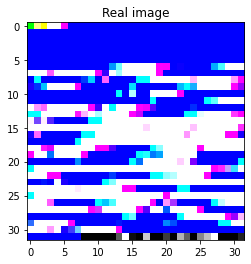

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


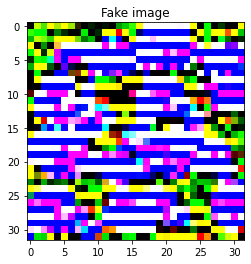

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 161
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.13308070600032806
Discriminator loss:  2.190012127161026
Epoch 162
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.14704884216189384
Discriminator loss:  1.9735987186431885
Epoch 163
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.21904975920915604
Discriminator loss:  1.9735987186431885
Epoch 164
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.141008410602808
Discriminator loss:  1.9735987186431885
Epoch 165
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.24097895994782448
Discriminator loss:  1.842959612607956
Epoch 166
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.17808499932289124
Discriminator loss:  1.842959612607956
Epoch 167
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.09656273573637009
Discriminator loss:  1.842959612607956
Epoch 168
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.13345573283731937
Discriminator loss:  1.879257082939148
Epoch 169
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.14144250936806202
Discriminator loss:  1.879257082939148
Epoch 170
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.154524689540267
Discriminator loss:  1.879257082939148
Epoch 171
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.2064334787428379
Discriminator loss:  1.8068772852420807
Epoch 172
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.3569888323545456
Discriminator loss:  1.8068772852420807
Epoch 173
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.29596517235040665
Discriminator loss:  1.8068772852420807
Epoch 174
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.43176794797182083
Discriminator loss:  1.6012399196624756
Epoch 175
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.3830011337995529
Discriminator loss:  1.6012399196624756
Epoch 176
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.48026613891124725
Discriminator loss:  1.6012399196624756
Epoch 177
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.4315367639064789
Discriminator loss:  1.6616035550832748
Epoch 178
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.3538041338324547
Discriminator loss:  1.6616035550832748
Epoch 179
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.461060605943203
Discriminator loss:  1.6616035550832748
Epoch 180
Noise std:  0.5


100%|██████████| 4/4 [00:00<00:00,  4.04it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.41239746659994125
Discriminator loss:  1.55978262424469


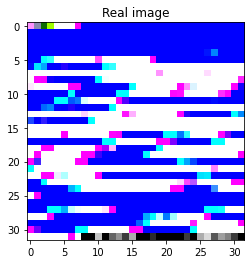

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


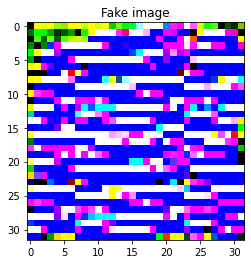

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 181
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.45211320370435715
Discriminator loss:  1.55978262424469
Epoch 182
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.630293071269989
Discriminator loss:  1.55978262424469
Epoch 183
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.4942491725087166
Discriminator loss:  1.8104892671108246
Epoch 184
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.863241769373417
Discriminator loss:  1.8104892671108246
Epoch 185
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  3.4072946906089783
Discriminator loss:  1.8104892671108246
Epoch 186
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  2.0757551193237305
Discriminator loss:  1.9686564207077026
Epoch 187
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.3295457661151886
Discriminator loss:  1.9686564207077026
Epoch 188
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.8737003803253174
Discriminator loss:  1.9686564207077026
Epoch 189
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.6605753749608994
Discriminator loss:  1.8630395829677582
Epoch 190
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.49657298624515533
Discriminator loss:  1.8630395829677582
Epoch 191
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.4568866491317749
Discriminator loss:  1.8630395829677582
Epoch 192
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.35895267128944397
Discriminator loss:  2.192322015762329
Epoch 193
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.49819283932447433
Discriminator loss:  2.192322015762329
Epoch 194
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.5311296284198761
Discriminator loss:  2.192322015762329
Epoch 195
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.3399304524064064
Discriminator loss:  1.7720827460289001
Epoch 196
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.2881484627723694
Discriminator loss:  1.7720827460289001
Epoch 197
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.22633520513772964
Discriminator loss:  1.7720827460289001
Epoch 198
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.39211130142211914
Discriminator loss:  1.86495441198349
Epoch 199
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.5795992761850357
Discriminator loss:  1.86495441198349
Epoch 200
Noise std:  0.5


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.6561727374792099
Discriminator loss:  1.86495441198349


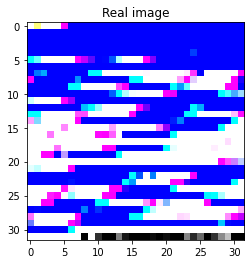

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


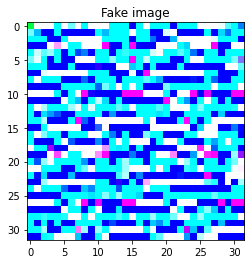

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 201
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  8.499714374542236
Discriminator loss:  2.110497325658798
Epoch 202
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  19.85166358947754
Discriminator loss:  2.110497325658798
Epoch 203
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  24.642719268798828
Discriminator loss:  2.110497325658798
Epoch 204
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  28.585652351379395
Discriminator loss:  1.581860214471817
Epoch 205
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  21.14551067352295
Discriminator loss:  1.581860214471817
Epoch 206
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  20.17124366760254
Discriminator loss:  1.581860214471817
Epoch 207
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  36.10341739654541
Discriminator loss:  1.7017878592014313
Epoch 208
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  27.623790740966797
Discriminator loss:  1.7017878592014313
Epoch 209
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  34.72576379776001
Discriminator loss:  1.7017878592014313
Epoch 210
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  30.992854595184326
Discriminator loss:  1.8040401935577393
Epoch 211
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  34.98537826538086
Discriminator loss:  1.8040401935577393
Epoch 212
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  26.3129563331604
Discriminator loss:  1.8040401935577393
Epoch 213
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  27.667410373687744
Discriminator loss:  1.6531872749328613
Epoch 214
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  15.171131134033203
Discriminator loss:  1.6531872749328613
Epoch 215
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  8.965744853019714
Discriminator loss:  1.6531872749328613
Epoch 216
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.6318554133176804
Discriminator loss:  1.4209369868040085
Epoch 217
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.4759773686528206
Discriminator loss:  1.4209369868040085
Epoch 218
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.4967423751950264
Discriminator loss:  1.4209369868040085
Epoch 219
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.29564687982201576
Discriminator loss:  1.7342214584350586
Epoch 220
Noise std:  0.5


100%|██████████| 4/4 [00:01<00:00,  3.97it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.2754783630371094
Discriminator loss:  1.7342214584350586


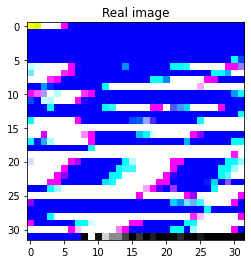

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


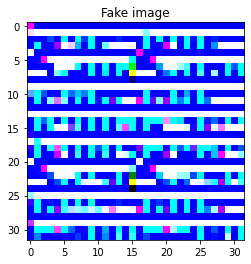

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 221
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.3096010722219944
Discriminator loss:  1.7342214584350586
Epoch 222
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.28435079008340836
Discriminator loss:  1.504804104566574
Epoch 223
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.3828633949160576
Discriminator loss:  1.504804104566574
Epoch 224
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.3440912291407585
Discriminator loss:  1.504804104566574
Epoch 225
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.26550471410155296
Discriminator loss:  1.898759663105011
Epoch 226
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.1755154635757208
Discriminator loss:  1.898759663105011
Epoch 227
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.12224140483886003
Discriminator loss:  1.898759663105011
Epoch 228
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.1852873768657446
Discriminator loss:  1.6745743453502655
Epoch 229
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.20958198979496956
Discriminator loss:  1.6745743453502655
Epoch 230
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.19508609920740128
Discriminator loss:  1.6745743453502655
Epoch 231
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.2053392194211483
Discriminator loss:  1.7953120172023773
Epoch 232
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.2835451625287533
Discriminator loss:  1.7953120172023773
Epoch 233
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.40019137784838676
Discriminator loss:  1.7953120172023773
Epoch 234
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.3120880089700222
Discriminator loss:  1.8530468940734863
Epoch 235
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.06917201913893223
Discriminator loss:  1.8530468940734863
Epoch 236
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.09963634330779314
Discriminator loss:  1.8530468940734863
Epoch 237
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.35649965703487396
Discriminator loss:  1.720563292503357
Epoch 238
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.31072917208075523
Discriminator loss:  1.720563292503357
Epoch 239
Noise std:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.2056913897395134
Discriminator loss:  1.720563292503357
Epoch 240
Noise std:  0.5


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.21832601353526115
Discriminator loss:  1.7616312205791473


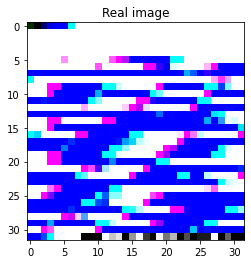

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


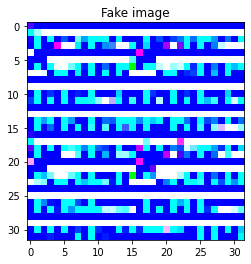

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 241
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  2.9766480922698975
Discriminator loss:  1.7616312205791473
Epoch 242
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.460138812661171
Discriminator loss:  1.7616312205791473
Epoch 243
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.9313738346099854
Discriminator loss:  3.2544923424720764
Epoch 244
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.02568618953228
Discriminator loss:  3.2544923424720764
Epoch 245
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.956397607922554
Discriminator loss:  3.2544923424720764
Epoch 246
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.2902565598487854
Discriminator loss:  2.9342634677886963
Epoch 247
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.8813218176364899
Discriminator loss:  2.9342634677886963
Epoch 248
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.9912933558225632
Discriminator loss:  2.9342634677886963
Epoch 249
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.7976837754249573
Discriminator loss:  2.8933804631233215
Epoch 250
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.8060173541307449
Discriminator loss:  2.8933804631233215
Epoch 251
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.0962539464235306
Discriminator loss:  2.8933804631233215
Epoch 252
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.1854190826416016
Discriminator loss:  3.1199321150779724
Epoch 253
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.7804068326950073
Discriminator loss:  3.1199321150779724
Epoch 254
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.9112565666437149
Discriminator loss:  3.1199321150779724
Epoch 255
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.6312941610813141
Discriminator loss:  2.9025962948799133
Epoch 256
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.5563797056674957
Discriminator loss:  2.9025962948799133
Epoch 257
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.8658352494239807
Discriminator loss:  2.9025962948799133
Epoch 258
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.5895445048809052
Discriminator loss:  3.072701930999756
Epoch 259
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.8180781006813049
Discriminator loss:  3.072701930999756
Epoch 260
Noise std:  0.16666666666666666


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.7770981192588806
Discriminator loss:  3.072701930999756


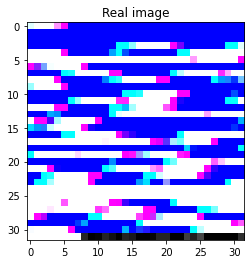

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


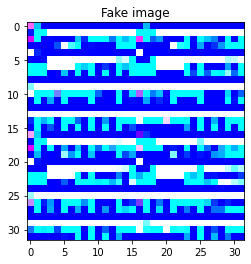

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 261
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.5992768555879593
Discriminator loss:  2.9192121028900146
Epoch 262
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.49893754720687866
Discriminator loss:  2.9192121028900146
Epoch 263
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.3936450555920601
Discriminator loss:  2.9192121028900146
Epoch 264
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.45703157037496567
Discriminator loss:  2.830630660057068
Epoch 265
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.45066674798727036
Discriminator loss:  2.830630660057068
Epoch 266
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.32475244998931885
Discriminator loss:  2.830630660057068
Epoch 267
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.36968813836574554
Discriminator loss:  2.978955030441284
Epoch 268
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.43082381039857864
Discriminator loss:  2.978955030441284
Epoch 269
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.6422278881072998
Discriminator loss:  2.978955030441284
Epoch 270
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.9108652174472809
Discriminator loss:  2.8984017372131348
Epoch 271
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.8384671807289124
Discriminator loss:  2.8984017372131348
Epoch 272
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.8267789334058762
Discriminator loss:  2.8984017372131348
Epoch 273
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.8226048797369003
Discriminator loss:  2.9068291187286377
Epoch 274
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.570579044520855
Discriminator loss:  2.9068291187286377
Epoch 275
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.5703107789158821
Discriminator loss:  2.9068291187286377
Epoch 276
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.6619704812765121
Discriminator loss:  3.025548040866852
Epoch 277
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.9235248416662216
Discriminator loss:  3.025548040866852
Epoch 278
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.4132946729660034
Discriminator loss:  3.025548040866852
Epoch 279
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.469104528427124
Discriminator loss:  2.874606132507324
Epoch 280
Noise std:  0.16666666666666666


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  1.2000225186347961
Discriminator loss:  2.874606132507324


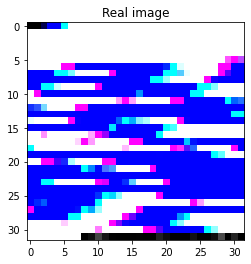

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


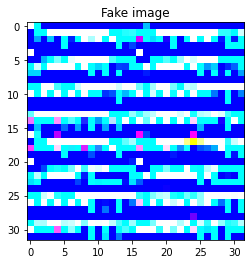

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 281
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.5063378810882568
Discriminator loss:  2.874606132507324
Epoch 282
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.6458635926246643
Discriminator loss:  2.993663966655731
Epoch 283
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.75449937582016
Discriminator loss:  2.993663966655731
Epoch 284
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  2.3286991715431213
Discriminator loss:  2.993663966655731
Epoch 285
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  2.259919285774231
Discriminator loss:  3.015226364135742
Epoch 286
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.6375629603862762
Discriminator loss:  3.015226364135742
Epoch 287
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.5696746408939362
Discriminator loss:  3.015226364135742
Epoch 288
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.7613047361373901
Discriminator loss:  2.9566909074783325
Epoch 289
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.5398650169372559
Discriminator loss:  2.9566909074783325
Epoch 290
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.335292935371399
Discriminator loss:  2.9566909074783325
Epoch 291
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.523528277873993
Discriminator loss:  2.8723976016044617
Epoch 292
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.289219707250595
Discriminator loss:  2.8723976016044617
Epoch 293
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.227106362581253
Discriminator loss:  2.8723976016044617
Epoch 294
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.5930845737457275
Discriminator loss:  2.917253613471985
Epoch 295
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.5597801208496094
Discriminator loss:  2.917253613471985
Epoch 296
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  2.3042134046554565
Discriminator loss:  2.917253613471985
Epoch 297
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.7545309662818909
Discriminator loss:  2.982653856277466
Epoch 298
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.9899607598781586
Discriminator loss:  2.982653856277466
Epoch 299
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.9009783864021301
Discriminator loss:  2.982653856277466
Epoch 300
Noise std:  0.16666666666666666


100%|██████████| 4/4 [00:01<00:00,  4.00it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  2.1463242769241333
Discriminator loss:  3.122865319252014


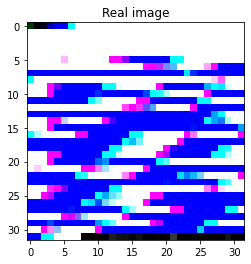

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


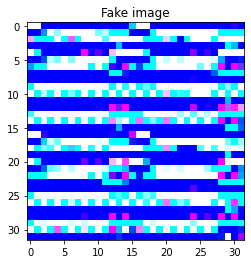

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 301
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.8852664232254028
Discriminator loss:  3.122865319252014
Epoch 302
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.7927604615688324
Discriminator loss:  3.122865319252014
Epoch 303
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  2.0349096059799194
Discriminator loss:  2.899088144302368
Epoch 304
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.107568435370922
Discriminator loss:  2.899088144302368
Epoch 305
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.4603748545050621
Discriminator loss:  2.899088144302368
Epoch 306
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.7775911837816238
Discriminator loss:  3.0095237493515015
Epoch 307
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.5027614831924438
Discriminator loss:  3.0095237493515015
Epoch 308
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.8549601137638092
Discriminator loss:  3.0095237493515015
Epoch 309
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  2.6831035166978836
Discriminator loss:  2.8068281412124634
Epoch 310
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.8274754732847214
Discriminator loss:  2.8068281412124634
Epoch 311
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  6.606446921825409
Discriminator loss:  2.8068281412124634
Epoch 312
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  6.450664043426514
Discriminator loss:  3.0004149675369263
Epoch 313
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  3.961458384990692
Discriminator loss:  3.0004149675369263
Epoch 314
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  5.244214311242104
Discriminator loss:  3.0004149675369263
Epoch 315
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  12.242377042770386
Discriminator loss:  3.102772831916809
Epoch 316
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  5.321803867816925
Discriminator loss:  3.102772831916809
Epoch 317
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  8.332728564739227
Discriminator loss:  3.102772831916809
Epoch 318
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.7580550014972687
Discriminator loss:  3.056180417537689
Epoch 319
Noise std:  0.16666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  2.2146495282649994
Discriminator loss:  3.056180417537689
Epoch 320
Noise std:  0.16666666666666666


100%|██████████| 4/4 [00:00<00:00,  4.01it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  6.010871529579163
Discriminator loss:  3.056180417537689


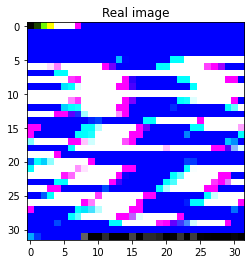

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


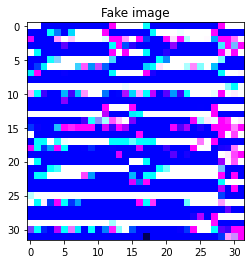

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 321
Noise std:  0.1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  32.18466758728027
Discriminator loss:  1.4805064797401428
Epoch 322
Noise std:  0.1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  40.37299346923828
Discriminator loss:  1.4805064797401428
Epoch 323
Noise std:  0.1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  35.098198890686035
Discriminator loss:  1.4805064797401428
Epoch 324
Noise std:  0.1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  40.252400398254395
Discriminator loss:  0.9229778796434402
Epoch 325
Noise std:  0.1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  41.23183631896973
Discriminator loss:  0.9229778796434402
Epoch 326
Noise std:  0.1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  42.12781810760498
Discriminator loss:  0.9229778796434402
Epoch 327
Noise std:  0.1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  38.25248336791992
Discriminator loss:  0.9870098829269409
Epoch 328
Noise std:  0.1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  35.435301780700684
Discriminator loss:  0.9870098829269409
Epoch 329
Noise std:  0.1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  28.345376014709473
Discriminator loss:  0.9870098829269409
Epoch 330
Noise std:  0.1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  22.720151901245117
Discriminator loss:  0.9221341162919998
Epoch 331
Noise std:  0.1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  19.613390922546387
Discriminator loss:  0.9221341162919998
Epoch 332
Noise std:  0.1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  13.931003093719482
Discriminator loss:  0.9221341162919998
Epoch 333
Noise std:  0.1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  7.669928431510925
Discriminator loss:  0.8353967517614365
Epoch 334
Noise std:  0.1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  4.002529740333557
Discriminator loss:  0.8353967517614365
Epoch 335
Noise std:  0.1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.494729470461607
Discriminator loss:  0.8353967517614365
Epoch 336
Noise std:  0.1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.2314738593995571
Discriminator loss:  1.0969874858856201
Epoch 337
Noise std:  0.1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.22547757998108864
Discriminator loss:  1.0969874858856201
Epoch 338
Noise std:  0.1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.46398086100816727
Discriminator loss:  1.0969874858856201
Epoch 339
Noise std:  0.1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.4685545340180397
Discriminator loss:  0.9240439385175705
Epoch 340
Noise std:  0.1


100%|██████████| 4/4 [00:00<00:00,  4.01it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.5340170040726662
Discriminator loss:  0.9240439385175705


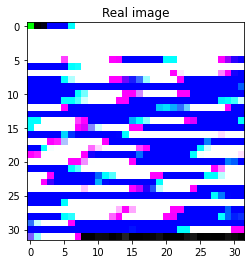

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


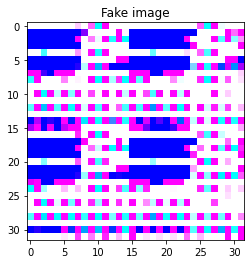

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 341
Noise std:  0.1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.6840250045061111
Discriminator loss:  0.9240439385175705
Epoch 342
Noise std:  0.1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.44426505267620087
Discriminator loss:  1.0070626139640808
Epoch 343
Noise std:  0.1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.614377535879612
Discriminator loss:  1.0070626139640808
Epoch 344
Noise std:  0.1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.26998182386159897
Discriminator loss:  1.0070626139640808
Epoch 345
Noise std:  0.1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.1475543975830078
Discriminator loss:  0.9635204970836639
Epoch 346
Noise std:  0.1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.1428969949483871
Discriminator loss:  0.9635204970836639
Epoch 347
Noise std:  0.1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.6030693203210831
Discriminator loss:  0.9635204970836639
Epoch 348
Noise std:  0.1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.5658165067434311
Discriminator loss:  0.8919935673475266
Epoch 349
Noise std:  0.1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.1940327025949955
Discriminator loss:  0.8919935673475266
Epoch 350
Noise std:  0.1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.18566443398594856
Discriminator loss:  0.8919935673475266
Epoch 351
Noise std:  0.1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.12903772667050362
Discriminator loss:  0.8330026865005493
Epoch 352
Noise std:  0.1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.09848546423017979
Discriminator loss:  0.8330026865005493
Epoch 353
Noise std:  0.1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.10064174793660641
Discriminator loss:  0.8330026865005493
Epoch 354
Noise std:  0.1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.10391769930720329
Discriminator loss:  0.8417629897594452
Epoch 355
Noise std:  0.1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.12128387950360775
Discriminator loss:  0.8417629897594452
Epoch 356
Noise std:  0.1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.12770399451255798
Discriminator loss:  0.8417629897594452
Epoch 357
Noise std:  0.1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.18931981176137924
Discriminator loss:  0.878864198923111
Epoch 358
Noise std:  0.1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.17529496178030968
Discriminator loss:  0.878864198923111
Epoch 359
Noise std:  0.1


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.1190836951136589
Discriminator loss:  0.878864198923111
Epoch 360
Noise std:  0.1


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.07250099722296
Discriminator loss:  1.0919589698314667


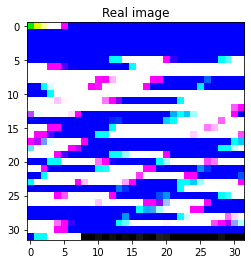

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


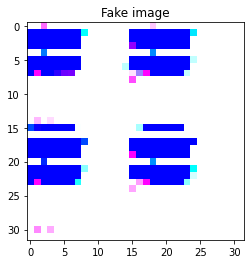

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 361
Noise std:  0


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.05058026593178511
Discriminator loss:  1.0919589698314667
Epoch 362
Noise std:  0


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.09474509954452515
Discriminator loss:  1.0919589698314667
Epoch 363
Noise std:  0


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.12385102920234203
Discriminator loss:  0.8245888501405716
Epoch 364
Noise std:  0


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.12311895936727524
Discriminator loss:  0.8245888501405716
Epoch 365
Noise std:  0


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.10302193649113178
Discriminator loss:  0.8245888501405716
Epoch 366
Noise std:  0


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.10823190212249756
Discriminator loss:  0.805718868970871
Epoch 367
Noise std:  0


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.11910681799054146
Discriminator loss:  0.805718868970871
Epoch 368
Noise std:  0


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.09047645889222622
Discriminator loss:  0.805718868970871
Epoch 369
Noise std:  0


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.08108169212937355
Discriminator loss:  0.7999831289052963
Epoch 370
Noise std:  0


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.0707742590457201
Discriminator loss:  0.7999831289052963
Epoch 371
Noise std:  0


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.10603891499340534
Discriminator loss:  0.7999831289052963
Epoch 372
Noise std:  0


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.06713010743260384
Discriminator loss:  0.8069405108690262
Epoch 373
Noise std:  0


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.05535516794770956
Discriminator loss:  0.8069405108690262
Epoch 374
Noise std:  0


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.08178248256444931
Discriminator loss:  0.8069405108690262
Epoch 375
Noise std:  0


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.16126114688813686
Discriminator loss:  0.8435893654823303
Epoch 376
Noise std:  0


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.1395635437220335
Discriminator loss:  0.8435893654823303
Epoch 377
Noise std:  0


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.06204351224005222
Discriminator loss:  0.8435893654823303
Epoch 378
Noise std:  0


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.06870919466018677
Discriminator loss:  0.8600722402334213
Epoch 379
Noise std:  0


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.08561851177364588
Discriminator loss:  0.8600722402334213
Epoch 380
Noise std:  0


100%|██████████| 4/4 [00:01<00:00,  3.93it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.07361899688839912
Discriminator loss:  0.8600722402334213


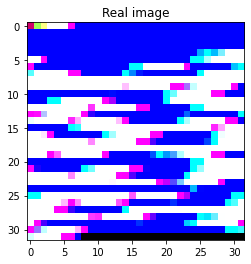

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


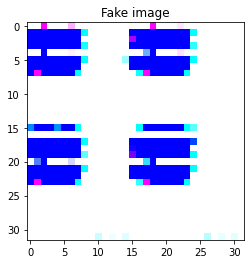

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 381
Noise std:  0


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.06741282995790243
Discriminator loss:  0.8769373744726181
Epoch 382
Noise std:  0


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.11993281170725822
Discriminator loss:  0.8769373744726181
Epoch 383
Noise std:  0


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.2206706590950489
Discriminator loss:  0.8769373744726181
Epoch 384
Noise std:  0


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.2568436563014984
Discriminator loss:  0.8190949261188507
Epoch 385
Noise std:  0


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.19350094348192215
Discriminator loss:  0.8190949261188507
Epoch 386
Noise std:  0


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.16179784014821053
Discriminator loss:  0.8190949261188507
Epoch 387
Noise std:  0


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.1920289546251297
Discriminator loss:  0.8059575855731964
Epoch 388
Noise std:  0


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.2338966317474842
Discriminator loss:  0.8059575855731964
Epoch 389
Noise std:  0


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.33993930369615555
Discriminator loss:  0.8059575855731964
Epoch 390
Noise std:  0


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.6128281801939011
Discriminator loss:  0.792132779955864
Epoch 391
Noise std:  0


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.5425960943102837
Discriminator loss:  0.792132779955864
Epoch 392
Noise std:  0


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.44497573375701904
Discriminator loss:  0.792132779955864
Epoch 393
Noise std:  0


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.9757946580648422
Discriminator loss:  0.8709551393985748
Epoch 394
Noise std:  0


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  0.8750536441802979
Discriminator loss:  0.8709551393985748
Epoch 395
Noise std:  0


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  3.338364899158478
Discriminator loss:  0.8709551393985748
Epoch 396
Noise std:  0


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  7.817963719367981
Discriminator loss:  0.8036394119262695
Epoch 397
Noise std:  0


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  9.386082291603088
Discriminator loss:  0.8036394119262695
Epoch 398
Noise std:  0


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  2.080406069755554
Discriminator loss:  0.8036394119262695
Epoch 399
Noise std:  0


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  1.9859433472156525
Discriminator loss:  0.7863323390483856
Epoch 400
Noise std:  0


100%|██████████| 4/4 [00:00<00:00,  4.10it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  2.3091755509376526
Discriminator loss:  0.7863323390483856


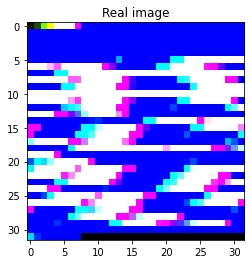

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


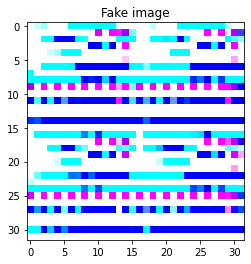

In [74]:
loss_generator,loss_discriminator = g_CNN.train(X,400,30)

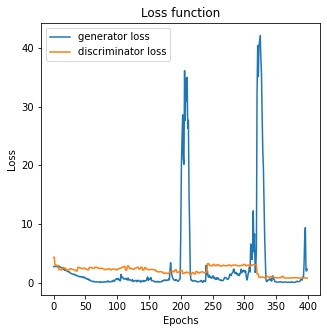

In [77]:
plt.figure(figsize=(5,5))
plt.plot(loss_generator)
plt.plot(loss_discriminator)
plt.title('Loss function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['generator loss','discriminator loss'])
#plt.ylim([0,])
plt.show()

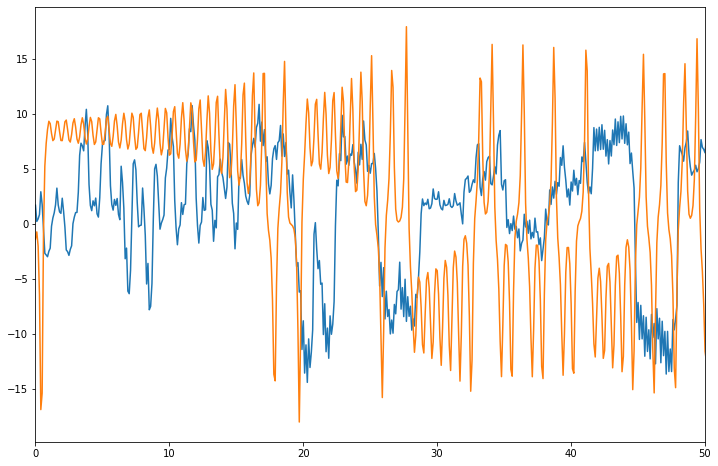

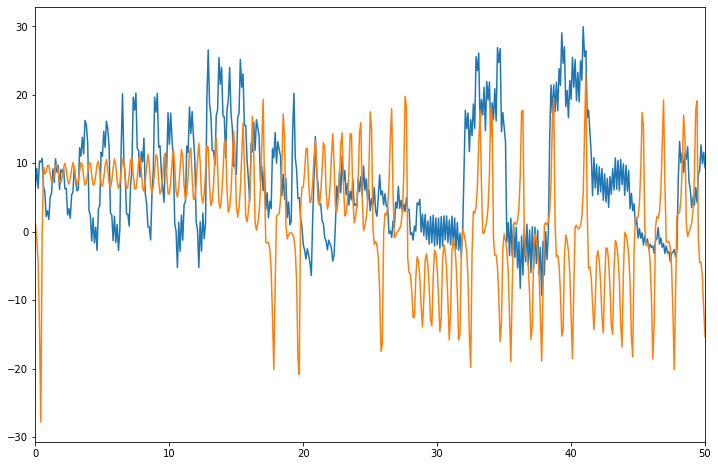

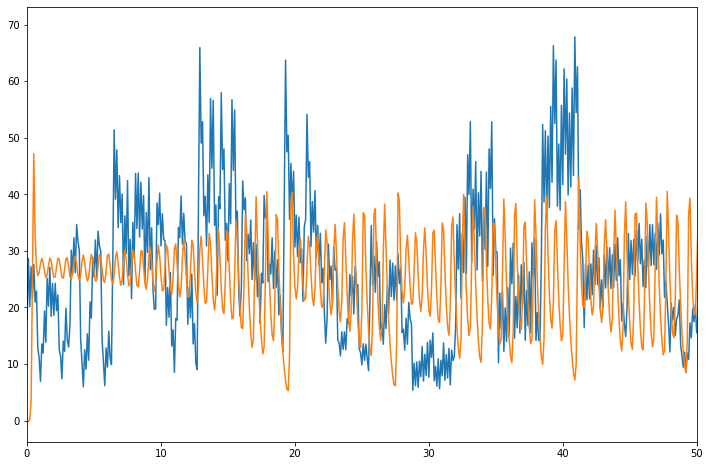

In [78]:
real_series_length = 1000
x = X[0,...].reshape(X.shape[1]*X.shape[2],X.shape[3])[:real_series_length]
#max_matrix = np.repeat(np.max(abs(x_train),axis=0).reshape(1,3),1000,axis=0)
#x_train = np.divide(x_train,max_matrix)

generated_data = g_CNN.generate(1)
generated_data = generated_data[0,...].reshape(generated_data.shape[1]*generated_data.shape[2],generated_data.shape[3])[:real_series_length]

plt.figure(figsize=(12,8))
plt.plot(time,generated_data[:,0])
plt.plot(time,x[:,0])
plt.xlim([0,50])
plt.show()

plt.figure(figsize=(12,8))
plt.plot(time,generated_data[:,1])
plt.plot(time,x[:,1])
plt.xlim([0,50])
plt.show()

plt.figure(figsize=(12,8))
plt.plot(time,generated_data[:,2])
plt.plot(time,x[:,2])
plt.xlim([0,50])
plt.show()

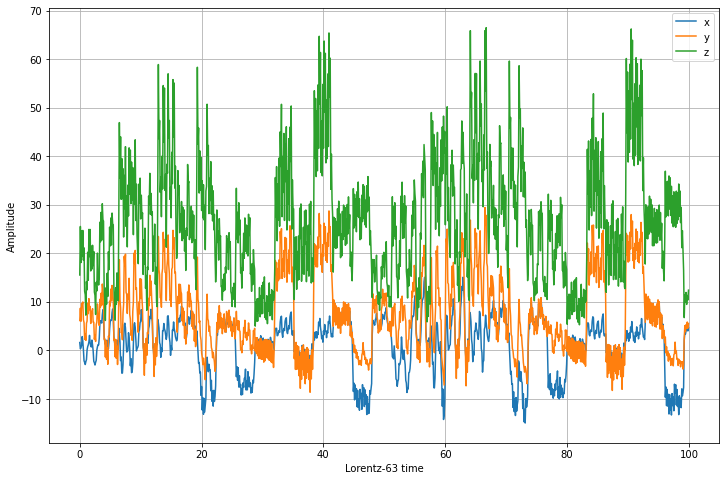

In [81]:
generated_data = g_CNN.generate(1)
generated_data = generated_data[0,...].reshape(generated_data.shape[1]*generated_data.shape[2],generated_data.shape[3])[:real_series_length]

plt.figure(figsize=(12,8))
plt.plot(time,generated_data[:,0])
plt.plot(time,generated_data[:,1])
plt.plot(time,generated_data[:,2])
#plt.xlim([0,30])
plt.legend(['x','y','z'])
plt.grid()
plt.xlabel('Lorentz-63 time')
plt.ylabel('Amplitude')
plt.savefig('images/3coords_plotV2.png')
#plt.show()

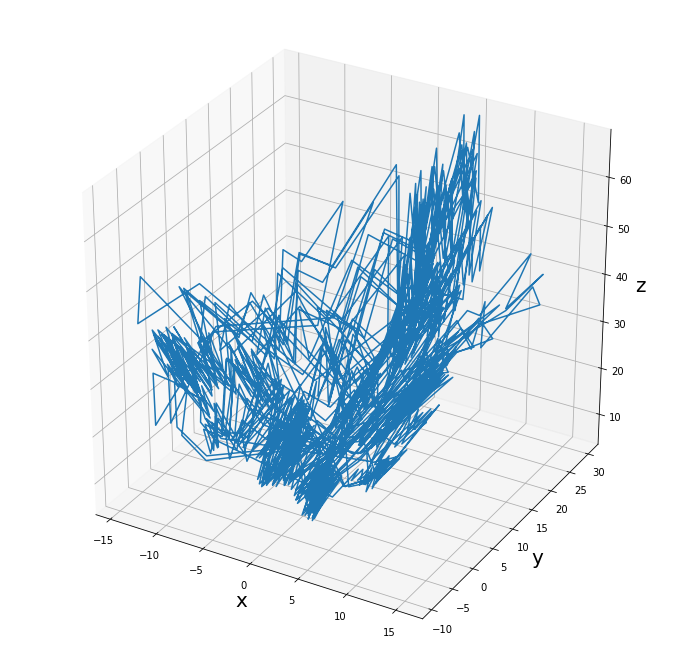

In [80]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')
ax.plot(generated_data[:,0], generated_data[:,1], generated_data[:,2])
ax.set_xlabel('x', size=20);ax.set_ylabel('y', size=20);ax.set_zlabel('z', size=20)
plt.show()

In [68]:
for i in range(3):
    
    lyap_generated = nolds.lyap_e(generated_data[:,i])
    print('Coordinate %d' %i)
    print('Lyapunov exponentes - Eckmann algorithm: ', lyap_generated)
    print('Maximum Lyapunov exponent - Rosenstein algorithm: ',nolds.lyap_r(generated_data[:,0]))

Coordinate 0
Lyapunov exponentes - Eckmann algorithm:  [ 0.19015397  0.0500503  -0.06732158 -0.23259555]
Maximum Lyapunov exponent - Rosenstein algorithm:  0.005201969834474429


/opt/conda/envs/fastai/lib/python3.7/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 250
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


Coordinate 1
Lyapunov exponentes - Eckmann algorithm:  [ 0.20317297  0.0642262  -0.04638387 -0.245595  ]
Maximum Lyapunov exponent - Rosenstein algorithm:  0.0029673931579436187


/opt/conda/envs/fastai/lib/python3.7/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 250
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


Coordinate 2
Lyapunov exponentes - Eckmann algorithm:  [ 0.13416685  0.04357773 -0.04456893 -0.2251882 ]
Maximum Lyapunov exponent - Rosenstein algorithm:  0.005201969834474429


/opt/conda/envs/fastai/lib/python3.7/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 250
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


In [36]:
for i in range(3):
    
    lyap_generated = nolds.lyap_e(generated_data[:,i])
    print('Coordinate %d' %i)
    print('Lyapunov exponentes - Eckmann algorithm: ', lyap_generated)
    print('Maximum Lyapunov exponent - Rosenstein algorithm: ',nolds.lyap_r(generated_data[:,0]))

Coordinate 0
Lyapunov exponentes - Eckmann algorithm:  [ 0.1759726   0.04211573 -0.06913569 -0.24139987]
Maximum Lyapunov exponent - Rosenstein algorithm:  0.029390854204929408


/opt/conda/envs/fastai/lib/python3.7/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 250
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


Coordinate 1
Lyapunov exponentes - Eckmann algorithm:  [ 0.14991775  0.02935022 -0.06954802 -0.22999561]
Maximum Lyapunov exponent - Rosenstein algorithm:  0.027250345529639952


/opt/conda/envs/fastai/lib/python3.7/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 250
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


Coordinate 2
Lyapunov exponentes - Eckmann algorithm:  [ 0.19276758  0.03783829 -0.06187315 -0.2354091 ]
Maximum Lyapunov exponent - Rosenstein algorithm:  0.027250345529639952


/opt/conda/envs/fastai/lib/python3.7/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 250
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


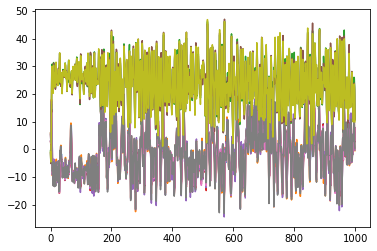

In [78]:
generated_data = g_CNN.generate(3)
for i in range(3):
    x = generated_data[i,...].reshape(generated_data.shape[1]*generated_data.shape[2],generated_data.shape[3])[:real_series_length]
    plt.plot(x)
plt.show()

In [20]:
g_CNN.save_weights('gen3channels1000epochs.h5','discr3channels1000epochs.h5')

In [82]:
gLoaded = gan_CNN()
gLoaded.load_weighst('gen3channels.h5','discr3channels.h5')

(None, 300)


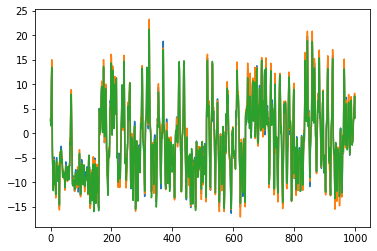

In [90]:
generated_data = gLoaded.generate(3)
for i in range(3):
    x = generated_data[i,...].reshape(generated_data.shape[1]*generated_data.shape[2],generated_data.shape[3])[:real_series_length]
    plt.plot(x[:,0])
plt.show()

## Training using normalized images

The only difference in this part is that we normalize the training images in order for its values to be between 0 and 1.

In [22]:
g_CNN_norm=gan_CNN()
g_CNN_norm.generator_summary()
g_CNN_norm.discriminator_summary()
g_CNN_norm.gan_summary()

(None, 300)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1024)              308224    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 256)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 4, 4, 128)         131200    
_________________________________________________________________
batch_normalization_8 (Batch (None, 4, 4, 128)         512       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 8, 8, 

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1
Noise std:  1


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  3.465907633304596
Discriminator loss:  2.394397407770157


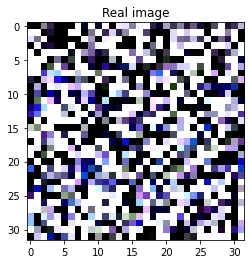

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


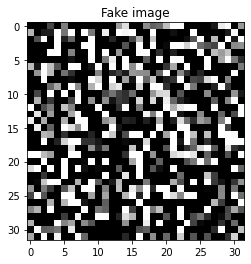

 20%|██        | 1/5 [00:00<00:00,  5.17it/s]

Epoch 2
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  3.4143884778022766
Discriminator loss:  2.394397407770157
Epoch 3
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  3.3155385851860046
Discriminator loss:  1.9643516838550568
Epoch 4
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  3.1760321855545044
Discriminator loss:  1.9643516838550568
Epoch 5
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.11it/s]

Generator loss:  2.966993570327759
Discriminator loss:  1.9643516838550568
Epoch 6
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.19it/s]

Generator loss:  2.713751792907715
Discriminator loss:  1.968585878610611
Epoch 7
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.28it/s]

Generator loss:  2.399647355079651
Discriminator loss:  1.968585878610611
Epoch 8
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.24it/s]

Generator loss:  2.193625032901764
Discriminator loss:  1.968585878610611
Epoch 9
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.18it/s]

Generator loss:  1.9267667531967163
Discriminator loss:  1.9212135076522827
Epoch 10
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.6118519008159637
Discriminator loss:  1.9212135076522827
Epoch 11
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.05it/s]

Generator loss:  1.274432435631752
Discriminator loss:  1.9212135076522827
Epoch 12
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.9258841872215271
Discriminator loss:  1.9058553874492645
Epoch 13
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.7258803844451904
Discriminator loss:  1.9058553874492645
Epoch 14
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.27it/s]

Generator loss:  0.5040856599807739
Discriminator loss:  1.9058553874492645
Epoch 15
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.24it/s]

Generator loss:  0.3896947391331196
Discriminator loss:  1.8414475321769714
Epoch 16
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.17it/s]

Generator loss:  0.21687042713165283
Discriminator loss:  1.8414475321769714
Epoch 17
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.33it/s]

Generator loss:  0.17288260161876678
Discriminator loss:  1.8414475321769714
Epoch 18
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.25it/s]

Generator loss:  0.17343039624392986
Discriminator loss:  1.8286797404289246
Epoch 19
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.30it/s]

Generator loss:  0.1342394072562456
Discriminator loss:  1.8286797404289246
Epoch 20
Noise std:  1


100%|██████████| 5/5 [00:00<00:00,  5.10it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.10205984115600586
Discriminator loss:  1.8286797404289246


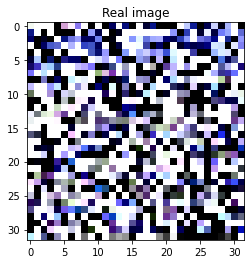

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


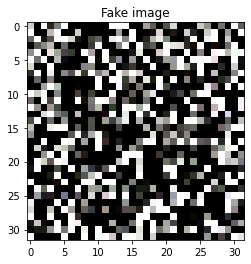

 20%|██        | 1/5 [00:00<00:00,  5.12it/s]

Epoch 21
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.10282805748283863
Discriminator loss:  1.783121794462204
Epoch 22
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.048227735329419374
Discriminator loss:  1.783121794462204
Epoch 23
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.20it/s]

Generator loss:  0.10920094698667526
Discriminator loss:  1.783121794462204
Epoch 24
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.20it/s]

Generator loss:  0.05017977161332965
Discriminator loss:  1.7994775474071503
Epoch 25
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.031219858676195145
Discriminator loss:  1.7994775474071503
Epoch 26
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.26it/s]

Generator loss:  0.016179463593289256
Discriminator loss:  1.7994775474071503
Epoch 27
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.03572687623091042
Discriminator loss:  1.803860753774643
Epoch 28
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.04894646373577416
Discriminator loss:  1.803860753774643
Epoch 29
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.01815877261105925
Discriminator loss:  1.803860753774643
Epoch 30
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.013392896798904985
Discriminator loss:  1.7874986231327057
Epoch 31
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.45it/s]

Generator loss:  0.03925001178868115
Discriminator loss:  1.7874986231327057
Epoch 32
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.029346112452913076
Discriminator loss:  1.7874986231327057
Epoch 33
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.00956615520408377
Discriminator loss:  1.7745544016361237
Epoch 34
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.18it/s]

Generator loss:  0.06340190186165273
Discriminator loss:  1.7745544016361237
Epoch 35
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.012320916634052992
Discriminator loss:  1.7745544016361237
Epoch 36
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.39it/s]

Generator loss:  0.009195336839184165
Discriminator loss:  1.7237590551376343
Epoch 37
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.21it/s]

Generator loss:  0.03809009090764448
Discriminator loss:  1.7237590551376343
Epoch 38
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.21it/s]

Generator loss:  0.008149839006364346
Discriminator loss:  1.7237590551376343
Epoch 39
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.38it/s]

Generator loss:  0.021132831723662093
Discriminator loss:  1.7502243220806122
Epoch 40
Noise std:  1


100%|██████████| 5/5 [00:00<00:00,  5.12it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.03806992631871253
Discriminator loss:  1.7502243220806122


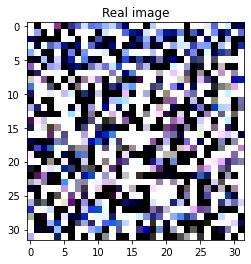

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


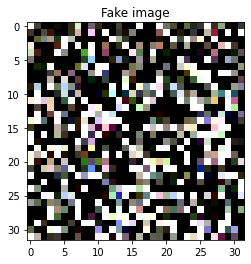

 20%|██        | 1/5 [00:00<00:00,  5.07it/s]

Epoch 41
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.005682329370756634
Discriminator loss:  1.7502243220806122
Epoch 42
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.21it/s]

Generator loss:  0.008684568398166448
Discriminator loss:  1.7506561577320099
Epoch 43
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.004281198780518025
Discriminator loss:  1.7506561577320099
Epoch 44
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.16it/s]

Generator loss:  0.018427698290906847
Discriminator loss:  1.7506561577320099
Epoch 45
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.12it/s]

Generator loss:  0.017037946498021483
Discriminator loss:  1.7452707290649414
Epoch 46
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.019324159948155284
Discriminator loss:  1.7452707290649414
Epoch 47
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.06it/s]

Generator loss:  0.025412227725610137
Discriminator loss:  1.7452707290649414
Epoch 48
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.02it/s]

Generator loss:  0.007485628535505384
Discriminator loss:  1.724730908870697
Epoch 49
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.22it/s]

Generator loss:  0.02820504456758499
Discriminator loss:  1.724730908870697
Epoch 50
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.06310365920944605
Discriminator loss:  1.724730908870697
Epoch 51
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.013354046932363417
Discriminator loss:  1.7676008343696594
Epoch 52
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.018416116246953607
Discriminator loss:  1.7676008343696594
Epoch 53
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.22it/s]

Generator loss:  0.015188913443125784
Discriminator loss:  1.7676008343696594
Epoch 54
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.13it/s]

Generator loss:  0.029367842013016343
Discriminator loss:  1.7278681099414825
Epoch 55
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.16it/s]

Generator loss:  0.053689856780692935
Discriminator loss:  1.7278681099414825
Epoch 56
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.22it/s]

Generator loss:  0.5262071993201971
Discriminator loss:  1.7278681099414825
Epoch 57
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.2194793971721083
Discriminator loss:  1.7568440735340118
Epoch 58
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.21262789308093488
Discriminator loss:  1.7568440735340118
Epoch 59
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.26it/s]

Generator loss:  0.24392767902463675
Discriminator loss:  1.7568440735340118
Epoch 60
Noise std:  1


100%|██████████| 5/5 [00:01<00:00,  4.94it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.07686840835958719
Discriminator loss:  1.729798138141632


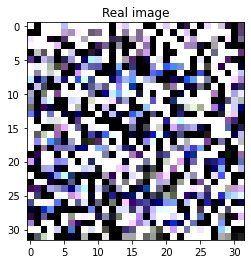

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


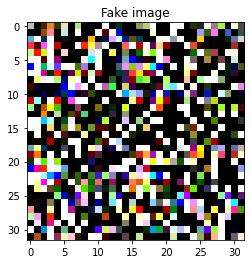

 20%|██        | 1/5 [00:00<00:00,  5.08it/s]

Epoch 61
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.32it/s]

Generator loss:  0.08537305798381567
Discriminator loss:  1.729798138141632
Epoch 62
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.1381340662483126
Discriminator loss:  1.729798138141632
Epoch 63
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.11it/s]

Generator loss:  0.16249408200383186
Discriminator loss:  1.744810163974762
Epoch 64
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.05it/s]

Generator loss:  0.05067438632249832
Discriminator loss:  1.744810163974762
Epoch 65
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.05it/s]

Generator loss:  0.054318765411153436
Discriminator loss:  1.744810163974762
Epoch 66
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.35it/s]

Generator loss:  0.04413563245907426
Discriminator loss:  1.7008937299251556
Epoch 67
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.04323750548064709
Discriminator loss:  1.7008937299251556
Epoch 68
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.07it/s]

Generator loss:  0.0714870784431696
Discriminator loss:  1.7008937299251556
Epoch 69
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.22it/s]

Generator loss:  0.07873967383056879
Discriminator loss:  1.7064062654972076
Epoch 70
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.13it/s]

Generator loss:  0.06777891144156456
Discriminator loss:  1.7064062654972076
Epoch 71
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.38it/s]

Generator loss:  0.10276859579607844
Discriminator loss:  1.7064062654972076
Epoch 72
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.11035030987113714
Discriminator loss:  1.7279338240623474
Epoch 73
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.08934677578508854
Discriminator loss:  1.7279338240623474
Epoch 74
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.07it/s]

Generator loss:  0.1344222417101264
Discriminator loss:  1.7279338240623474
Epoch 75
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.19it/s]

Generator loss:  0.06429448025301099
Discriminator loss:  1.71072319149971
Epoch 76
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.09233193937689066
Discriminator loss:  1.71072319149971
Epoch 77
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.22it/s]

Generator loss:  0.11170054972171783
Discriminator loss:  1.71072319149971
Epoch 78
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.18it/s]

Generator loss:  0.09429408516734838
Discriminator loss:  1.7092016637325287
Epoch 79
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.21096264757215977
Discriminator loss:  1.7092016637325287
Epoch 80
Noise std:  1


100%|██████████| 5/5 [00:01<00:00,  4.96it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.19537394866347313
Discriminator loss:  1.7092016637325287


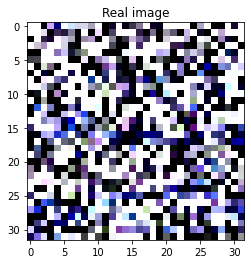

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


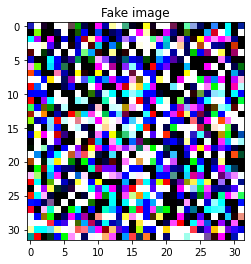

 20%|██        | 1/5 [00:00<00:00,  5.15it/s]

Epoch 81
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.26it/s]

Generator loss:  0.3845605179667473
Discriminator loss:  1.7214061915874481
Epoch 82
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.13it/s]

Generator loss:  0.41912804543972015
Discriminator loss:  1.7214061915874481
Epoch 83
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.21it/s]

Generator loss:  0.3656200058758259
Discriminator loss:  1.7214061915874481
Epoch 84
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.34it/s]

Generator loss:  0.4459105208516121
Discriminator loss:  1.7316015362739563
Epoch 85
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.4844392389059067
Discriminator loss:  1.7316015362739563
Epoch 86
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.25it/s]

Generator loss:  0.26970576494932175
Discriminator loss:  1.7316015362739563
Epoch 87
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.22361978515982628
Discriminator loss:  1.7276049256324768
Epoch 88
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.10it/s]

Generator loss:  0.2847644127905369
Discriminator loss:  1.7276049256324768
Epoch 89
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.04it/s]

Generator loss:  0.25697173923254013
Discriminator loss:  1.7276049256324768
Epoch 90
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.2408548705279827
Discriminator loss:  1.701094001531601
Epoch 91
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.28it/s]

Generator loss:  0.1588898040354252
Discriminator loss:  1.701094001531601
Epoch 92
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.04it/s]

Generator loss:  0.18142957240343094
Discriminator loss:  1.701094001531601
Epoch 93
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.14124400913715363
Discriminator loss:  1.7133368849754333
Epoch 94
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.32it/s]

Generator loss:  0.10177551954984665
Discriminator loss:  1.7133368849754333
Epoch 95
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.0859632808715105
Discriminator loss:  1.7133368849754333
Epoch 96
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.26it/s]

Generator loss:  0.08427002746611834
Discriminator loss:  1.724803239107132
Epoch 97
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.09090802632272243
Discriminator loss:  1.724803239107132
Epoch 98
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.28it/s]

Generator loss:  0.058637782000005245
Discriminator loss:  1.724803239107132
Epoch 99
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.09it/s]

Generator loss:  0.08222826197743416
Discriminator loss:  1.734979659318924
Epoch 100
Noise std:  1


100%|██████████| 5/5 [00:00<00:00,  5.02it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.07023421116173267
Discriminator loss:  1.734979659318924


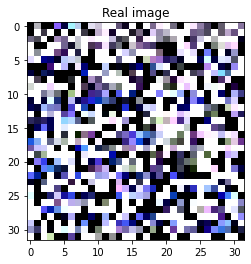

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


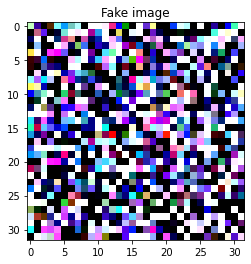

 20%|██        | 1/5 [00:00<00:00,  5.10it/s]

Epoch 101
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.15it/s]

Generator loss:  0.08291603811085224
Discriminator loss:  1.734979659318924
Epoch 102
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.08624853752553463
Discriminator loss:  1.7393032014369965
Epoch 103
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.19it/s]

Generator loss:  0.0831788363866508
Discriminator loss:  1.7393032014369965
Epoch 104
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.050681676249951124
Discriminator loss:  1.7393032014369965
Epoch 105
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.13it/s]

Generator loss:  0.082475570961833
Discriminator loss:  1.7564065754413605
Epoch 106
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.07it/s]

Generator loss:  0.11376682948321104
Discriminator loss:  1.7564065754413605
Epoch 107
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.04it/s]

Generator loss:  0.08987408690154552
Discriminator loss:  1.7564065754413605
Epoch 108
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.18it/s]

Generator loss:  0.0916734030470252
Discriminator loss:  1.7432178556919098
Epoch 109
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.15it/s]

Generator loss:  0.0995864374563098
Discriminator loss:  1.7432178556919098
Epoch 110
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.16it/s]

Generator loss:  0.12653150223195553
Discriminator loss:  1.7432178556919098
Epoch 111
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.05it/s]

Generator loss:  0.05467929900623858
Discriminator loss:  1.9695689678192139
Epoch 112
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  4.147305360995233
Discriminator loss:  1.9695689678192139
Epoch 113
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.07it/s]

Generator loss:  9.041895465766288
Discriminator loss:  1.9695689678192139
Epoch 114
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  2.983194051675575e-06
Discriminator loss:  2.7024341821670532
Epoch 115
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  3.7247494205638887e-07
Discriminator loss:  2.7024341821670532
Epoch 116
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.16it/s]

Generator loss:  5.178760517310366e-06
Discriminator loss:  2.7024341821670532
Epoch 117
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.0004954149981131195
Discriminator loss:  1.7412321865558624
Epoch 118
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.10it/s]

Generator loss:  0.00017637959535932168
Discriminator loss:  1.7412321865558624
Epoch 119
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.06it/s]

Generator loss:  0.0018333550324314274
Discriminator loss:  1.7412321865558624
Epoch 120
Noise std:  1


100%|██████████| 5/5 [00:01<00:00,  4.85it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.0038638490514131263
Discriminator loss:  1.7027151584625244


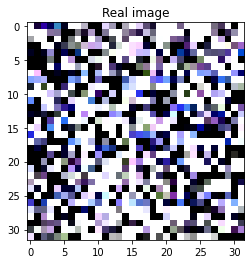

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


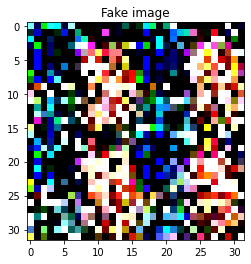

 20%|██        | 1/5 [00:00<00:00,  5.08it/s]

Epoch 121
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.02759753563441336
Discriminator loss:  1.7027151584625244
Epoch 122
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.03433595900423825
Discriminator loss:  1.7027151584625244
Epoch 123
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.06763575226068497
Discriminator loss:  1.7080330848693848
Epoch 124
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.11094528250396252
Discriminator loss:  1.7080330848693848
Epoch 125
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.15it/s]

Generator loss:  0.13960940018296242
Discriminator loss:  1.7080330848693848
Epoch 126
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.07it/s]

Generator loss:  0.1642836555838585
Discriminator loss:  1.7101581692695618
Epoch 127
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.25471948832273483
Discriminator loss:  1.7101581692695618
Epoch 128
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.27it/s]

Generator loss:  0.34125544130802155
Discriminator loss:  1.7101581692695618
Epoch 129
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.11it/s]

Generator loss:  0.6109456345438957
Discriminator loss:  1.8133791089057922
Epoch 130
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.15it/s]

Generator loss:  9.329860299825668
Discriminator loss:  1.8133791089057922
Epoch 131
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.22it/s]

Generator loss:  46.724764823913574
Discriminator loss:  1.8133791089057922
Epoch 132
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.21it/s]

Generator loss:  31.931000232696533
Discriminator loss:  1.8404675126075745
Epoch 133
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.24it/s]

Generator loss:  21.069234609603882
Discriminator loss:  1.8404675126075745
Epoch 134
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.11it/s]

Generator loss:  73.08742332458496
Discriminator loss:  1.8404675126075745
Epoch 135
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  36.48854923248291
Discriminator loss:  2.0730645060539246
Epoch 136
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.22it/s]

Generator loss:  7.3204957246780396
Discriminator loss:  2.0730645060539246
Epoch 137
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.09it/s]

Generator loss:  6.063565135002136
Discriminator loss:  2.0730645060539246
Epoch 138
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.24it/s]

Generator loss:  3.8974955081939697
Discriminator loss:  1.7146097123622894
Epoch 139
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  2.068269670009613
Discriminator loss:  1.7146097123622894
Epoch 140
Noise std:  1


100%|██████████| 5/5 [00:00<00:00,  5.01it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  1.0674069374799728
Discriminator loss:  1.7146097123622894


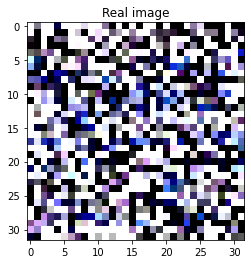

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


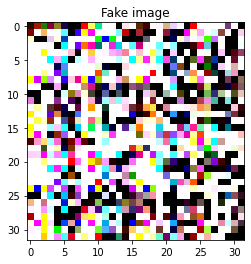

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 141
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.7795602977275848
Discriminator loss:  1.7000936269760132
Epoch 142
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.6243870705366135
Discriminator loss:  1.7000936269760132
Epoch 143
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.04it/s]

Generator loss:  0.4303707629442215
Discriminator loss:  1.7000936269760132
Epoch 144
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.27it/s]

Generator loss:  0.3941435217857361
Discriminator loss:  1.7012364566326141
Epoch 145
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.07it/s]

Generator loss:  0.35594823211431503
Discriminator loss:  1.7012364566326141
Epoch 146
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.2975812405347824
Discriminator loss:  1.7012364566326141
Epoch 147
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.12it/s]

Generator loss:  0.3241245411336422
Discriminator loss:  1.6998885571956635
Epoch 148
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.07it/s]

Generator loss:  0.34019307792186737
Discriminator loss:  1.6998885571956635
Epoch 149
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.26it/s]

Generator loss:  0.313338328152895
Discriminator loss:  1.6998885571956635
Epoch 150
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.20it/s]

Generator loss:  0.30270809680223465
Discriminator loss:  1.7209663689136505
Epoch 151
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.35428591072559357
Discriminator loss:  1.7209663689136505
Epoch 152
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.21it/s]

Generator loss:  0.5365752652287483
Discriminator loss:  1.7209663689136505
Epoch 153
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.6213746443390846
Discriminator loss:  1.7173955738544464
Epoch 154
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.37it/s]

Generator loss:  0.6500120535492897
Discriminator loss:  1.7173955738544464
Epoch 155
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.46it/s]

Generator loss:  0.7234589606523514
Discriminator loss:  1.7173955738544464
Epoch 156
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.8364259302616119
Discriminator loss:  1.724804699420929
Epoch 157
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.8617537617683411
Discriminator loss:  1.724804699420929
Epoch 158
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.05it/s]

Generator loss:  0.8936630934476852
Discriminator loss:  1.724804699420929
Epoch 159
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.35it/s]

Generator loss:  0.6999735236167908
Discriminator loss:  1.7055280804634094
Epoch 160
Noise std:  1


100%|██████████| 5/5 [00:00<00:00,  5.10it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.6739302277565002
Discriminator loss:  1.7055280804634094


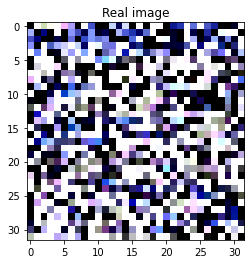

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


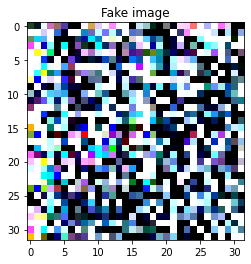

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 161
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.570360966026783
Discriminator loss:  1.7055280804634094
Epoch 162
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.5641450136899948
Discriminator loss:  1.6909525394439697
Epoch 163
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.5002411305904388
Discriminator loss:  1.6909525394439697
Epoch 164
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.20it/s]

Generator loss:  0.49704064428806305
Discriminator loss:  1.6909525394439697
Epoch 165
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.22it/s]

Generator loss:  0.5037890300154686
Discriminator loss:  1.7045002579689026
Epoch 166
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.11it/s]

Generator loss:  0.5795804858207703
Discriminator loss:  1.7045002579689026
Epoch 167
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.6587587594985962
Discriminator loss:  1.7045002579689026
Epoch 168
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.25it/s]

Generator loss:  0.921373724937439
Discriminator loss:  1.7172789573669434
Epoch 169
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.35it/s]

Generator loss:  0.6173921599984169
Discriminator loss:  1.7172789573669434
Epoch 170
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.31it/s]

Generator loss:  0.8156605958938599
Discriminator loss:  1.7172789573669434
Epoch 171
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.47969380021095276
Discriminator loss:  1.6959870159626007
Epoch 172
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.4216725081205368
Discriminator loss:  1.6959870159626007
Epoch 173
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.31it/s]

Generator loss:  0.3396066538989544
Discriminator loss:  1.6959870159626007
Epoch 174
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.30it/s]

Generator loss:  0.4471939578652382
Discriminator loss:  1.6910907328128815
Epoch 175
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.20it/s]

Generator loss:  0.3865678086876869
Discriminator loss:  1.6910907328128815
Epoch 176
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.09it/s]

Generator loss:  0.4034757912158966
Discriminator loss:  1.6910907328128815
Epoch 177
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.28it/s]

Generator loss:  0.6131627038121223
Discriminator loss:  1.7095946073532104
Epoch 178
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.6358774751424789
Discriminator loss:  1.7095946073532104
Epoch 179
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.34it/s]

Generator loss:  1.317719206213951
Discriminator loss:  1.7095946073532104
Epoch 180
Noise std:  1


100%|██████████| 5/5 [00:00<00:00,  5.04it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  4.601166129112244
Discriminator loss:  1.846227079629898


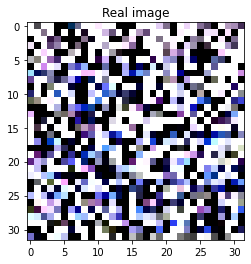

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


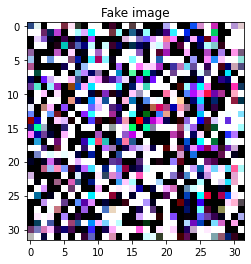

 20%|██        | 1/5 [00:00<00:00,  5.05it/s]

Epoch 181
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.08it/s]

Generator loss:  39.01775407791138
Discriminator loss:  1.846227079629898
Epoch 182
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.08it/s]

Generator loss:  83.63558387756348
Discriminator loss:  1.846227079629898
Epoch 183
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.20it/s]

Generator loss:  99.02709293365479
Discriminator loss:  2.317337155342102
Epoch 184
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.07it/s]

Generator loss:  178.3227653503418
Discriminator loss:  2.317337155342102
Epoch 185
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.15it/s]

Generator loss:  98.22637462615967
Discriminator loss:  2.317337155342102
Epoch 186
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.17it/s]

Generator loss:  61.15361785888672
Discriminator loss:  1.7828116714954376
Epoch 187
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.18it/s]

Generator loss:  23.53661298751831
Discriminator loss:  1.7828116714954376
Epoch 188
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  3.161696672439575
Discriminator loss:  1.7828116714954376
Epoch 189
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.09it/s]

Generator loss:  0.9592593237757683
Discriminator loss:  1.6841022670269012
Epoch 190
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.16it/s]

Generator loss:  0.8671555817127228
Discriminator loss:  1.6841022670269012
Epoch 191
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.20it/s]

Generator loss:  0.81928950548172
Discriminator loss:  1.6841022670269012
Epoch 192
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.6937701478600502
Discriminator loss:  1.6770308911800385
Epoch 193
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.11it/s]

Generator loss:  0.7268276363611221
Discriminator loss:  1.6770308911800385
Epoch 194
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.17it/s]

Generator loss:  0.9475527107715607
Discriminator loss:  1.6770308911800385
Epoch 195
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.04it/s]

Generator loss:  1.141436442732811
Discriminator loss:  1.6601110696792603
Epoch 196
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.37it/s]

Generator loss:  0.9710069894790649
Discriminator loss:  1.6601110696792603
Epoch 197
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.9920182973146439
Discriminator loss:  1.6601110696792603
Epoch 198
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.0624065548181534
Discriminator loss:  1.6507972478866577
Epoch 199
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.0017895102500916
Discriminator loss:  1.6507972478866577
Epoch 200
Noise std:  1


100%|██████████| 5/5 [00:01<00:00,  4.91it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  1.2605987936258316
Discriminator loss:  1.6507972478866577


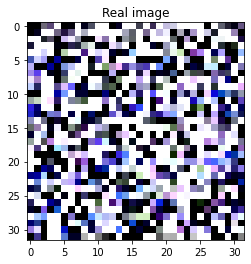

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


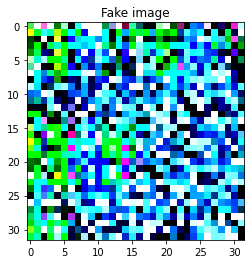

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 201
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.12it/s]

Generator loss:  1.3684935420751572
Discriminator loss:  1.6568694114685059
Epoch 202
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.537717193365097
Discriminator loss:  1.6568694114685059
Epoch 203
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.27it/s]

Generator loss:  1.519030511379242
Discriminator loss:  1.6568694114685059
Epoch 204
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.10it/s]

Generator loss:  2.017688661813736
Discriminator loss:  1.6548779904842377
Epoch 205
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.8382120728492737
Discriminator loss:  1.6548779904842377
Epoch 206
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.22it/s]

Generator loss:  2.09482005238533
Discriminator loss:  1.6548779904842377
Epoch 207
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.12it/s]

Generator loss:  2.5458995699882507
Discriminator loss:  1.6480929255485535
Epoch 208
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.24it/s]

Generator loss:  2.6860093474388123
Discriminator loss:  1.6480929255485535
Epoch 209
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.16it/s]

Generator loss:  2.427743136882782
Discriminator loss:  1.6480929255485535
Epoch 210
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  3.3275794982910156
Discriminator loss:  1.6481482982635498
Epoch 211
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.38it/s]

Generator loss:  3.709870457649231
Discriminator loss:  1.6481482982635498
Epoch 212
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  3.9285828471183777
Discriminator loss:  1.6481482982635498
Epoch 213
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.26it/s]

Generator loss:  4.586446464061737
Discriminator loss:  1.6543907821178436
Epoch 214
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.20it/s]

Generator loss:  5.003631770610809
Discriminator loss:  1.6543907821178436
Epoch 215
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.22it/s]

Generator loss:  4.533175587654114
Discriminator loss:  1.6543907821178436
Epoch 216
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.30it/s]

Generator loss:  4.8666399121284485
Discriminator loss:  1.6506130695343018
Epoch 217
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.08it/s]

Generator loss:  4.576183974742889
Discriminator loss:  1.6506130695343018
Epoch 218
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.05it/s]

Generator loss:  3.870643973350525
Discriminator loss:  1.6506130695343018
Epoch 219
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.20it/s]

Generator loss:  4.1357477605342865
Discriminator loss:  1.6588571965694427
Epoch 220
Noise std:  1


100%|██████████| 5/5 [00:00<00:00,  5.05it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  3.5510165691375732
Discriminator loss:  1.6588571965694427


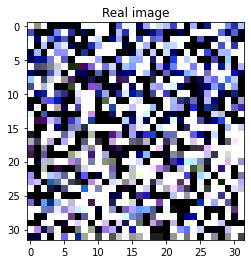

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


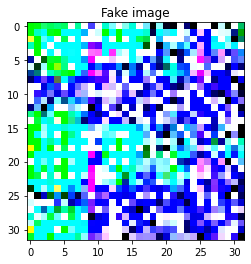

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 221
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.25it/s]

Generator loss:  4.557445228099823
Discriminator loss:  1.6588571965694427
Epoch 222
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.20it/s]

Generator loss:  3.638897120952606
Discriminator loss:  1.6505292057991028
Epoch 223
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.25it/s]

Generator loss:  3.2183499336242676
Discriminator loss:  1.6505292057991028
Epoch 224
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  2.651261031627655
Discriminator loss:  1.6505292057991028
Epoch 225
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.21it/s]

Generator loss:  2.223298579454422
Discriminator loss:  1.6506846249103546
Epoch 226
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.12it/s]

Generator loss:  1.9180831909179688
Discriminator loss:  1.6506846249103546
Epoch 227
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.7350707352161407
Discriminator loss:  1.6506846249103546
Epoch 228
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.18it/s]

Generator loss:  1.358927994966507
Discriminator loss:  1.6479443609714508
Epoch 229
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.23it/s]

Generator loss:  1.0910211354494095
Discriminator loss:  1.6479443609714508
Epoch 230
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.9411687403917313
Discriminator loss:  1.6479443609714508
Epoch 231
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.27it/s]

Generator loss:  0.9171871095895767
Discriminator loss:  1.6457379460334778
Epoch 232
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.9279687106609344
Discriminator loss:  1.6457379460334778
Epoch 233
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.13it/s]

Generator loss:  0.8359550833702087
Discriminator loss:  1.6457379460334778
Epoch 234
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.7309497594833374
Discriminator loss:  1.6490223109722137
Epoch 235
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.43it/s]

Generator loss:  0.8091261684894562
Discriminator loss:  1.6490223109722137
Epoch 236
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.11it/s]

Generator loss:  0.7384861037135124
Discriminator loss:  1.6490223109722137
Epoch 237
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.24it/s]

Generator loss:  0.6888771131634712
Discriminator loss:  1.643787443637848
Epoch 238
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.34it/s]

Generator loss:  0.6972601413726807
Discriminator loss:  1.643787443637848
Epoch 239
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.5293019860982895
Discriminator loss:  1.643787443637848
Epoch 240
Noise std:  1


100%|██████████| 5/5 [00:01<00:00,  4.94it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.5419268235564232
Discriminator loss:  1.6459587514400482


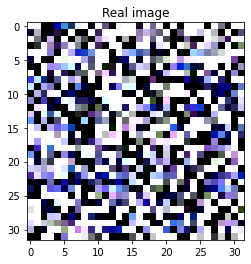

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


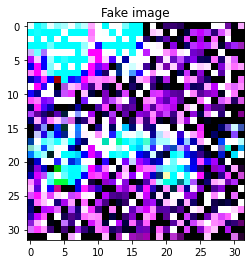

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 241
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.11it/s]

Generator loss:  0.5766901522874832
Discriminator loss:  1.6459587514400482
Epoch 242
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.6176773235201836
Discriminator loss:  1.6459587514400482
Epoch 243
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.12it/s]

Generator loss:  0.557378463447094
Discriminator loss:  1.6453472077846527
Epoch 244
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.28it/s]

Generator loss:  0.5857225805521011
Discriminator loss:  1.6453472077846527
Epoch 245
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.22it/s]

Generator loss:  0.6287998184561729
Discriminator loss:  1.6453472077846527
Epoch 246
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.16it/s]

Generator loss:  0.5434651002287865
Discriminator loss:  1.643383115530014
Epoch 247
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.24it/s]

Generator loss:  0.5589463114738464
Discriminator loss:  1.643383115530014
Epoch 248
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.21it/s]

Generator loss:  0.5019667893648148
Discriminator loss:  1.643383115530014
Epoch 249
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.5539881214499474
Discriminator loss:  1.650156319141388
Epoch 250
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.6220080479979515
Discriminator loss:  1.650156319141388
Epoch 251
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.19it/s]

Generator loss:  0.5424526855349541
Discriminator loss:  1.650156319141388
Epoch 252
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.21it/s]

Generator loss:  0.5342848300933838
Discriminator loss:  1.6483188569545746
Epoch 253
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.4618275836110115
Discriminator loss:  1.6483188569545746
Epoch 254
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.5208523795008659
Discriminator loss:  1.6483188569545746
Epoch 255
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.45it/s]

Generator loss:  0.5509234443306923
Discriminator loss:  1.653003454208374
Epoch 256
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.5380595028400421
Discriminator loss:  1.653003454208374
Epoch 257
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.22it/s]

Generator loss:  0.5331984907388687
Discriminator loss:  1.653003454208374
Epoch 258
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.584087498486042
Discriminator loss:  1.6492893993854523
Epoch 259
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.23it/s]

Generator loss:  0.6356682404875755
Discriminator loss:  1.6492893993854523
Epoch 260
Noise std:  1


100%|██████████| 5/5 [00:00<00:00,  5.09it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.6433628797531128
Discriminator loss:  1.6492893993854523


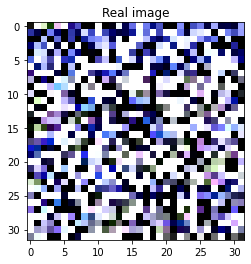

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


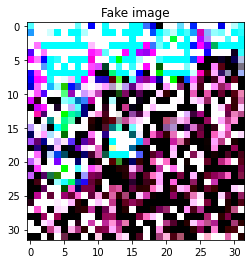

 20%|██        | 1/5 [00:00<00:00,  5.20it/s]

Epoch 261
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.6437675282359123
Discriminator loss:  1.6477511823177338
Epoch 262
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.30it/s]

Generator loss:  0.5727026984095573
Discriminator loss:  1.6477511823177338
Epoch 263
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.23it/s]

Generator loss:  0.5384246930480003
Discriminator loss:  1.6477511823177338
Epoch 264
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.04it/s]

Generator loss:  0.5778412520885468
Discriminator loss:  1.650886356830597
Epoch 265
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.37it/s]

Generator loss:  0.5843431726098061
Discriminator loss:  1.650886356830597
Epoch 266
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.28it/s]

Generator loss:  0.591774694621563
Discriminator loss:  1.650886356830597
Epoch 267
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.05it/s]

Generator loss:  0.5401622503995895
Discriminator loss:  1.6505391597747803
Epoch 268
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.24it/s]

Generator loss:  0.7021642476320267
Discriminator loss:  1.6505391597747803
Epoch 269
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.7062802165746689
Discriminator loss:  1.6505391597747803
Epoch 270
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.7363469302654266
Discriminator loss:  1.648457944393158
Epoch 271
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.7076412290334702
Discriminator loss:  1.648457944393158
Epoch 272
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.7150539606809616
Discriminator loss:  1.648457944393158
Epoch 273
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.7329034507274628
Discriminator loss:  1.650180995464325
Epoch 274
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.7147391587495804
Discriminator loss:  1.650180995464325
Epoch 275
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.6788096204400063
Discriminator loss:  1.650180995464325
Epoch 276
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.7636031359434128
Discriminator loss:  1.6479263305664062
Epoch 277
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.7520603090524673
Discriminator loss:  1.6479263305664062
Epoch 278
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.7115847766399384
Discriminator loss:  1.6479263305664062
Epoch 279
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.05it/s]

Generator loss:  0.694776140153408
Discriminator loss:  1.6481159031391144
Epoch 280
Noise std:  1


100%|██████████| 5/5 [00:00<00:00,  5.04it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.7166799008846283
Discriminator loss:  1.6481159031391144


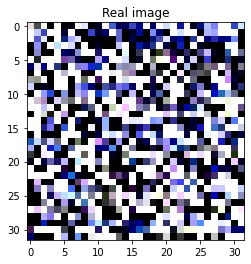

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


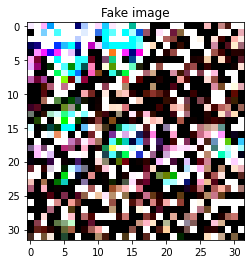

 20%|██        | 1/5 [00:00<00:00,  5.18it/s]

Epoch 281
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.7834165692329407
Discriminator loss:  1.6481159031391144
Epoch 282
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.39it/s]

Generator loss:  0.8873743116855621
Discriminator loss:  1.6498871445655823
Epoch 283
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.772761344909668
Discriminator loss:  1.6498871445655823
Epoch 284
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.20it/s]

Generator loss:  0.6577779203653336
Discriminator loss:  1.6498871445655823
Epoch 285
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.12it/s]

Generator loss:  0.62380650639534
Discriminator loss:  1.6515800952911377
Epoch 286
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.6277759224176407
Discriminator loss:  1.6515800952911377
Epoch 287
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.6481033861637115
Discriminator loss:  1.6515800952911377
Epoch 288
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.23it/s]

Generator loss:  0.6354689374566078
Discriminator loss:  1.648014485836029
Epoch 289
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.12it/s]

Generator loss:  0.5876840427517891
Discriminator loss:  1.648014485836029
Epoch 290
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.25it/s]

Generator loss:  0.6395211592316628
Discriminator loss:  1.648014485836029
Epoch 291
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.25it/s]

Generator loss:  0.7915650457143784
Discriminator loss:  1.6596862971782684
Epoch 292
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.25it/s]

Generator loss:  0.7974023520946503
Discriminator loss:  1.6596862971782684
Epoch 293
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.8060686439275742
Discriminator loss:  1.6596862971782684
Epoch 294
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.7338497042655945
Discriminator loss:  1.648636668920517
Epoch 295
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.09it/s]

Generator loss:  0.809589222073555
Discriminator loss:  1.648636668920517
Epoch 296
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.7021971940994263
Discriminator loss:  1.648636668920517
Epoch 297
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.13it/s]

Generator loss:  0.8234445303678513
Discriminator loss:  1.6464678943157196
Epoch 298
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.19it/s]

Generator loss:  0.7836847901344299
Discriminator loss:  1.6464678943157196
Epoch 299
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.16it/s]

Generator loss:  0.8041816204786301
Discriminator loss:  1.6464678943157196
Epoch 300
Noise std:  1


100%|██████████| 5/5 [00:00<00:00,  5.01it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.7953312993049622
Discriminator loss:  1.6440126597881317


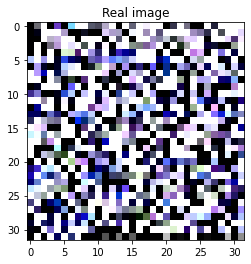

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


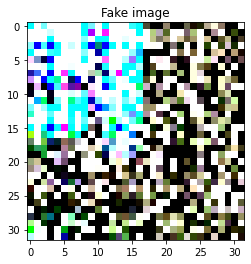

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 301
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.29it/s]

Generator loss:  0.79526287317276
Discriminator loss:  1.6440126597881317
Epoch 302
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.26it/s]

Generator loss:  0.833201140165329
Discriminator loss:  1.6440126597881317
Epoch 303
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.21it/s]

Generator loss:  0.6594527661800385
Discriminator loss:  1.6519259810447693
Epoch 304
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.31it/s]

Generator loss:  1.0739690363407135
Discriminator loss:  1.6519259810447693
Epoch 305
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.21it/s]

Generator loss:  0.9753308892250061
Discriminator loss:  1.6519259810447693
Epoch 306
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.37it/s]

Generator loss:  0.9011890888214111
Discriminator loss:  1.642263650894165
Epoch 307
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.8927229195833206
Discriminator loss:  1.642263650894165
Epoch 308
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.19it/s]

Generator loss:  0.8397589102387428
Discriminator loss:  1.642263650894165
Epoch 309
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.9702559560537338
Discriminator loss:  1.6400249004364014
Epoch 310
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.23it/s]

Generator loss:  0.867485523223877
Discriminator loss:  1.6400249004364014
Epoch 311
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.8347815126180649
Discriminator loss:  1.6400249004364014
Epoch 312
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.7383446246385574
Discriminator loss:  1.6492575407028198
Epoch 313
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.15it/s]

Generator loss:  0.7998065650463104
Discriminator loss:  1.6492575407028198
Epoch 314
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.11it/s]

Generator loss:  0.7340961769223213
Discriminator loss:  1.6492575407028198
Epoch 315
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.20it/s]

Generator loss:  0.728441596031189
Discriminator loss:  1.6503092646598816
Epoch 316
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.8109989166259766
Discriminator loss:  1.6503092646598816
Epoch 317
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.13it/s]

Generator loss:  0.7066529244184494
Discriminator loss:  1.6503092646598816
Epoch 318
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.6923578679561615
Discriminator loss:  1.6441657543182373
Epoch 319
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.12it/s]

Generator loss:  0.506567470729351
Discriminator loss:  1.6441657543182373
Epoch 320
Noise std:  1


100%|██████████| 5/5 [00:00<00:00,  5.03it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.6665330678224564
Discriminator loss:  1.6441657543182373


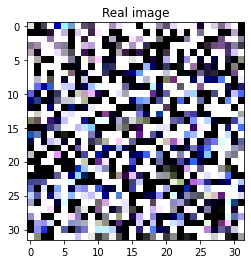

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


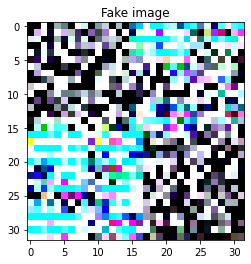

 20%|██        | 1/5 [00:00<00:00,  5.19it/s]

Epoch 321
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.21it/s]

Generator loss:  0.4828377813100815
Discriminator loss:  1.6477021276950836
Epoch 322
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.11it/s]

Generator loss:  0.4579807445406914
Discriminator loss:  1.6477021276950836
Epoch 323
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.3617417961359024
Discriminator loss:  1.6477021276950836
Epoch 324
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.37it/s]

Generator loss:  0.4808349534869194
Discriminator loss:  1.6458045542240143
Epoch 325
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.06it/s]

Generator loss:  0.44606585800647736
Discriminator loss:  1.6458045542240143
Epoch 326
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.49142374098300934
Discriminator loss:  1.6458045542240143
Epoch 327
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.27it/s]

Generator loss:  0.3929987847805023
Discriminator loss:  1.6530657708644867
Epoch 328
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.3459475599229336
Discriminator loss:  1.6530657708644867
Epoch 329
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.2378707304596901
Discriminator loss:  1.6530657708644867
Epoch 330
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.39948348328471184
Discriminator loss:  1.6600369811058044
Epoch 331
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.31144295632839203
Discriminator loss:  1.6600369811058044
Epoch 332
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.12it/s]

Generator loss:  0.3216610476374626
Discriminator loss:  1.6600369811058044
Epoch 333
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.39it/s]

Generator loss:  0.2421824112534523
Discriminator loss:  1.6656838059425354
Epoch 334
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.36it/s]

Generator loss:  0.20347507297992706
Discriminator loss:  1.6656838059425354
Epoch 335
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.3064983896911144
Discriminator loss:  1.6656838059425354
Epoch 336
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.27it/s]

Generator loss:  0.2941978368908167
Discriminator loss:  1.6758623123168945
Epoch 337
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.23it/s]

Generator loss:  0.6094414815306664
Discriminator loss:  1.6758623123168945
Epoch 338
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  5.456811971962452
Discriminator loss:  1.6758623123168945
Epoch 339
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.16it/s]

Generator loss:  3.2290992656489834
Discriminator loss:  1.9474905729293823
Epoch 340
Noise std:  1


100%|██████████| 5/5 [00:01<00:00,  4.93it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.00920750224031508
Discriminator loss:  1.9474905729293823


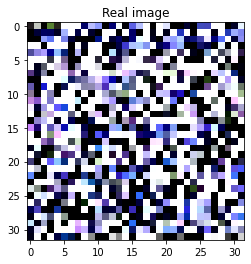

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


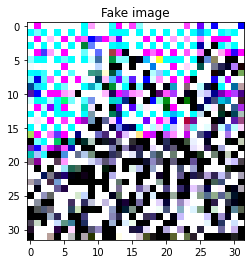

 20%|██        | 1/5 [00:00<00:00,  5.21it/s]

Epoch 341
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.21it/s]

Generator loss:  0.044075644575059414
Discriminator loss:  1.9474905729293823
Epoch 342
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.13it/s]

Generator loss:  0.060965439304709435
Discriminator loss:  1.662363350391388
Epoch 343
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.07it/s]

Generator loss:  0.09404660761356354
Discriminator loss:  1.662363350391388
Epoch 344
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.04it/s]

Generator loss:  0.14318363927304745
Discriminator loss:  1.662363350391388
Epoch 345
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.17it/s]

Generator loss:  0.14560194499790668
Discriminator loss:  1.6457003951072693
Epoch 346
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.08it/s]

Generator loss:  0.1514627616852522
Discriminator loss:  1.6457003951072693
Epoch 347
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.15it/s]

Generator loss:  0.20743604190647602
Discriminator loss:  1.6457003951072693
Epoch 348
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.40it/s]

Generator loss:  0.2085186466574669
Discriminator loss:  1.6434351801872253
Epoch 349
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.2875110078603029
Discriminator loss:  1.6434351801872253
Epoch 350
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.10it/s]

Generator loss:  0.27724750339984894
Discriminator loss:  1.6434351801872253
Epoch 351
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.3466930091381073
Discriminator loss:  1.6479397118091583
Epoch 352
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.39056793972849846
Discriminator loss:  1.6479397118091583
Epoch 353
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.44it/s]

Generator loss:  0.37136252224445343
Discriminator loss:  1.6479397118091583
Epoch 354
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.14it/s]

Generator loss:  0.47356120496988297
Discriminator loss:  1.6445536017417908
Epoch 355
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.14it/s]

Generator loss:  0.4809972867369652
Discriminator loss:  1.6445536017417908
Epoch 356
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.11it/s]

Generator loss:  0.6347455680370331
Discriminator loss:  1.6445536017417908
Epoch 357
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.24it/s]

Generator loss:  0.6009495928883553
Discriminator loss:  1.6416431069374084
Epoch 358
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.19it/s]

Generator loss:  0.499325156211853
Discriminator loss:  1.6416431069374084
Epoch 359
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.3591657280921936
Discriminator loss:  1.6416431069374084
Epoch 360
Noise std:  1


100%|██████████| 5/5 [00:01<00:00,  4.84it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.2905970588326454
Discriminator loss:  1.659623771905899


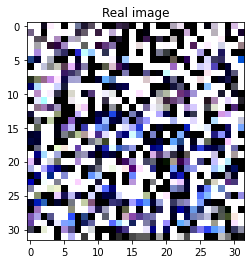

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


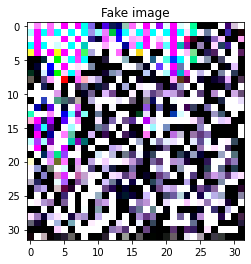

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 361
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.27342671900987625
Discriminator loss:  1.659623771905899
Epoch 362
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.36445237323641777
Discriminator loss:  1.659623771905899
Epoch 363
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.31it/s]

Generator loss:  0.4906150996685028
Discriminator loss:  1.6575525403022766
Epoch 364
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.09it/s]

Generator loss:  0.4844994693994522
Discriminator loss:  1.6575525403022766
Epoch 365
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.12it/s]

Generator loss:  0.49200455844402313
Discriminator loss:  1.6575525403022766
Epoch 366
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.17it/s]

Generator loss:  0.5729257687926292
Discriminator loss:  1.6528887450695038
Epoch 367
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.5209894925355911
Discriminator loss:  1.6528887450695038
Epoch 368
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.15it/s]

Generator loss:  0.8848936408758163
Discriminator loss:  1.6528887450695038
Epoch 369
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.8331944048404694
Discriminator loss:  1.6485553979873657
Epoch 370
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.27it/s]

Generator loss:  0.6973491758108139
Discriminator loss:  1.6485553979873657
Epoch 371
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.12it/s]

Generator loss:  0.8067746162414551
Discriminator loss:  1.6485553979873657
Epoch 372
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.24it/s]

Generator loss:  0.8838099092245102
Discriminator loss:  1.649373859167099
Epoch 373
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.07it/s]

Generator loss:  1.4581500738859177
Discriminator loss:  1.649373859167099
Epoch 374
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.26it/s]

Generator loss:  3.0483964383602142
Discriminator loss:  1.649373859167099
Epoch 375
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.19it/s]

Generator loss:  2.147103190422058
Discriminator loss:  1.6673601865768433
Epoch 376
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.27it/s]

Generator loss:  2.1919767260551453
Discriminator loss:  1.6673601865768433
Epoch 377
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.08it/s]

Generator loss:  2.1239529848098755
Discriminator loss:  1.6673601865768433
Epoch 378
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.42it/s]

Generator loss:  1.5961669385433197
Discriminator loss:  1.662087231874466
Epoch 379
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.9925850331783295
Discriminator loss:  1.662087231874466
Epoch 380
Noise std:  1


100%|██████████| 5/5 [00:01<00:00,  4.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  1.6131504774093628
Discriminator loss:  1.662087231874466


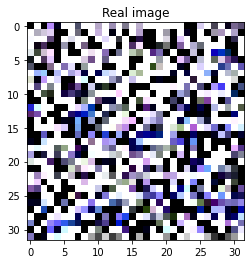

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


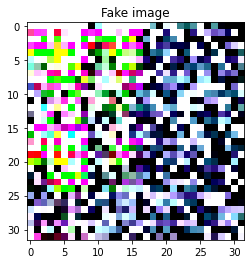

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 381
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.08it/s]

Generator loss:  1.6822576373815536
Discriminator loss:  1.6763589978218079
Epoch 382
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.14it/s]

Generator loss:  1.5060198903083801
Discriminator loss:  1.6763589978218079
Epoch 383
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.19it/s]

Generator loss:  0.975859060883522
Discriminator loss:  1.6763589978218079
Epoch 384
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.13it/s]

Generator loss:  1.5240302085876465
Discriminator loss:  1.6485086679458618
Epoch 385
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.34it/s]

Generator loss:  1.5859888195991516
Discriminator loss:  1.6485086679458618
Epoch 386
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.4887842535972595
Discriminator loss:  1.6485086679458618
Epoch 387
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.536035031080246
Discriminator loss:  1.649280995130539
Epoch 388
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.23it/s]

Generator loss:  1.2937628626823425
Discriminator loss:  1.649280995130539
Epoch 389
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.24it/s]

Generator loss:  1.3226207792758942
Discriminator loss:  1.649280995130539
Epoch 390
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.20it/s]

Generator loss:  1.1670734733343124
Discriminator loss:  1.6461197137832642
Epoch 391
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.9834882766008377
Discriminator loss:  1.6461197137832642
Epoch 392
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.12it/s]

Generator loss:  0.8983363807201385
Discriminator loss:  1.6461197137832642
Epoch 393
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.11it/s]

Generator loss:  0.7270813584327698
Discriminator loss:  1.6444973349571228
Epoch 394
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.19it/s]

Generator loss:  0.6999040320515633
Discriminator loss:  1.6444973349571228
Epoch 395
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.14it/s]

Generator loss:  0.6135781183838844
Discriminator loss:  1.6444973349571228
Epoch 396
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.09it/s]

Generator loss:  0.7345098331570625
Discriminator loss:  1.638572782278061
Epoch 397
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.6678155213594437
Discriminator loss:  1.638572782278061
Epoch 398
Noise std:  1


 20%|██        | 1/5 [00:00<00:00,  5.48it/s]

Generator loss:  0.7652411609888077
Discriminator loss:  1.638572782278061
Epoch 399
Noise std:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.6914826706051826
Discriminator loss:  1.6386188566684723
Epoch 400
Noise std:  1


100%|██████████| 5/5 [00:00<00:00,  5.02it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.8104554116725922
Discriminator loss:  1.6386188566684723


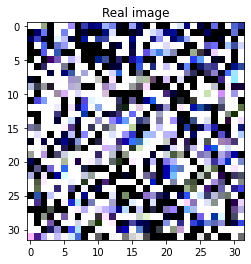

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


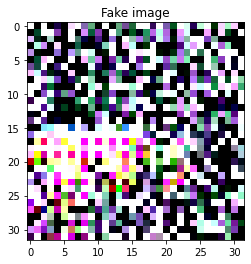

 20%|██        | 1/5 [00:00<00:00,  5.01it/s]

Epoch 401
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.07it/s]

Generator loss:  0.856740415096283
Discriminator loss:  1.6386188566684723
Epoch 402
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.772194892168045
Discriminator loss:  1.634271264076233
Epoch 403
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.05it/s]

Generator loss:  0.8301906138658524
Discriminator loss:  1.634271264076233
Epoch 404
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.24it/s]

Generator loss:  1.264474093914032
Discriminator loss:  1.634271264076233
Epoch 405
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.13it/s]

Generator loss:  1.1848682165145874
Discriminator loss:  1.638306736946106
Epoch 406
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.04it/s]

Generator loss:  1.2573435008525848
Discriminator loss:  1.638306736946106
Epoch 407
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.43it/s]

Generator loss:  0.7943445593118668
Discriminator loss:  1.638306736946106
Epoch 408
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.714093878865242
Discriminator loss:  1.6421395242214203
Epoch 409
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.9294919073581696
Discriminator loss:  1.6421395242214203
Epoch 410
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.09it/s]

Generator loss:  0.7094913721084595
Discriminator loss:  1.6421395242214203
Epoch 411
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.11it/s]

Generator loss:  0.6189547032117844
Discriminator loss:  1.6352737545967102
Epoch 412
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.04it/s]

Generator loss:  0.667776845395565
Discriminator loss:  1.6352737545967102
Epoch 413
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.08it/s]

Generator loss:  1.2900761812925339
Discriminator loss:  1.6352737545967102
Epoch 414
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.25it/s]

Generator loss:  1.1752040684223175
Discriminator loss:  1.6388936638832092
Epoch 415
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.23it/s]

Generator loss:  0.7468607127666473
Discriminator loss:  1.6388936638832092
Epoch 416
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.6528448686003685
Discriminator loss:  1.6388936638832092
Epoch 417
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.07it/s]

Generator loss:  0.6723133772611618
Discriminator loss:  1.6358635425567627
Epoch 418
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.09it/s]

Generator loss:  0.5638712421059608
Discriminator loss:  1.6358635425567627
Epoch 419
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.09it/s]

Generator loss:  0.5990102961659431
Discriminator loss:  1.6358635425567627
Epoch 420
Noise std:  0.5


100%|██████████| 5/5 [00:00<00:00,  5.01it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.5719563215970993
Discriminator loss:  1.6357765793800354


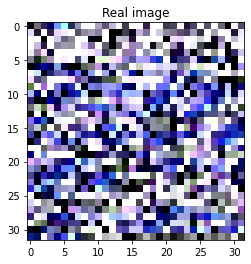

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


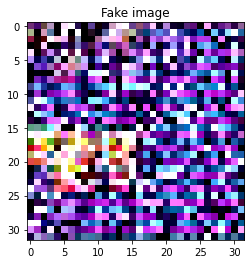

 20%|██        | 1/5 [00:00<00:00,  5.07it/s]

Epoch 421
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.6091783791780472
Discriminator loss:  1.6357765793800354
Epoch 422
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.41it/s]

Generator loss:  0.6307143345475197
Discriminator loss:  1.6357765793800354
Epoch 423
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.10it/s]

Generator loss:  0.6888356059789658
Discriminator loss:  1.6389057636260986
Epoch 424
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.03it/s]

Generator loss:  0.6789650917053223
Discriminator loss:  1.6389057636260986
Epoch 425
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.7917687147855759
Discriminator loss:  1.6389057636260986
Epoch 426
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.6669568717479706
Discriminator loss:  1.6362357139587402
Epoch 427
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.8492612838745117
Discriminator loss:  1.6362357139587402
Epoch 428
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.7844179719686508
Discriminator loss:  1.6362357139587402
Epoch 429
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.17it/s]

Generator loss:  0.8006493598222733
Discriminator loss:  1.6331185400485992
Epoch 430
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.8727924227714539
Discriminator loss:  1.6331185400485992
Epoch 431
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.17it/s]

Generator loss:  1.005013644695282
Discriminator loss:  1.6331185400485992
Epoch 432
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.0849997103214264
Discriminator loss:  1.6350508332252502
Epoch 433
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.10it/s]

Generator loss:  1.213644564151764
Discriminator loss:  1.6350508332252502
Epoch 434
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.10it/s]

Generator loss:  1.1436565816402435
Discriminator loss:  1.6350508332252502
Epoch 435
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.02it/s]

Generator loss:  1.3310168981552124
Discriminator loss:  1.6389242112636566
Epoch 436
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.2150682359933853
Discriminator loss:  1.6389242112636566
Epoch 437
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.08it/s]

Generator loss:  0.9586770087480545
Discriminator loss:  1.6389242112636566
Epoch 438
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.9050002843141556
Discriminator loss:  1.639052391052246
Epoch 439
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.913858562707901
Discriminator loss:  1.639052391052246
Epoch 440
Noise std:  0.5


100%|██████████| 5/5 [00:00<00:00,  5.01it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.7531606405973434
Discriminator loss:  1.639052391052246


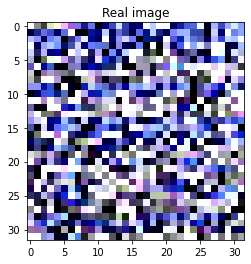

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


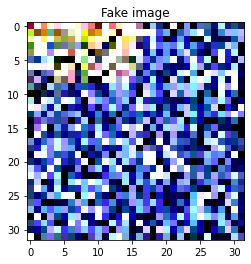

 20%|██        | 1/5 [00:00<00:00,  5.08it/s]

Epoch 441
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.31it/s]

Generator loss:  0.6355614066123962
Discriminator loss:  1.6340442299842834
Epoch 442
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.6241020485758781
Discriminator loss:  1.6340442299842834
Epoch 443
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.5808204114437103
Discriminator loss:  1.6340442299842834
Epoch 444
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.19it/s]

Generator loss:  0.49018438905477524
Discriminator loss:  1.6424333453178406
Epoch 445
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.6516848430037498
Discriminator loss:  1.6424333453178406
Epoch 446
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.18it/s]

Generator loss:  0.5642824023962021
Discriminator loss:  1.6424333453178406
Epoch 447
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.6563977971673012
Discriminator loss:  1.6384339034557343
Epoch 448
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.08it/s]

Generator loss:  0.5920397192239761
Discriminator loss:  1.6384339034557343
Epoch 449
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.12it/s]

Generator loss:  0.659886047244072
Discriminator loss:  1.6384339034557343
Epoch 450
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.10it/s]

Generator loss:  0.8340537995100021
Discriminator loss:  1.637537032365799
Epoch 451
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.16it/s]

Generator loss:  0.8250057995319366
Discriminator loss:  1.637537032365799
Epoch 452
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.762810006737709
Discriminator loss:  1.637537032365799
Epoch 453
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.7978657782077789
Discriminator loss:  1.639180600643158
Epoch 454
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.21it/s]

Generator loss:  0.7295389324426651
Discriminator loss:  1.639180600643158
Epoch 455
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.8345575928688049
Discriminator loss:  1.639180600643158
Epoch 456
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.27it/s]

Generator loss:  0.8245495855808258
Discriminator loss:  1.6376205086708069
Epoch 457
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.8035098165273666
Discriminator loss:  1.6376205086708069
Epoch 458
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.8489685505628586
Discriminator loss:  1.6376205086708069
Epoch 459
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.16it/s]

Generator loss:  1.1564359068870544
Discriminator loss:  1.6463311314582825
Epoch 460
Noise std:  0.5


100%|██████████| 5/5 [00:00<00:00,  5.06it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  1.4471030533313751
Discriminator loss:  1.6463311314582825


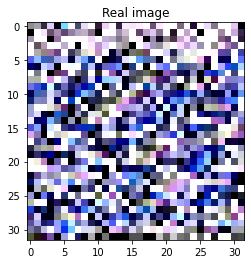

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


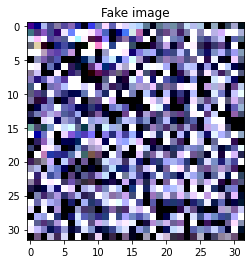

 20%|██        | 1/5 [00:00<00:00,  5.17it/s]

Epoch 461
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.18it/s]

Generator loss:  3.849785268306732
Discriminator loss:  1.6463311314582825
Epoch 462
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  8.078651905059814
Discriminator loss:  1.7128516733646393
Epoch 463
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  3.6674378742463887
Discriminator loss:  1.7128516733646393
Epoch 464
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  17.335049718618393
Discriminator loss:  1.7128516733646393
Epoch 465
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.17it/s]

Generator loss:  5.9027532041072845
Discriminator loss:  1.688144028186798
Epoch 466
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.20it/s]

Generator loss:  0.5244585797190666
Discriminator loss:  1.688144028186798
Epoch 467
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.31it/s]

Generator loss:  0.8079031631350517
Discriminator loss:  1.688144028186798
Epoch 468
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.15015935897827148
Discriminator loss:  1.649587243795395
Epoch 469
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.22it/s]

Generator loss:  0.3499511443078518
Discriminator loss:  1.649587243795395
Epoch 470
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.12it/s]

Generator loss:  0.8708387091755867
Discriminator loss:  1.649587243795395
Epoch 471
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.26it/s]

Generator loss:  7.01328906416893
Discriminator loss:  1.6630315482616425
Epoch 472
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.29it/s]

Generator loss:  14.148289799690247
Discriminator loss:  1.6630315482616425
Epoch 473
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.12it/s]

Generator loss:  18.495168209075928
Discriminator loss:  1.6630315482616425
Epoch 474
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  19.347703456878662
Discriminator loss:  1.6796591877937317
Epoch 475
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.13it/s]

Generator loss:  5.174675762653351
Discriminator loss:  1.6796591877937317
Epoch 476
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.21it/s]

Generator loss:  2.6881852447986603
Discriminator loss:  1.6796591877937317
Epoch 477
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  4.97it/s]

Generator loss:  2.850221961736679
Discriminator loss:  1.6441151201725006
Epoch 478
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  2.454453706741333
Discriminator loss:  1.6441151201725006
Epoch 479
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.20it/s]

Generator loss:  1.951619178056717
Discriminator loss:  1.6441151201725006
Epoch 480
Noise std:  0.5


100%|██████████| 5/5 [00:00<00:00,  5.00it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  1.2205958813428879
Discriminator loss:  1.6520852148532867


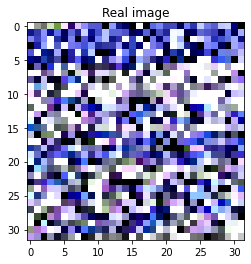

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


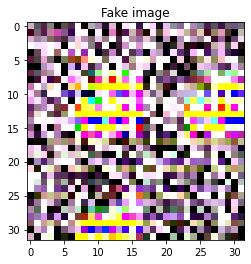

 20%|██        | 1/5 [00:00<00:00,  5.16it/s]

Epoch 481
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.06it/s]

Generator loss:  0.8519561290740967
Discriminator loss:  1.6520852148532867
Epoch 482
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.0372629314661026
Discriminator loss:  1.6520852148532867
Epoch 483
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.1726816296577454
Discriminator loss:  1.6421378552913666
Epoch 484
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.04it/s]

Generator loss:  1.1893206685781479
Discriminator loss:  1.6421378552913666
Epoch 485
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.05it/s]

Generator loss:  1.6375194936990738
Discriminator loss:  1.6421378552913666
Epoch 486
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.1416237130761147
Discriminator loss:  1.6483339071273804
Epoch 487
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.6373096406459808
Discriminator loss:  1.6483339071273804
Epoch 488
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.06it/s]

Generator loss:  0.8292884826660156
Discriminator loss:  1.6483339071273804
Epoch 489
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.022720068693161
Discriminator loss:  1.6425434350967407
Epoch 490
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.048449695110321
Discriminator loss:  1.6425434350967407
Epoch 491
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.17it/s]

Generator loss:  0.8618928790092468
Discriminator loss:  1.6425434350967407
Epoch 492
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.20it/s]

Generator loss:  0.958938866853714
Discriminator loss:  1.6401751637458801
Epoch 493
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.07it/s]

Generator loss:  0.8230577260255814
Discriminator loss:  1.6401751637458801
Epoch 494
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.7719540596008301
Discriminator loss:  1.6401751637458801
Epoch 495
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.8081237375736237
Discriminator loss:  1.6420369148254395
Epoch 496
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.09it/s]

Generator loss:  0.7368611097335815
Discriminator loss:  1.6420369148254395
Epoch 497
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.9480323195457458
Discriminator loss:  1.6420369148254395
Epoch 498
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.7913350015878677
Discriminator loss:  1.6419527530670166
Epoch 499
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.1582143306732178
Discriminator loss:  1.6419527530670166
Epoch 500
Noise std:  0.5


100%|██████████| 5/5 [00:01<00:00,  4.92it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  1.1523960828781128
Discriminator loss:  1.6419527530670166


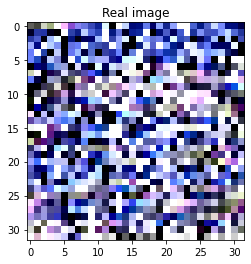

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


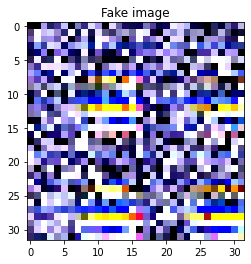

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 501
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.01it/s]

Generator loss:  1.70908223092556
Discriminator loss:  1.6486543416976929
Epoch 502
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  2.53443843126297
Discriminator loss:  1.6486543416976929
Epoch 503
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.46it/s]

Generator loss:  10.808977603912354
Discriminator loss:  1.6486543416976929
Epoch 504
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  19.28666853904724
Discriminator loss:  1.6683695316314697
Epoch 505
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.21it/s]

Generator loss:  12.59831154346466
Discriminator loss:  1.6683695316314697
Epoch 506
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.1817227602005005
Discriminator loss:  1.6683695316314697
Epoch 507
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.6074991673231125
Discriminator loss:  1.6662693321704865
Epoch 508
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.26it/s]

Generator loss:  0.4742353484034538
Discriminator loss:  1.6662693321704865
Epoch 509
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.17it/s]

Generator loss:  0.5267551764845848
Discriminator loss:  1.6662693321704865
Epoch 510
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.17it/s]

Generator loss:  0.47069109231233597
Discriminator loss:  1.651556134223938
Epoch 511
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.24it/s]

Generator loss:  0.6130543351173401
Discriminator loss:  1.651556134223938
Epoch 512
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.11it/s]

Generator loss:  0.5590234622359276
Discriminator loss:  1.651556134223938
Epoch 513
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.33it/s]

Generator loss:  0.7353532984852791
Discriminator loss:  1.7197757959365845
Epoch 514
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.22it/s]

Generator loss:  35.47307765483856
Discriminator loss:  1.7197757959365845
Epoch 515
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.35it/s]

Generator loss:  47.30641841888428
Discriminator loss:  1.7197757959365845
Epoch 516
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  49.81813621520996
Discriminator loss:  2.481293648481369
Epoch 517
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.07it/s]

Generator loss:  21.54447889328003
Discriminator loss:  2.481293648481369
Epoch 518
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  12.688387632369995
Discriminator loss:  2.481293648481369
Epoch 519
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.03it/s]

Generator loss:  8.901475250720978
Discriminator loss:  1.8023269772529602
Epoch 520
Noise std:  0.5


100%|██████████| 5/5 [00:01<00:00,  4.98it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  3.128275752067566
Discriminator loss:  1.8023269772529602


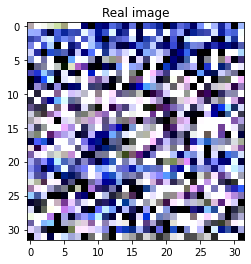

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


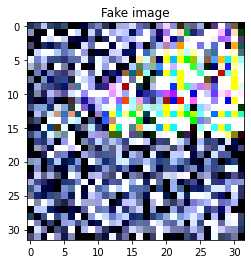

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 521
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  5.346733272075653
Discriminator loss:  1.8023269772529602
Epoch 522
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.19it/s]

Generator loss:  9.521427750587463
Discriminator loss:  1.9298295974731445
Epoch 523
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.22it/s]

Generator loss:  8.683045148849487
Discriminator loss:  1.9298295974731445
Epoch 524
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.19it/s]

Generator loss:  5.687432408332825
Discriminator loss:  1.9298295974731445
Epoch 525
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.28it/s]

Generator loss:  1.0122297257184982
Discriminator loss:  1.6922176480293274
Epoch 526
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.05it/s]

Generator loss:  0.556130938231945
Discriminator loss:  1.6922176480293274
Epoch 527
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.49470358341932297
Discriminator loss:  1.6922176480293274
Epoch 528
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.07it/s]

Generator loss:  0.7373089417815208
Discriminator loss:  1.701327234506607
Epoch 529
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.7693233639001846
Discriminator loss:  1.701327234506607
Epoch 530
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.23it/s]

Generator loss:  7.675836205482483
Discriminator loss:  1.701327234506607
Epoch 531
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.22it/s]

Generator loss:  8.360415697097778
Discriminator loss:  1.6706554591655731
Epoch 532
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.24it/s]

Generator loss:  15.723942995071411
Discriminator loss:  1.6706554591655731
Epoch 533
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  22.15450143814087
Discriminator loss:  1.6706554591655731
Epoch 534
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.36it/s]

Generator loss:  18.74385714530945
Discriminator loss:  1.6461813747882843
Epoch 535
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  9.848000645637512
Discriminator loss:  1.6461813747882843
Epoch 536
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.40it/s]

Generator loss:  13.935203194618225
Discriminator loss:  1.6461813747882843
Epoch 537
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.19it/s]

Generator loss:  26.137545585632324
Discriminator loss:  1.6721233427524567
Epoch 538
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.11it/s]

Generator loss:  28.05424928665161
Discriminator loss:  1.6721233427524567
Epoch 539
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  48.117422103881836
Discriminator loss:  1.6721233427524567
Epoch 540
Noise std:  0.5


100%|██████████| 5/5 [00:00<00:00,  5.09it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  67.12162685394287
Discriminator loss:  1.7873246371746063


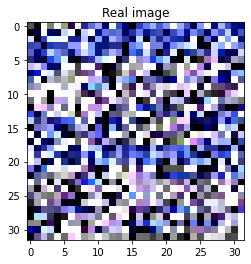

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


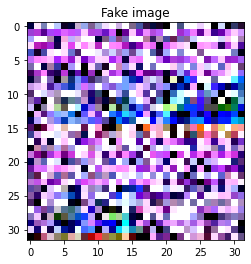

 20%|██        | 1/5 [00:00<00:00,  5.24it/s]

Epoch 541
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.30it/s]

Generator loss:  55.73539352416992
Discriminator loss:  1.7873246371746063
Epoch 542
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.14it/s]

Generator loss:  29.144174098968506
Discriminator loss:  1.7873246371746063
Epoch 543
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.06it/s]

Generator loss:  9.097444772720337
Discriminator loss:  1.7412009835243225
Epoch 544
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  5.264949917793274
Discriminator loss:  1.7412009835243225
Epoch 545
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  18.539061903953552
Discriminator loss:  1.7412009835243225
Epoch 546
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.05it/s]

Generator loss:  25.202755451202393
Discriminator loss:  1.6721384227275848
Epoch 547
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.21it/s]

Generator loss:  21.413840293884277
Discriminator loss:  1.6721384227275848
Epoch 548
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.03it/s]

Generator loss:  19.57799220085144
Discriminator loss:  1.6721384227275848
Epoch 549
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.25it/s]

Generator loss:  26.586249113082886
Discriminator loss:  1.6800588071346283
Epoch 550
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.15it/s]

Generator loss:  32.65448331832886
Discriminator loss:  1.6800588071346283
Epoch 551
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.17it/s]

Generator loss:  37.9352011680603
Discriminator loss:  1.6800588071346283
Epoch 552
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.14it/s]

Generator loss:  54.667699337005615
Discriminator loss:  1.7561015784740448
Epoch 553
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  68.38122081756592
Discriminator loss:  1.7561015784740448
Epoch 554
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  39.861799240112305
Discriminator loss:  1.7561015784740448
Epoch 555
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.11it/s]

Generator loss:  13.994890928268433
Discriminator loss:  1.6728533506393433
Epoch 556
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  5.028111577033997
Discriminator loss:  1.6728533506393433
Epoch 557
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  4.715589642524719
Discriminator loss:  1.6728533506393433
Epoch 558
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.28it/s]

Generator loss:  5.20668888092041
Discriminator loss:  1.6648192703723907
Epoch 559
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.40it/s]

Generator loss:  5.723478674888611
Discriminator loss:  1.6648192703723907
Epoch 560
Noise std:  0.5


100%|██████████| 5/5 [00:00<00:00,  5.14it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  6.210275650024414
Discriminator loss:  1.6648192703723907


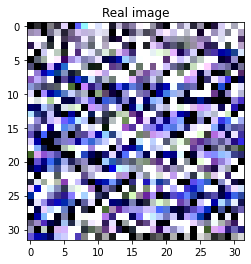

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


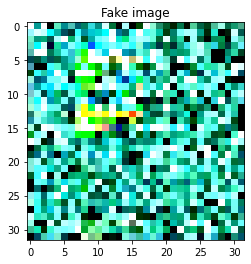

 20%|██        | 1/5 [00:00<00:00,  5.09it/s]

Epoch 561
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.08it/s]

Generator loss:  6.077949225902557
Discriminator loss:  1.6524052023887634
Epoch 562
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.32it/s]

Generator loss:  5.942238926887512
Discriminator loss:  1.6524052023887634
Epoch 563
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  5.67670464515686
Discriminator loss:  1.6524052023887634
Epoch 564
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.07it/s]

Generator loss:  5.468960464000702
Discriminator loss:  1.6510372459888458
Epoch 565
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.14it/s]

Generator loss:  5.182271420955658
Discriminator loss:  1.6510372459888458
Epoch 566
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.31it/s]

Generator loss:  4.990987479686737
Discriminator loss:  1.6510372459888458
Epoch 567
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  4.544878304004669
Discriminator loss:  1.641487181186676
Epoch 568
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  4.26058155298233
Discriminator loss:  1.641487181186676
Epoch 569
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.19it/s]

Generator loss:  3.99730384349823
Discriminator loss:  1.641487181186676
Epoch 570
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.21it/s]

Generator loss:  3.52166211605072
Discriminator loss:  1.6468745172023773
Epoch 571
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  3.7938737869262695
Discriminator loss:  1.6468745172023773
Epoch 572
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  3.222958981990814
Discriminator loss:  1.6468745172023773
Epoch 573
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  3.309587061405182
Discriminator loss:  1.6406458020210266
Epoch 574
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  2.932445466518402
Discriminator loss:  1.6406458020210266
Epoch 575
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  2.920682191848755
Discriminator loss:  1.6406458020210266
Epoch 576
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.21it/s]

Generator loss:  2.7227656543254852
Discriminator loss:  1.6467241048812866
Epoch 577
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.12it/s]

Generator loss:  2.5523601770401
Discriminator loss:  1.6467241048812866
Epoch 578
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  2.1121561229228973
Discriminator loss:  1.6467241048812866
Epoch 579
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.25it/s]

Generator loss:  2.0188508331775665
Discriminator loss:  1.6405668556690216
Epoch 580
Noise std:  0.5


100%|██████████| 5/5 [00:00<00:00,  5.03it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  1.3786134123802185
Discriminator loss:  1.6405668556690216


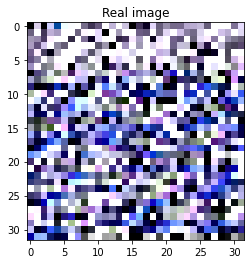

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


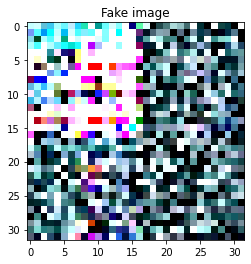

 20%|██        | 1/5 [00:00<00:00,  5.04it/s]

Epoch 581
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.35it/s]

Generator loss:  1.3053008317947388
Discriminator loss:  1.6405668556690216
Epoch 582
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.16it/s]

Generator loss:  1.1608296632766724
Discriminator loss:  1.6595014035701752
Epoch 583
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.996857151389122
Discriminator loss:  1.6595014035701752
Epoch 584
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.9432335197925568
Discriminator loss:  1.6595014035701752
Epoch 585
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.9018405079841614
Discriminator loss:  1.648529201745987
Epoch 586
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.28it/s]

Generator loss:  0.8924790173768997
Discriminator loss:  1.648529201745987
Epoch 587
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.8405772000551224
Discriminator loss:  1.648529201745987
Epoch 588
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.6785717457532883
Discriminator loss:  1.643407255411148
Epoch 589
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.05it/s]

Generator loss:  0.6408990994095802
Discriminator loss:  1.643407255411148
Epoch 590
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.00it/s]

Generator loss:  0.5913342088460922
Discriminator loss:  1.643407255411148
Epoch 591
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.11it/s]

Generator loss:  0.6028771549463272
Discriminator loss:  1.6446704268455505
Epoch 592
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.09it/s]

Generator loss:  0.5819952860474586
Discriminator loss:  1.6446704268455505
Epoch 593
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.11it/s]

Generator loss:  0.5624129548668861
Discriminator loss:  1.6446704268455505
Epoch 594
Noise std:  0.5


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.5143211483955383
Discriminator loss:  1.6447116136550903
Epoch 595
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.29it/s]

Generator loss:  0.47434739023447037
Discriminator loss:  1.6447116136550903
Epoch 596
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.18it/s]

Generator loss:  0.4331549108028412
Discriminator loss:  1.6447116136550903
Epoch 597
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.12it/s]

Generator loss:  0.5055555328726768
Discriminator loss:  1.6436768472194672
Epoch 598
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.15it/s]

Generator loss:  0.43396031111478806
Discriminator loss:  1.6436768472194672
Epoch 599
Noise std:  0.5


 20%|██        | 1/5 [00:00<00:00,  5.09it/s]

Generator loss:  0.3922536298632622
Discriminator loss:  1.6436768472194672
Epoch 600
Noise std:  0.5


100%|██████████| 5/5 [00:01<00:00,  4.93it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.40083932131528854
Discriminator loss:  1.6402150392532349


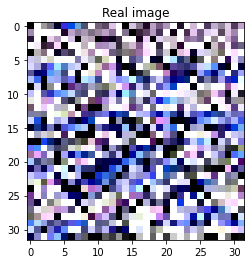

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


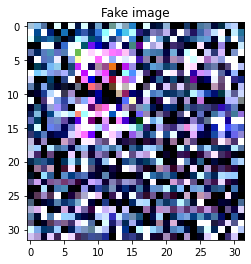

 20%|██        | 1/5 [00:00<00:00,  5.02it/s]

Epoch 601
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.16it/s]

Generator loss:  0.4010169878602028
Discriminator loss:  1.6402150392532349
Epoch 602
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.16it/s]

Generator loss:  0.331251073628664
Discriminator loss:  1.6402150392532349
Epoch 603
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.12it/s]

Generator loss:  0.3293297067284584
Discriminator loss:  1.649397224187851
Epoch 604
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.37it/s]

Generator loss:  0.43213125318288803
Discriminator loss:  1.649397224187851
Epoch 605
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.22it/s]

Generator loss:  0.3714846521615982
Discriminator loss:  1.649397224187851
Epoch 606
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.25it/s]

Generator loss:  0.3466357961297035
Discriminator loss:  1.6363370716571808
Epoch 607
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.3589450493454933
Discriminator loss:  1.6363370716571808
Epoch 608
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.36490393429994583
Discriminator loss:  1.6363370716571808
Epoch 609
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.05it/s]

Generator loss:  0.3094797879457474
Discriminator loss:  1.6429669260978699
Epoch 610
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.15it/s]

Generator loss:  0.3943434804677963
Discriminator loss:  1.6429669260978699
Epoch 611
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.39132773131132126
Discriminator loss:  1.6429669260978699
Epoch 612
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.34339918568730354
Discriminator loss:  1.6399126946926117
Epoch 613
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.38457926362752914
Discriminator loss:  1.6399126946926117
Epoch 614
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.28it/s]

Generator loss:  0.34841927886009216
Discriminator loss:  1.6399126946926117
Epoch 615
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.09it/s]

Generator loss:  0.34954455122351646
Discriminator loss:  1.6369989216327667
Epoch 616
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.3878495544195175
Discriminator loss:  1.6369989216327667
Epoch 617
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.15it/s]

Generator loss:  0.39363839477300644
Discriminator loss:  1.6369989216327667
Epoch 618
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.23it/s]

Generator loss:  0.38064051419496536
Discriminator loss:  1.6371270716190338
Epoch 619
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.07it/s]

Generator loss:  0.3813057020306587
Discriminator loss:  1.6371270716190338
Epoch 620
Noise std:  0.16666666666666666


100%|██████████| 5/5 [00:00<00:00,  5.03it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.38457638025283813
Discriminator loss:  1.6371270716190338


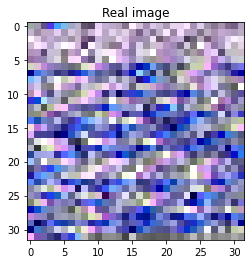

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


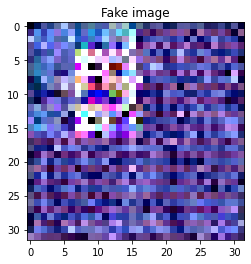

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 621
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.32it/s]

Generator loss:  0.3767554387450218
Discriminator loss:  1.641285240650177
Epoch 622
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.23it/s]

Generator loss:  0.4282056465744972
Discriminator loss:  1.641285240650177
Epoch 623
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.28it/s]

Generator loss:  0.40065933763980865
Discriminator loss:  1.641285240650177
Epoch 624
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.07it/s]

Generator loss:  0.45773930847644806
Discriminator loss:  1.6425439715385437
Epoch 625
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.5844671949744225
Discriminator loss:  1.6425439715385437
Epoch 626
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.16it/s]

Generator loss:  0.5224008932709694
Discriminator loss:  1.6425439715385437
Epoch 627
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.5622573345899582
Discriminator loss:  1.6366124153137207
Epoch 628
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.21it/s]

Generator loss:  0.6606550142168999
Discriminator loss:  1.6366124153137207
Epoch 629
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.7025373205542564
Discriminator loss:  1.6366124153137207
Epoch 630
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.30it/s]

Generator loss:  0.5806331858038902
Discriminator loss:  1.6409494578838348
Epoch 631
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.30it/s]

Generator loss:  0.6653754413127899
Discriminator loss:  1.6409494578838348
Epoch 632
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.6985668912529945
Discriminator loss:  1.6409494578838348
Epoch 633
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.39it/s]

Generator loss:  0.8823439925909042
Discriminator loss:  1.6423961520195007
Epoch 634
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.0071019977331161
Discriminator loss:  1.6423961520195007
Epoch 635
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.9024186730384827
Discriminator loss:  1.6423961520195007
Epoch 636
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.1501367092132568
Discriminator loss:  1.637669324874878
Epoch 637
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.20it/s]

Generator loss:  1.3812643587589264
Discriminator loss:  1.637669324874878
Epoch 638
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.23it/s]

Generator loss:  1.6312403827905655
Discriminator loss:  1.637669324874878
Epoch 639
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  2.016608953475952
Discriminator loss:  1.6409711241722107
Epoch 640
Noise std:  0.16666666666666666


100%|██████████| 5/5 [00:00<00:00,  5.01it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  1.4432485848665237
Discriminator loss:  1.6409711241722107


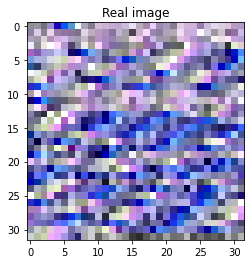

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


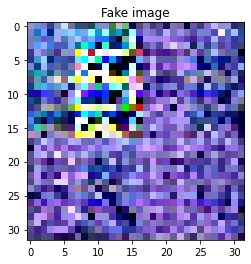

 20%|██        | 1/5 [00:00<00:00,  5.19it/s]

Epoch 641
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.0876805484294891
Discriminator loss:  1.6409711241722107
Epoch 642
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.34it/s]

Generator loss:  0.9987302720546722
Discriminator loss:  1.640218585729599
Epoch 643
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.20it/s]

Generator loss:  1.08891861140728
Discriminator loss:  1.640218585729599
Epoch 644
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.46898502856493
Discriminator loss:  1.640218585729599
Epoch 645
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.13it/s]

Generator loss:  3.1342683732509613
Discriminator loss:  1.646444171667099
Epoch 646
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  7.775683164596558
Discriminator loss:  1.646444171667099
Epoch 647
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.18it/s]

Generator loss:  11.767357409000397
Discriminator loss:  1.646444171667099
Epoch 648
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.24it/s]

Generator loss:  21.87102746963501
Discriminator loss:  1.6400096118450165
Epoch 649
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.17it/s]

Generator loss:  48.70343017578125
Discriminator loss:  1.6400096118450165
Epoch 650
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.31it/s]

Generator loss:  41.69801378250122
Discriminator loss:  1.6400096118450165
Epoch 651
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.30it/s]

Generator loss:  36.447357177734375
Discriminator loss:  1.657713234424591
Epoch 652
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  106.89793872833252
Discriminator loss:  1.657713234424591
Epoch 653
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.12it/s]

Generator loss:  63.756683349609375
Discriminator loss:  1.657713234424591
Epoch 654
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  74.32469081878662
Discriminator loss:  1.7142843902111053
Epoch 655
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.13it/s]

Generator loss:  65.07474422454834
Discriminator loss:  1.7142843902111053
Epoch 656
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  49.82768249511719
Discriminator loss:  1.7142843902111053
Epoch 657
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.24it/s]

Generator loss:  33.6298885345459
Discriminator loss:  1.6724894046783447
Epoch 658
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  11.033491015434265
Discriminator loss:  1.6724894046783447
Epoch 659
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.24it/s]

Generator loss:  1.0227915793657303
Discriminator loss:  1.6724894046783447
Epoch 660
Noise std:  0.16666666666666666


100%|██████████| 5/5 [00:00<00:00,  5.03it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  2.3138234615325928
Discriminator loss:  1.6629836857318878


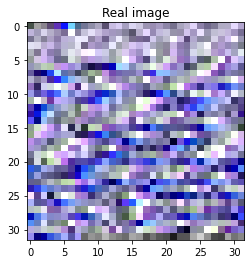

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


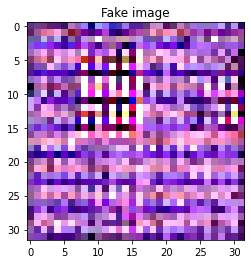

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 661
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  3.608060657978058
Discriminator loss:  1.6629836857318878
Epoch 662
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.23it/s]

Generator loss:  4.778937220573425
Discriminator loss:  1.6629836857318878
Epoch 663
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.07it/s]

Generator loss:  5.533767223358154
Discriminator loss:  1.659975677728653
Epoch 664
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.12it/s]

Generator loss:  30.07697105407715
Discriminator loss:  1.659975677728653
Epoch 665
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.14it/s]

Generator loss:  103.02331161499023
Discriminator loss:  1.659975677728653
Epoch 666
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.21it/s]

Generator loss:  85.47572612762451
Discriminator loss:  1.6917153298854828
Epoch 667
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.08it/s]

Generator loss:  13.053317666053772
Discriminator loss:  1.6917153298854828
Epoch 668
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.09it/s]

Generator loss:  3.4096993803977966
Discriminator loss:  1.6917153298854828
Epoch 669
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.25it/s]

Generator loss:  1.3182117491960526
Discriminator loss:  1.6400390267372131
Epoch 670
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.15it/s]

Generator loss:  1.5625966489315033
Discriminator loss:  1.6400390267372131
Epoch 671
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.884973794221878
Discriminator loss:  1.6400390267372131
Epoch 672
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.27it/s]

Generator loss:  1.1145281493663788
Discriminator loss:  1.6391986310482025
Epoch 673
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.37it/s]

Generator loss:  0.7486464306712151
Discriminator loss:  1.6391986310482025
Epoch 674
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.07it/s]

Generator loss:  0.7700991034507751
Discriminator loss:  1.6391986310482025
Epoch 675
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.15it/s]

Generator loss:  0.5998722091317177
Discriminator loss:  1.6379497647285461
Epoch 676
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.8549180775880814
Discriminator loss:  1.6379497647285461
Epoch 677
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.28it/s]

Generator loss:  0.7575841993093491
Discriminator loss:  1.6379497647285461
Epoch 678
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.28it/s]

Generator loss:  0.8815820217132568
Discriminator loss:  1.6394560039043427
Epoch 679
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.18it/s]

Generator loss:  0.9295919686555862
Discriminator loss:  1.6394560039043427
Epoch 680
Noise std:  0.16666666666666666


100%|██████████| 5/5 [00:00<00:00,  5.13it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  1.1256694793701172
Discriminator loss:  1.6394560039043427


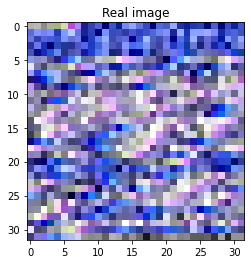

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


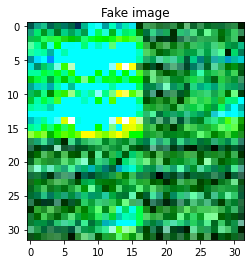

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 681
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.0070242583751678
Discriminator loss:  1.6362792551517487
Epoch 682
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.23it/s]

Generator loss:  1.0261531472206116
Discriminator loss:  1.6362792551517487
Epoch 683
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.10it/s]

Generator loss:  1.3917448073625565
Discriminator loss:  1.6362792551517487
Epoch 684
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.20it/s]

Generator loss:  0.9964304268360138
Discriminator loss:  1.6302731037139893
Epoch 685
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.0525697022676468
Discriminator loss:  1.6302731037139893
Epoch 686
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.20it/s]

Generator loss:  1.1832408607006073
Discriminator loss:  1.6302731037139893
Epoch 687
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.11it/s]

Generator loss:  1.3526756912469864
Discriminator loss:  1.6328392028808594
Epoch 688
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.15it/s]

Generator loss:  0.975833848118782
Discriminator loss:  1.6328392028808594
Epoch 689
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.31it/s]

Generator loss:  1.1075286120176315
Discriminator loss:  1.6328392028808594
Epoch 690
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.13it/s]

Generator loss:  1.2095727920532227
Discriminator loss:  1.6348788738250732
Epoch 691
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.14it/s]

Generator loss:  1.2659989893436432
Discriminator loss:  1.6348788738250732
Epoch 692
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.3632507771253586
Discriminator loss:  1.6348788738250732
Epoch 693
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.4157596677541733
Discriminator loss:  1.6324178278446198
Epoch 694
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.30it/s]

Generator loss:  1.4376541823148727
Discriminator loss:  1.6324178278446198
Epoch 695
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.03it/s]

Generator loss:  1.5228402614593506
Discriminator loss:  1.6324178278446198
Epoch 696
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.12it/s]

Generator loss:  1.5018219947814941
Discriminator loss:  1.6330540180206299
Epoch 697
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.17it/s]

Generator loss:  1.6252028346061707
Discriminator loss:  1.6330540180206299
Epoch 698
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.5880382359027863
Discriminator loss:  1.6330540180206299
Epoch 699
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.16it/s]

Generator loss:  1.8045856654644012
Discriminator loss:  1.632578730583191
Epoch 700
Noise std:  0.16666666666666666


100%|██████████| 5/5 [00:01<00:00,  4.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  1.5894884765148163
Discriminator loss:  1.632578730583191


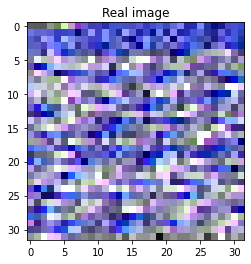

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


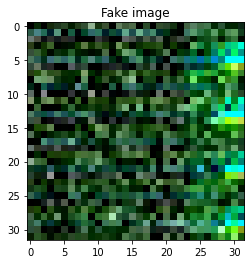

 20%|██        | 1/5 [00:00<00:00,  5.31it/s]

Epoch 701
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.13it/s]

Generator loss:  1.5439804792404175
Discriminator loss:  1.632578730583191
Epoch 702
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.18it/s]

Generator loss:  1.7233761847019196
Discriminator loss:  1.6339678466320038
Epoch 703
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.56014946103096
Discriminator loss:  1.6339678466320038
Epoch 704
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.21it/s]

Generator loss:  1.6833772957324982
Discriminator loss:  1.6339678466320038
Epoch 705
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.7229420840740204
Discriminator loss:  1.6319706737995148
Epoch 706
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.06it/s]

Generator loss:  1.8956412374973297
Discriminator loss:  1.6319706737995148
Epoch 707
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.09it/s]

Generator loss:  1.748476266860962
Discriminator loss:  1.6319706737995148
Epoch 708
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.7743854522705078
Discriminator loss:  1.6344779431819916
Epoch 709
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.17it/s]

Generator loss:  1.8717811703681946
Discriminator loss:  1.6344779431819916
Epoch 710
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.9059762060642242
Discriminator loss:  1.6344779431819916
Epoch 711
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.25it/s]

Generator loss:  1.72569140791893
Discriminator loss:  1.632652908563614
Epoch 712
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.8044691979885101
Discriminator loss:  1.632652908563614
Epoch 713
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.8288248777389526
Discriminator loss:  1.632652908563614
Epoch 714
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.35it/s]

Generator loss:  1.902972251176834
Discriminator loss:  1.6327179372310638
Epoch 715
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.9884275496006012
Discriminator loss:  1.6327179372310638
Epoch 716
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.12it/s]

Generator loss:  1.8183408975601196
Discriminator loss:  1.6327179372310638
Epoch 717
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.30it/s]

Generator loss:  1.8505328595638275
Discriminator loss:  1.6336962580680847
Epoch 718
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.43it/s]

Generator loss:  1.7123008370399475
Discriminator loss:  1.6336962580680847
Epoch 719
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.648518830537796
Discriminator loss:  1.6336962580680847
Epoch 720
Noise std:  0.16666666666666666


100%|██████████| 5/5 [00:01<00:00,  4.92it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  1.6430561542510986
Discriminator loss:  1.6322557032108307


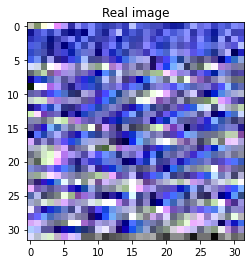

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


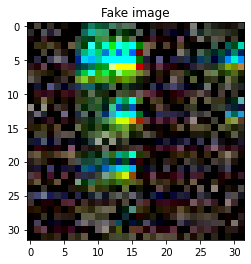

 20%|██        | 1/5 [00:00<00:00,  5.15it/s]

Epoch 721
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.32it/s]

Generator loss:  1.4775179028511047
Discriminator loss:  1.6322557032108307
Epoch 722
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.21it/s]

Generator loss:  1.4776530265808105
Discriminator loss:  1.6322557032108307
Epoch 723
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.14it/s]

Generator loss:  1.4228655099868774
Discriminator loss:  1.6378730535507202
Epoch 724
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.4208598136901855
Discriminator loss:  1.6378730535507202
Epoch 725
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.16it/s]

Generator loss:  1.4166849851608276
Discriminator loss:  1.6378730535507202
Epoch 726
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.06it/s]

Generator loss:  1.3038375228643417
Discriminator loss:  1.629997730255127
Epoch 727
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.12it/s]

Generator loss:  1.2226229459047318
Discriminator loss:  1.629997730255127
Epoch 728
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.22it/s]

Generator loss:  1.2048984467983246
Discriminator loss:  1.629997730255127
Epoch 729
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.1224699020385742
Discriminator loss:  1.6297558844089508
Epoch 730
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.03325617313385
Discriminator loss:  1.6297558844089508
Epoch 731
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.19it/s]

Generator loss:  1.1068808734416962
Discriminator loss:  1.6297558844089508
Epoch 732
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.23it/s]

Generator loss:  1.004197120666504
Discriminator loss:  1.630679428577423
Epoch 733
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.9848872870206833
Discriminator loss:  1.630679428577423
Epoch 734
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.12it/s]

Generator loss:  0.9062066674232483
Discriminator loss:  1.630679428577423
Epoch 735
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.8869707435369492
Discriminator loss:  1.6318800151348114
Epoch 736
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.07it/s]

Generator loss:  0.8037693947553635
Discriminator loss:  1.6318800151348114
Epoch 737
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.27it/s]

Generator loss:  0.843778058886528
Discriminator loss:  1.6318800151348114
Epoch 738
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.12it/s]

Generator loss:  0.7324109822511673
Discriminator loss:  1.6302185654640198
Epoch 739
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.7772796154022217
Discriminator loss:  1.6302185654640198
Epoch 740
Noise std:  0.16666666666666666


100%|██████████| 5/5 [00:01<00:00,  4.98it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.739452600479126
Discriminator loss:  1.6302185654640198


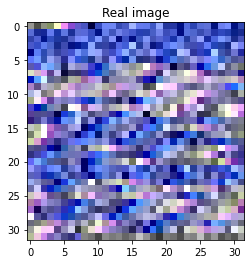

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


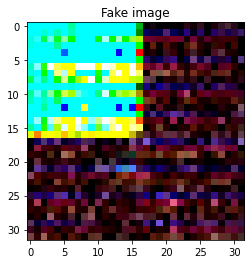

 20%|██        | 1/5 [00:00<00:00,  5.21it/s]

Epoch 741
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.41it/s]

Generator loss:  0.6293162778019905
Discriminator loss:  1.632171243429184
Epoch 742
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.09it/s]

Generator loss:  0.6456293538212776
Discriminator loss:  1.632171243429184
Epoch 743
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.6472429931163788
Discriminator loss:  1.632171243429184
Epoch 744
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.6830014660954475
Discriminator loss:  1.6301043927669525
Epoch 745
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.5824267938733101
Discriminator loss:  1.6301043927669525
Epoch 746
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.22it/s]

Generator loss:  0.6529380306601524
Discriminator loss:  1.6301043927669525
Epoch 747
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.25it/s]

Generator loss:  0.6157169714570045
Discriminator loss:  1.6324429214000702
Epoch 748
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.42it/s]

Generator loss:  0.5933531075716019
Discriminator loss:  1.6324429214000702
Epoch 749
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.31it/s]

Generator loss:  0.5994421690702438
Discriminator loss:  1.6324429214000702
Epoch 750
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.5545931085944176
Discriminator loss:  1.6318407356739044
Epoch 751
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.07it/s]

Generator loss:  0.5704341977834702
Discriminator loss:  1.6318407356739044
Epoch 752
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.03it/s]

Generator loss:  0.5570422559976578
Discriminator loss:  1.6318407356739044
Epoch 753
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.30it/s]

Generator loss:  0.5333016738295555
Discriminator loss:  1.6309515833854675
Epoch 754
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.17it/s]

Generator loss:  0.5474214404821396
Discriminator loss:  1.6309515833854675
Epoch 755
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.563558541238308
Discriminator loss:  1.6309515833854675
Epoch 756
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.6006612405180931
Discriminator loss:  1.63290736079216
Epoch 757
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.5608619451522827
Discriminator loss:  1.63290736079216
Epoch 758
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.10it/s]

Generator loss:  0.5253673195838928
Discriminator loss:  1.63290736079216
Epoch 759
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.33it/s]

Generator loss:  0.5760526210069656
Discriminator loss:  1.6304289996623993
Epoch 760
Noise std:  0.16666666666666666


100%|██████████| 5/5 [00:00<00:00,  5.10it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.6260451003909111
Discriminator loss:  1.6304289996623993


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


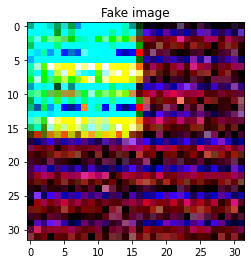

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 761
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.09it/s]

Generator loss:  0.5900758802890778
Discriminator loss:  1.6304289996623993
Epoch 762
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.5745538249611855
Discriminator loss:  1.6357395648956299
Epoch 763
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.19it/s]

Generator loss:  0.5703999623656273
Discriminator loss:  1.6357395648956299
Epoch 764
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.5983447507023811
Discriminator loss:  1.6357395648956299
Epoch 765
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.6208484992384911
Discriminator loss:  1.632017731666565
Epoch 766
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.6535481661558151
Discriminator loss:  1.632017731666565
Epoch 767
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.6948020756244659
Discriminator loss:  1.632017731666565
Epoch 768
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.07it/s]

Generator loss:  0.6744464561343193
Discriminator loss:  1.6300207376480103
Epoch 769
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.09it/s]

Generator loss:  0.6298110336065292
Discriminator loss:  1.6300207376480103
Epoch 770
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.06it/s]

Generator loss:  0.7060984969139099
Discriminator loss:  1.6300207376480103
Epoch 771
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.06it/s]

Generator loss:  0.7127157151699066
Discriminator loss:  1.6316962540149689
Epoch 772
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.32it/s]

Generator loss:  0.7196799963712692
Discriminator loss:  1.6316962540149689
Epoch 773
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.8176330775022507
Discriminator loss:  1.6316962540149689
Epoch 774
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.8457923233509064
Discriminator loss:  1.6342856585979462
Epoch 775
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.21it/s]

Generator loss:  0.8953913599252701
Discriminator loss:  1.6342856585979462
Epoch 776
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.8753504157066345
Discriminator loss:  1.6342856585979462
Epoch 777
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.8945191502571106
Discriminator loss:  1.6323200464248657
Epoch 778
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.27it/s]

Generator loss:  0.9292201995849609
Discriminator loss:  1.6323200464248657
Epoch 779
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.14it/s]

Generator loss:  0.9529750645160675
Discriminator loss:  1.6323200464248657
Epoch 780
Noise std:  0.16666666666666666


100%|██████████| 5/5 [00:00<00:00,  5.10it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.9416770040988922
Discriminator loss:  1.6303750574588776


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 20%|██        | 1/5 [00:00<00:00,  5.11it/s]

Epoch 781
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.10it/s]

Generator loss:  0.9786817133426666
Discriminator loss:  1.6303750574588776
Epoch 782
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.0415894538164139
Discriminator loss:  1.6303750574588776
Epoch 783
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.1129881590604782
Discriminator loss:  1.6329522728919983
Epoch 784
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.0969460010528564
Discriminator loss:  1.6329522728919983
Epoch 785
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.28it/s]

Generator loss:  1.1002051383256912
Discriminator loss:  1.6329522728919983
Epoch 786
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.1358080208301544
Discriminator loss:  1.630896508693695
Epoch 787
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.163733035326004
Discriminator loss:  1.630896508693695
Epoch 788
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.1764461547136307
Discriminator loss:  1.630896508693695
Epoch 789
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.30it/s]

Generator loss:  1.097394421696663
Discriminator loss:  1.6336120665073395
Epoch 790
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.15it/s]

Generator loss:  1.2242763042449951
Discriminator loss:  1.6336120665073395
Epoch 791
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.16973315179348
Discriminator loss:  1.6336120665073395
Epoch 792
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.12it/s]

Generator loss:  1.1505451500415802
Discriminator loss:  1.6316660642623901
Epoch 793
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.28it/s]

Generator loss:  1.2151824831962585
Discriminator loss:  1.6316660642623901
Epoch 794
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.1161915808916092
Discriminator loss:  1.6316660642623901
Epoch 795
Noise std:  0.16666666666666666


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.126316174864769
Discriminator loss:  1.6307351887226105
Epoch 796
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.11it/s]

Generator loss:  1.2085529267787933
Discriminator loss:  1.6307351887226105
Epoch 797
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.31it/s]

Generator loss:  1.2383515387773514
Discriminator loss:  1.6307351887226105
Epoch 798
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.08it/s]

Generator loss:  1.20303775370121
Discriminator loss:  1.6336642801761627
Epoch 799
Noise std:  0.16666666666666666


 20%|██        | 1/5 [00:00<00:00,  5.13it/s]

Generator loss:  1.23614102602005
Discriminator loss:  1.6336642801761627
Epoch 800
Noise std:  0.16666666666666666


100%|██████████| 5/5 [00:00<00:00,  5.11it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  1.1634427458047867
Discriminator loss:  1.6336642801761627


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


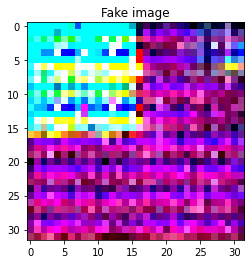

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 801
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.25it/s]

Generator loss:  1.2141863405704498
Discriminator loss:  1.629706084728241
Epoch 802
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.33it/s]

Generator loss:  1.1223807632923126
Discriminator loss:  1.629706084728241
Epoch 803
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.15it/s]

Generator loss:  1.0799586772918701
Discriminator loss:  1.629706084728241
Epoch 804
Noise std:  0.1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.0503730475902557
Discriminator loss:  1.6292005479335785
Epoch 805
Noise std:  0.1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.0498497188091278
Discriminator loss:  1.6292005479335785
Epoch 806
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.23it/s]

Generator loss:  0.9455891102552414
Discriminator loss:  1.6292005479335785
Epoch 807
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.12it/s]

Generator loss:  1.049348533153534
Discriminator loss:  1.6338236331939697
Epoch 808
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.02it/s]

Generator loss:  0.9538084268569946
Discriminator loss:  1.6338236331939697
Epoch 809
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.30it/s]

Generator loss:  0.9594119191169739
Discriminator loss:  1.6338236331939697
Epoch 810
Noise std:  0.1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.962907075881958
Discriminator loss:  1.6301925480365753
Epoch 811
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.17it/s]

Generator loss:  0.8754068911075592
Discriminator loss:  1.6301925480365753
Epoch 812
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.27it/s]

Generator loss:  0.827804759144783
Discriminator loss:  1.6301925480365753
Epoch 813
Noise std:  0.1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.8499056249856949
Discriminator loss:  1.6300795674324036
Epoch 814
Noise std:  0.1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.8927003294229507
Discriminator loss:  1.6300795674324036
Epoch 815
Noise std:  0.1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.8303236067295074
Discriminator loss:  1.6300795674324036
Epoch 816
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.16it/s]

Generator loss:  0.77459716796875
Discriminator loss:  1.6300508677959442
Epoch 817
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.23it/s]

Generator loss:  0.741861030459404
Discriminator loss:  1.6300508677959442
Epoch 818
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.05it/s]

Generator loss:  0.7960322499275208
Discriminator loss:  1.6300508677959442
Epoch 819
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.20it/s]

Generator loss:  0.8010131567716599
Discriminator loss:  1.6323605179786682
Epoch 820
Noise std:  0.1


100%|██████████| 5/5 [00:00<00:00,  5.19it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.8124839067459106
Discriminator loss:  1.6323605179786682


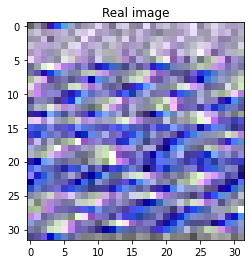

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 821
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.20it/s]

Generator loss:  0.7379410564899445
Discriminator loss:  1.6323605179786682
Epoch 822
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.30it/s]

Generator loss:  0.700766921043396
Discriminator loss:  1.6310609877109528
Epoch 823
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.11it/s]

Generator loss:  0.7515523731708527
Discriminator loss:  1.6310609877109528
Epoch 824
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.03it/s]

Generator loss:  0.7399568855762482
Discriminator loss:  1.6310609877109528
Epoch 825
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.17it/s]

Generator loss:  0.6207912489771843
Discriminator loss:  1.6314569413661957
Epoch 826
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.10it/s]

Generator loss:  0.6146155893802643
Discriminator loss:  1.6314569413661957
Epoch 827
Noise std:  0.1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.6674870923161507
Discriminator loss:  1.6314569413661957
Epoch 828
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.12it/s]

Generator loss:  0.5630295351147652
Discriminator loss:  1.6313452124595642
Epoch 829
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.39it/s]

Generator loss:  0.5472081080079079
Discriminator loss:  1.6313452124595642
Epoch 830
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.18it/s]

Generator loss:  0.31367821618914604
Discriminator loss:  1.6313452124595642
Epoch 831
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.16it/s]

Generator loss:  0.47753220796585083
Discriminator loss:  1.6590507924556732
Epoch 832
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.11it/s]

Generator loss:  0.7097413539886475
Discriminator loss:  1.6590507924556732
Epoch 833
Noise std:  0.1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.7332452535629272
Discriminator loss:  1.6590507924556732
Epoch 834
Noise std:  0.1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.4918936863541603
Discriminator loss:  1.6355839371681213
Epoch 835
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.18it/s]

Generator loss:  0.46669504791498184
Discriminator loss:  1.6355839371681213
Epoch 836
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.21it/s]

Generator loss:  0.5232415050268173
Discriminator loss:  1.6355839371681213
Epoch 837
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.34it/s]

Generator loss:  0.39242570102214813
Discriminator loss:  1.6319245994091034
Epoch 838
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.29it/s]

Generator loss:  0.4310963824391365
Discriminator loss:  1.6319245994091034
Epoch 839
Noise std:  0.1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.3920113071799278
Discriminator loss:  1.6319245994091034
Epoch 840
Noise std:  0.1


100%|██████████| 5/5 [00:00<00:00,  5.08it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.33460957184433937
Discriminator loss:  1.6348830163478851


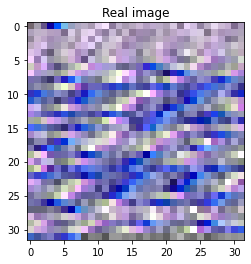

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 20%|██        | 1/5 [00:00<00:00,  5.33it/s]

Epoch 841
Noise std:  0.1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.4819631800055504
Discriminator loss:  1.6348830163478851
Epoch 842
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.12it/s]

Generator loss:  0.16578595899045467
Discriminator loss:  1.6348830163478851
Epoch 843
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.21it/s]

Generator loss:  0.10637521184980869
Discriminator loss:  1.6353113651275635
Epoch 844
Noise std:  0.1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.15463371761143208
Discriminator loss:  1.6353113651275635
Epoch 845
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.42it/s]

Generator loss:  0.21890950575470924
Discriminator loss:  1.6353113651275635
Epoch 846
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.13it/s]

Generator loss:  0.233313899487257
Discriminator loss:  1.6438382863998413
Epoch 847
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.09it/s]

Generator loss:  0.25462324544787407
Discriminator loss:  1.6438382863998413
Epoch 848
Noise std:  0.1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.27989062294363976
Discriminator loss:  1.6438382863998413
Epoch 849
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.11it/s]

Generator loss:  0.266630370169878
Discriminator loss:  1.6363647282123566
Epoch 850
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.22it/s]

Generator loss:  0.3915712460875511
Discriminator loss:  1.6363647282123566
Epoch 851
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.27it/s]

Generator loss:  0.4135606735944748
Discriminator loss:  1.6363647282123566
Epoch 852
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.18it/s]

Generator loss:  0.6923034712672234
Discriminator loss:  1.6342222094535828
Epoch 853
Noise std:  0.1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.9197880178689957
Discriminator loss:  1.6342222094535828
Epoch 854
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.39it/s]

Generator loss:  1.0914464741945267
Discriminator loss:  1.6342222094535828
Epoch 855
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.16it/s]

Generator loss:  1.0646441578865051
Discriminator loss:  1.6356588900089264
Epoch 856
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.29it/s]

Generator loss:  2.75377456843853
Discriminator loss:  1.6356588900089264
Epoch 857
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.09it/s]

Generator loss:  4.068878889083862
Discriminator loss:  1.6356588900089264
Epoch 858
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.16it/s]

Generator loss:  14.48360002040863
Discriminator loss:  1.6588758528232574
Epoch 859
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.30it/s]

Generator loss:  32.1955680847168
Discriminator loss:  1.6588758528232574
Epoch 860
Noise std:  0.1


100%|██████████| 5/5 [00:00<00:00,  5.09it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  36.061155796051025
Discriminator loss:  1.6588758528232574


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


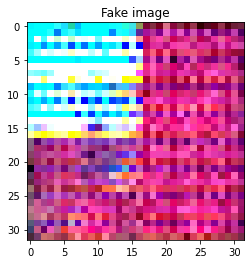

 20%|██        | 1/5 [00:00<00:00,  5.16it/s]

Epoch 861
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.27it/s]

Generator loss:  31.803491592407227
Discriminator loss:  1.6734849512577057
Epoch 862
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.15it/s]

Generator loss:  22.56803250312805
Discriminator loss:  1.6734849512577057
Epoch 863
Noise std:  0.1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  5.953693509101868
Discriminator loss:  1.6734849512577057
Epoch 864
Noise std:  0.1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  5.603952348232269
Discriminator loss:  1.634815126657486
Epoch 865
Noise std:  0.1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  5.95922178030014
Discriminator loss:  1.634815126657486
Epoch 866
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.04it/s]

Generator loss:  3.7826165556907654
Discriminator loss:  1.634815126657486
Epoch 867
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.10it/s]

Generator loss:  3.2437161803245544
Discriminator loss:  1.6399000883102417
Epoch 868
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.06it/s]

Generator loss:  5.533501505851746
Discriminator loss:  1.6399000883102417
Epoch 869
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.06it/s]

Generator loss:  3.947135031223297
Discriminator loss:  1.6399000883102417
Epoch 870
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.09it/s]

Generator loss:  4.321212828159332
Discriminator loss:  1.647182434797287
Epoch 871
Noise std:  0.1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  4.445143043994904
Discriminator loss:  1.647182434797287
Epoch 872
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.11it/s]

Generator loss:  4.243732929229736
Discriminator loss:  1.647182434797287
Epoch 873
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.14it/s]

Generator loss:  4.707373142242432
Discriminator loss:  1.6375223994255066
Epoch 874
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.20it/s]

Generator loss:  4.9666202664375305
Discriminator loss:  1.6375223994255066
Epoch 875
Noise std:  0.1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  4.1973037123680115
Discriminator loss:  1.6375223994255066
Epoch 876
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.14it/s]

Generator loss:  4.88363653421402
Discriminator loss:  1.6348018050193787
Epoch 877
Noise std:  0.1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  3.906540811061859
Discriminator loss:  1.6348018050193787
Epoch 878
Noise std:  0.1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  3.5449000000953674
Discriminator loss:  1.6348018050193787
Epoch 879
Noise std:  0.1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  3.9688934683799744
Discriminator loss:  1.635947197675705
Epoch 880
Noise std:  0.1


100%|██████████| 5/5 [00:01<00:00,  4.89it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  3.280393123626709
Discriminator loss:  1.635947197675705


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


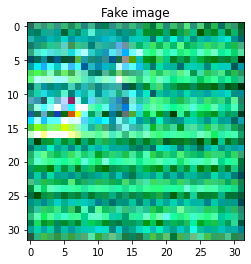

 20%|██        | 1/5 [00:00<00:00,  5.07it/s]

Epoch 881
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.20it/s]

Generator loss:  3.395558476448059
Discriminator loss:  1.635947197675705
Epoch 882
Noise std:  0.1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  3.756050944328308
Discriminator loss:  1.632315844297409
Epoch 883
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.16it/s]

Generator loss:  3.3406107425689697
Discriminator loss:  1.632315844297409
Epoch 884
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.05it/s]

Generator loss:  3.32066148519516
Discriminator loss:  1.632315844297409
Epoch 885
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.23it/s]

Generator loss:  2.974096119403839
Discriminator loss:  1.6309365630149841
Epoch 886
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.17it/s]

Generator loss:  2.945948302745819
Discriminator loss:  1.6309365630149841
Epoch 887
Noise std:  0.1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  2.614049792289734
Discriminator loss:  1.6309365630149841
Epoch 888
Noise std:  0.1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.8947827219963074
Discriminator loss:  1.6345398426055908
Epoch 889
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.29it/s]

Generator loss:  1.4429342448711395
Discriminator loss:  1.6345398426055908
Epoch 890
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.22it/s]

Generator loss:  1.0869488418102264
Discriminator loss:  1.6345398426055908
Epoch 891
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.17it/s]

Generator loss:  1.0466023534536362
Discriminator loss:  1.6364600658416748
Epoch 892
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.08it/s]

Generator loss:  1.0417651534080505
Discriminator loss:  1.6364600658416748
Epoch 893
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.23it/s]

Generator loss:  1.0725323408842087
Discriminator loss:  1.6364600658416748
Epoch 894
Noise std:  0.1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.9922043234109879
Discriminator loss:  1.6309707164764404
Epoch 895
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.25it/s]

Generator loss:  0.9336095899343491
Discriminator loss:  1.6309707164764404
Epoch 896
Noise std:  0.1


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.9798680394887924
Discriminator loss:  1.6309707164764404
Epoch 897
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.25it/s]

Generator loss:  0.9274908602237701
Discriminator loss:  1.632516771554947
Epoch 898
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.24it/s]

Generator loss:  0.8967341333627701
Discriminator loss:  1.632516771554947
Epoch 899
Noise std:  0.1


 20%|██        | 1/5 [00:00<00:00,  5.14it/s]

Generator loss:  0.9090537577867508
Discriminator loss:  1.632516771554947
Epoch 900
Noise std:  0.1


100%|██████████| 5/5 [00:00<00:00,  5.12it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss:  0.9033745229244232
Discriminator loss:  1.6334201395511627


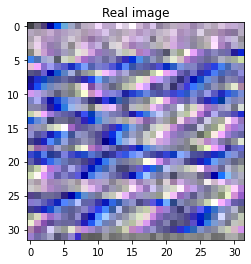

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


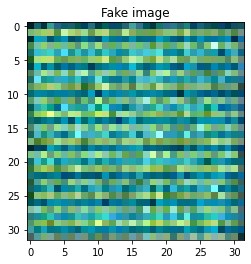

 20%|██        | 1/5 [00:00<00:00,  5.23it/s]

Epoch 901
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.16it/s]

Generator loss:  0.8983423858880997
Discriminator loss:  1.6334201395511627
Epoch 902
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.17it/s]

Generator loss:  0.7981481105089188
Discriminator loss:  1.6334201395511627
Epoch 903
Noise std:  0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.8572293668985367
Discriminator loss:  1.6295467019081116
Epoch 904
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.28it/s]

Generator loss:  0.8352393209934235
Discriminator loss:  1.6295467019081116
Epoch 905
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.21it/s]

Generator loss:  0.8114618360996246
Discriminator loss:  1.6295467019081116
Epoch 906
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.14it/s]

Generator loss:  0.7956158816814423
Discriminator loss:  1.6317421793937683
Epoch 907
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.22it/s]

Generator loss:  0.8121139109134674
Discriminator loss:  1.6317421793937683
Epoch 908
Noise std:  0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.7965849786996841
Discriminator loss:  1.6317421793937683
Epoch 909
Noise std:  0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.7962444126605988
Discriminator loss:  1.6298302114009857
Epoch 910
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.18it/s]

Generator loss:  0.7560184299945831
Discriminator loss:  1.6298302114009857
Epoch 911
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.24it/s]

Generator loss:  0.7731507271528244
Discriminator loss:  1.6298302114009857
Epoch 912
Noise std:  0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.7575188428163528
Discriminator loss:  1.6318626403808594
Epoch 913
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.23it/s]

Generator loss:  0.7528318464756012
Discriminator loss:  1.6318626403808594
Epoch 914
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.10it/s]

Generator loss:  0.7337866872549057
Discriminator loss:  1.6318626403808594
Epoch 915
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.22it/s]

Generator loss:  0.7593013644218445
Discriminator loss:  1.6310523748397827
Epoch 916
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.11it/s]

Generator loss:  0.739871934056282
Discriminator loss:  1.6310523748397827
Epoch 917
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.12it/s]

Generator loss:  0.776152491569519
Discriminator loss:  1.6310523748397827
Epoch 918
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.21it/s]

Generator loss:  0.7098682820796967
Discriminator loss:  1.6293815970420837
Epoch 919
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.19it/s]

Generator loss:  0.6855671405792236
Discriminator loss:  1.6293815970420837
Epoch 920
Noise std:  0


100%|██████████| 5/5 [00:01<00:00,  4.96it/s]


Generator loss:  0.6870418563485146
Discriminator loss:  1.6293815970420837


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 20%|██        | 1/5 [00:00<00:00,  5.11it/s]

Epoch 921
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.21it/s]

Generator loss:  0.659015879034996
Discriminator loss:  1.6318256855010986
Epoch 922
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.06it/s]

Generator loss:  0.6747686937451363
Discriminator loss:  1.6318256855010986
Epoch 923
Noise std:  0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.6731661409139633
Discriminator loss:  1.6318256855010986
Epoch 924
Noise std:  0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.7094491571187973
Discriminator loss:  1.6319147646427155
Epoch 925
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.23it/s]

Generator loss:  0.6693330928683281
Discriminator loss:  1.6319147646427155
Epoch 926
Noise std:  0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.6349902004003525
Discriminator loss:  1.6319147646427155
Epoch 927
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.31it/s]

Generator loss:  0.5920682847499847
Discriminator loss:  1.6304408013820648
Epoch 928
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.13it/s]

Generator loss:  0.5766500532627106
Discriminator loss:  1.6304408013820648
Epoch 929
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.11it/s]

Generator loss:  0.5196269601583481
Discriminator loss:  1.6304408013820648
Epoch 930
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.18it/s]

Generator loss:  0.544815756380558
Discriminator loss:  1.6352534294128418
Epoch 931
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.04it/s]

Generator loss:  0.5278791710734367
Discriminator loss:  1.6352534294128418
Epoch 932
Noise std:  0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.4496111422777176
Discriminator loss:  1.6352534294128418
Epoch 933
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.06it/s]

Generator loss:  0.5275134369730949
Discriminator loss:  1.6314571499824524
Epoch 934
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.17it/s]

Generator loss:  0.4505206570029259
Discriminator loss:  1.6314571499824524
Epoch 935
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.17it/s]

Generator loss:  0.521170437335968
Discriminator loss:  1.6314571499824524
Epoch 936
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.34it/s]

Generator loss:  0.4204436168074608
Discriminator loss:  1.6324093043804169
Epoch 937
Noise std:  0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.5080008208751678
Discriminator loss:  1.6324093043804169
Epoch 938
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.15it/s]

Generator loss:  0.43857018649578094
Discriminator loss:  1.6324093043804169
Epoch 939
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.22it/s]

Generator loss:  0.4667780175805092
Discriminator loss:  1.6333076357841492
Epoch 940
Noise std:  0


100%|██████████| 5/5 [00:00<00:00,  5.12it/s]


Generator loss:  0.4890352115035057
Discriminator loss:  1.6333076357841492


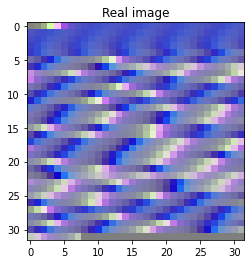

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


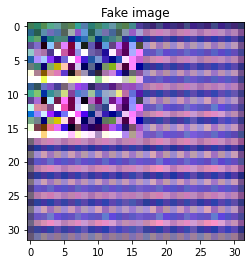

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 941
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.08it/s]

Generator loss:  0.49126916378736496
Discriminator loss:  1.6333076357841492
Epoch 942
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.30it/s]

Generator loss:  0.5682596042752266
Discriminator loss:  1.63314750790596
Epoch 943
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.12it/s]

Generator loss:  0.4966781511902809
Discriminator loss:  1.63314750790596
Epoch 944
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.12it/s]

Generator loss:  0.5989696234464645
Discriminator loss:  1.63314750790596
Epoch 945
Noise std:  0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.6372462064027786
Discriminator loss:  1.6313632130622864
Epoch 946
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.07it/s]

Generator loss:  0.5914558619260788
Discriminator loss:  1.6313632130622864
Epoch 947
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.17it/s]

Generator loss:  0.7009615525603294
Discriminator loss:  1.6313632130622864
Epoch 948
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.05it/s]

Generator loss:  0.6664575710892677
Discriminator loss:  1.635120928287506
Epoch 949
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.17it/s]

Generator loss:  0.6914910078048706
Discriminator loss:  1.635120928287506
Epoch 950
Noise std:  0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  0.8669504076242447
Discriminator loss:  1.635120928287506
Epoch 951
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.12it/s]

Generator loss:  0.9428321570158005
Discriminator loss:  1.6328884661197662
Epoch 952
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.20it/s]

Generator loss:  0.9191701114177704
Discriminator loss:  1.6328884661197662
Epoch 953
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.27it/s]

Generator loss:  1.1490375101566315
Discriminator loss:  1.6328884661197662
Epoch 954
Noise std:  0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  1.3903513550758362
Discriminator loss:  1.6335409879684448
Epoch 955
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.19it/s]

Generator loss:  11.158285856246948
Discriminator loss:  1.6335409879684448
Epoch 956
Noise std:  0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  9.687105119228363
Discriminator loss:  1.6335409879684448
Epoch 957
Noise std:  0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  8.863272666931152
Discriminator loss:  1.6479619145393372
Epoch 958
Noise std:  0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  8.982512474060059
Discriminator loss:  1.6479619145393372
Epoch 959
Noise std:  0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  22.061257362365723
Discriminator loss:  1.6479619145393372
Epoch 960
Noise std:  0


100%|██████████| 5/5 [00:00<00:00,  5.05it/s]


Generator loss:  32.9177885055542
Discriminator loss:  1.646641194820404


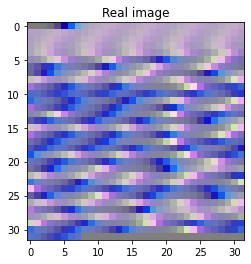

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


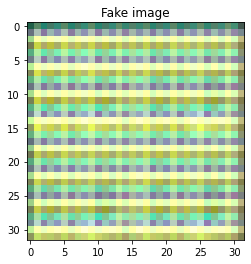

 20%|██        | 1/5 [00:00<00:00,  5.07it/s]

Epoch 961
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.01it/s]

Generator loss:  16.740269660949707
Discriminator loss:  1.646641194820404
Epoch 962
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.20it/s]

Generator loss:  14.660703182220459
Discriminator loss:  1.646641194820404
Epoch 963
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.03it/s]

Generator loss:  10.680923223495483
Discriminator loss:  1.6362650096416473
Epoch 964
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.08it/s]

Generator loss:  11.49089241027832
Discriminator loss:  1.6362650096416473
Epoch 965
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.08it/s]

Generator loss:  9.163427829742432
Discriminator loss:  1.6362650096416473
Epoch 966
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.07it/s]

Generator loss:  7.201431751251221
Discriminator loss:  1.6414922177791595
Epoch 967
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.06it/s]

Generator loss:  4.107899487018585
Discriminator loss:  1.6414922177791595
Epoch 968
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.15it/s]

Generator loss:  4.047717034816742
Discriminator loss:  1.6414922177791595
Epoch 969
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.15it/s]

Generator loss:  4.930999338626862
Discriminator loss:  1.6341421902179718
Epoch 970
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.25it/s]

Generator loss:  5.525318026542664
Discriminator loss:  1.6341421902179718
Epoch 971
Noise std:  0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  4.472224056720734
Discriminator loss:  1.6341421902179718
Epoch 972
Noise std:  0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  3.6379454135894775
Discriminator loss:  1.6367306113243103
Epoch 973
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.10it/s]

Generator loss:  3.429100513458252
Discriminator loss:  1.6367306113243103
Epoch 974
Noise std:  0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  3.315291941165924
Discriminator loss:  1.6367306113243103
Epoch 975
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.34it/s]

Generator loss:  3.025919586420059
Discriminator loss:  1.6316028535366058
Epoch 976
Noise std:  0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  3.724363923072815
Discriminator loss:  1.6316028535366058
Epoch 977
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.15it/s]

Generator loss:  3.3939929008483887
Discriminator loss:  1.6316028535366058
Epoch 978
Noise std:  0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  4.067774772644043
Discriminator loss:  1.6297159790992737
Epoch 979
Noise std:  0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  5.267689049243927
Discriminator loss:  1.6297159790992737
Epoch 980
Noise std:  0


100%|██████████| 5/5 [00:00<00:00,  5.16it/s]


Generator loss:  9.35729694366455
Discriminator loss:  1.6297159790992737


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 981
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.31it/s]

Generator loss:  12.089495182037354
Discriminator loss:  1.6330843567848206
Epoch 982
Noise std:  0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  8.094465255737305
Discriminator loss:  1.6330843567848206
Epoch 983
Noise std:  0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  5.62834370136261
Discriminator loss:  1.6330843567848206
Epoch 984
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.25it/s]

Generator loss:  4.527405858039856
Discriminator loss:  1.6345851421356201
Epoch 985
Noise std:  0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  4.197030305862427
Discriminator loss:  1.6345851421356201
Epoch 986
Noise std:  0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  3.7974554300308228
Discriminator loss:  1.6345851421356201
Epoch 987
Noise std:  0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  3.233713388442993
Discriminator loss:  1.630296140909195
Epoch 988
Noise std:  0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  3.3378092646598816
Discriminator loss:  1.630296140909195
Epoch 989
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.33it/s]

Generator loss:  2.8205097317695618
Discriminator loss:  1.630296140909195
Epoch 990
Noise std:  0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  2.2738558053970337
Discriminator loss:  1.630536288022995
Epoch 991
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.22it/s]

Generator loss:  2.1316435635089874
Discriminator loss:  1.630536288022995
Epoch 992
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.15it/s]

Generator loss:  2.1210120916366577
Discriminator loss:  1.630536288022995
Epoch 993
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.20it/s]

Generator loss:  2.181573063135147
Discriminator loss:  1.6311307549476624
Epoch 994
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.19it/s]

Generator loss:  2.0523247718811035
Discriminator loss:  1.6311307549476624
Epoch 995
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.20it/s]

Generator loss:  1.7700426280498505
Discriminator loss:  1.6311307549476624
Epoch 996
Noise std:  0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  2.211125761270523
Discriminator loss:  1.6345744132995605
Epoch 997
Noise std:  0


  0%|          | 0/5 [00:00<?, ?it/s]

Generator loss:  2.121703088283539
Discriminator loss:  1.6345744132995605
Epoch 998
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.09it/s]

Generator loss:  1.9537301361560822
Discriminator loss:  1.6345744132995605
Epoch 999
Noise std:  0


 20%|██        | 1/5 [00:00<00:00,  5.11it/s]

Generator loss:  1.7472813725471497
Discriminator loss:  1.6289797127246857
Epoch 1000
Noise std:  0


100%|██████████| 5/5 [00:00<00:00,  5.05it/s]


Generator loss:  1.743480235338211
Discriminator loss:  1.6289797127246857


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


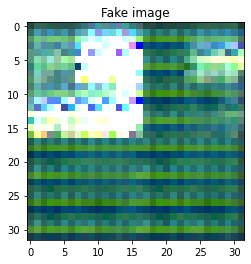

In [23]:
loss_generator,loss_discriminator = g_CNN_norm.train(X_normalized,1000,20)

In [24]:
plt.figure(figsize=(5,5))
plt.plot(loss_generator)
plt.plot(loss_discriminator)
plt.title('Loss function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['generator loss','discriminator loss'])
#plt.ylim([0,])
plt.show()

### Evaluation plots

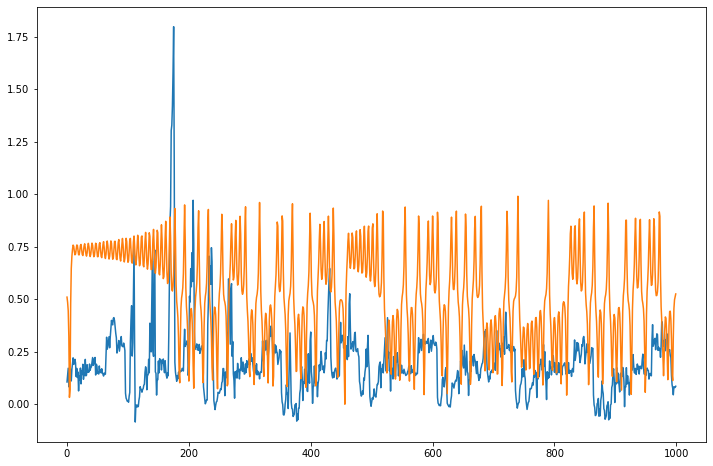

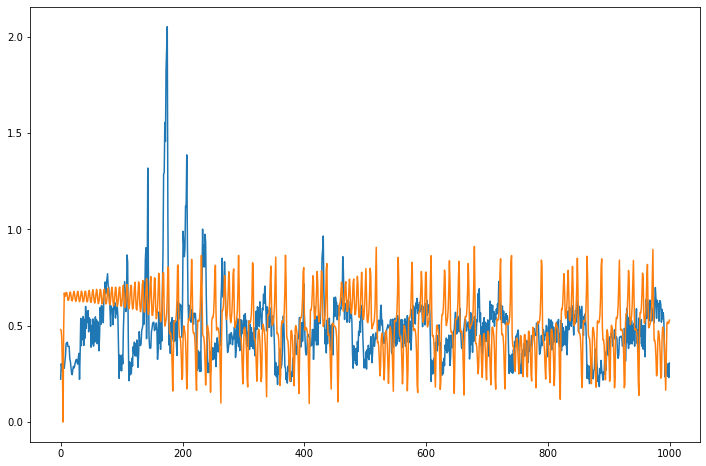

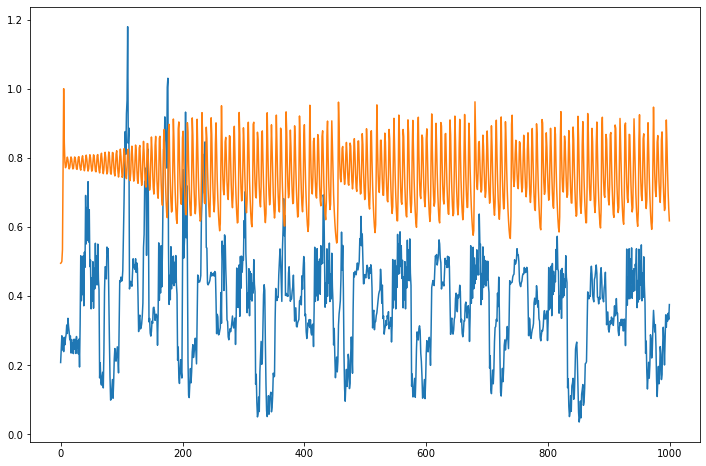

In [28]:
real_series_length = 1000
x = X_normalized[0,...].reshape(X.shape[1]*X.shape[2],X.shape[3])[:real_series_length]
#max_matrix = np.repeat(np.max(abs(x_train),axis=0).reshape(1,3),1000,axis=0)
#x_train = np.divide(x_train,max_matrix)

generated_data = g_CNN_norm.generate(1)
generated_data = generated_data[0,...].reshape(generated_data.shape[1]*generated_data.shape[2],generated_data.shape[3])[:real_series_length]

plt.figure(figsize=(12,8))
plt.plot(generated_data[:,0])
plt.plot(x[:,0])
#plt.xlim([0,200])
plt.show()

plt.figure(figsize=(12,8))
plt.plot(generated_data[:,1])
plt.plot(x[:,1])
#plt.xlim([0,300])
plt.show()

plt.figure(figsize=(12,8))
plt.plot(generated_data[:,2])
plt.plot(x[:,2])
plt.show()

In [37]:
generated_data = g_CNN_norm.generate(1)
generated_data = generated_data[0,...].reshape(generated_data.shape[1]*generated_data.shape[2],generated_data.shape[3])[:real_series_length]

plt.figure(figsize=(12,8))
plt.plot(generated_data[:,0])
plt.plot(generated_data[:,1])
plt.plot(generated_data[:,2])
plt.xlim([0,500])
plt.show()

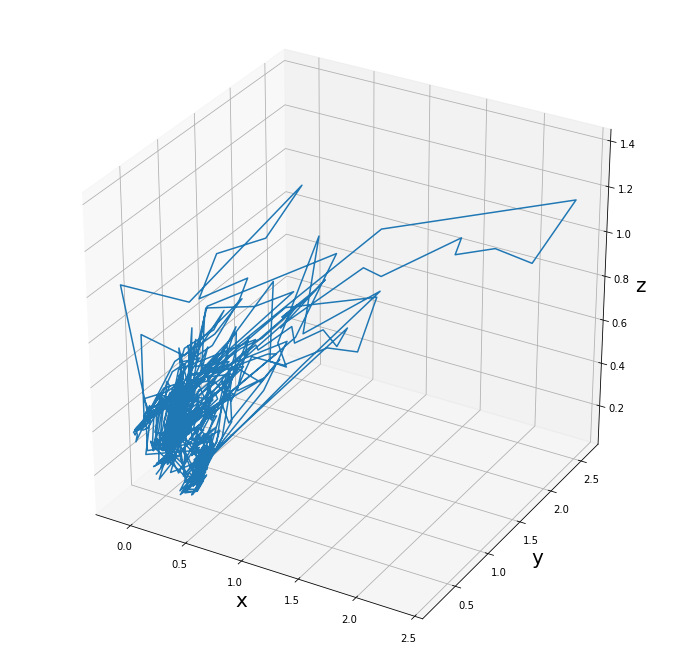

In [27]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')
ax.plot(generated_data[:,0], generated_data[:,1], generated_data[:,2])
ax.set_xlabel('x', size=20);ax.set_ylabel('y', size=20);ax.set_zlabel('z', size=20)
plt.show()

### Lyapunov exponent

In [38]:
for i in range(3):
    
    lyap_generated = nolds.lyap_e(generated_data[:,i])
    print('Coordinate %d' %i)
    print('Lyapunov exponentes - Eckmann algorithm: ', lyap_generated)
    print('Maximum Lyapunov exponent - Rosenstein algorithm: ',nolds.lyap_r(generated_data[:,i]))

Coordinate 0
Lyapunov exponentes - Eckmann algorithm:  [ 0.15278524  0.04994208 -0.05448498 -0.24126697]
Maximum Lyapunov exponent - Rosenstein algorithm:  0.0037200746612568343


/opt/conda/envs/fastai/lib/python3.7/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 250
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


Coordinate 1
Lyapunov exponentes - Eckmann algorithm:  [ 0.1327161   0.04322616 -0.06401673 -0.21921647]
Maximum Lyapunov exponent - Rosenstein algorithm:  0.014264145532068638


/opt/conda/envs/fastai/lib/python3.7/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 250
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


Coordinate 2
Lyapunov exponentes - Eckmann algorithm:  [ 0.12274418  0.03435568 -0.04876631 -0.22697222]
Maximum Lyapunov exponent - Rosenstein algorithm:  0.014264145532068638


/opt/conda/envs/fastai/lib/python3.7/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 250
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


## Loaded model

We load the model that gave the best results for evaluation purposes.

In [7]:
loadded_gan = gan_CNN()
loadded_gan.load_weights('models/gen3channels.h5','models/discr3channels.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
(?, 300)


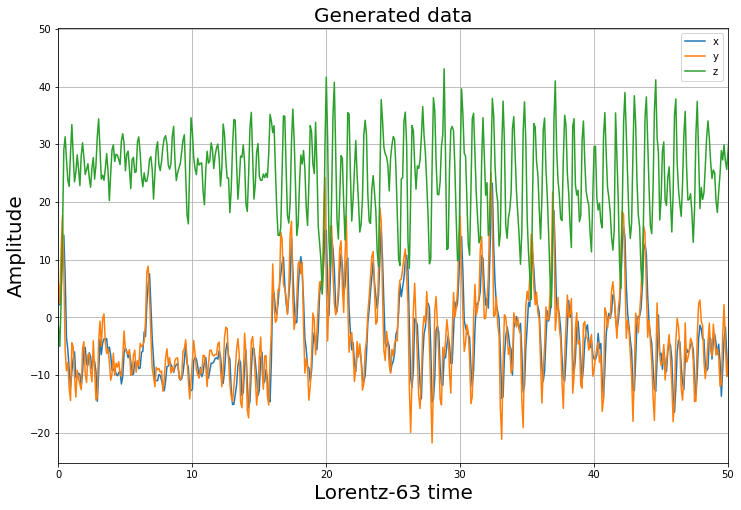

In [13]:
real_series_length = 1000
generated_data = loadded_gan.generate(1)
generated_data = generated_data[0,...].reshape(generated_data.shape[1]*generated_data.shape[2],generated_data.shape[3])[:real_series_length]

plt.figure(figsize=(12,8))
plt.plot(time,generated_data[:,0])
plt.plot(time,generated_data[:,1])
plt.plot(time,generated_data[:,2])
plt.legend(['x','y','z'])
plt.grid()
plt.xlabel('Lorentz-63 time', size=20)
plt.ylabel('Amplitude', size=20)
plt.title('Generated data',size=20)
plt.xlim([0,50])
plt.savefig('images/3coords_plot_zoom.png')

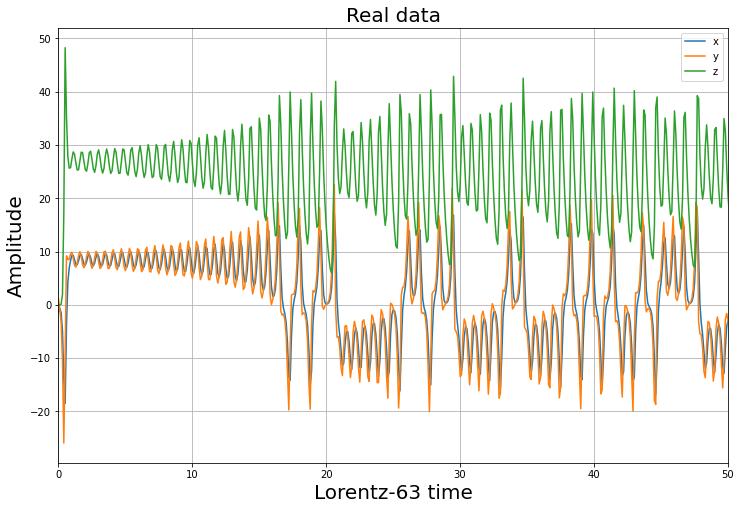

In [14]:
real_series_length = 1000
x = X[0,...].reshape(X.shape[1]*X.shape[2],X.shape[3])[:real_series_length]

plt.figure(figsize=(12,8))
plt.plot(time,x[:,0])
plt.plot(time,x[:,1])
plt.plot(time,x[:,2])
plt.legend(['x','y','z'])
plt.grid()
plt.xlabel('Lorentz-63 time', size=20)
plt.ylabel('Amplitude', size=20)
plt.title('Real data', size=20)
plt.xlim([0,50])
plt.savefig('images/3coords_plot_zoom_real.png')

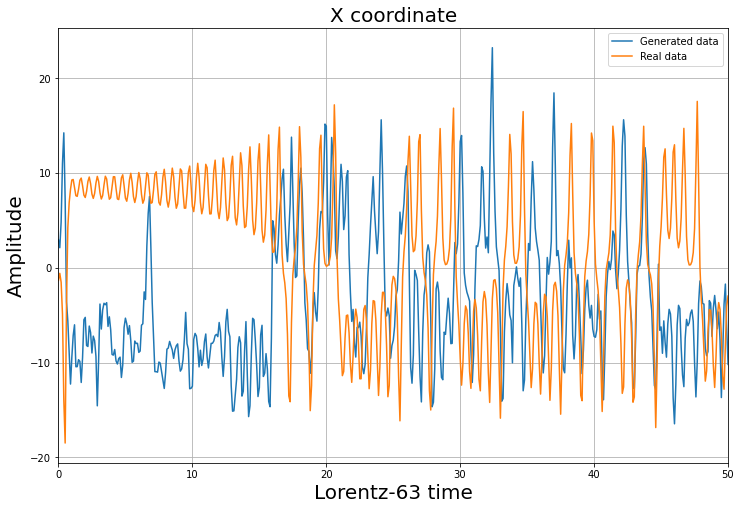

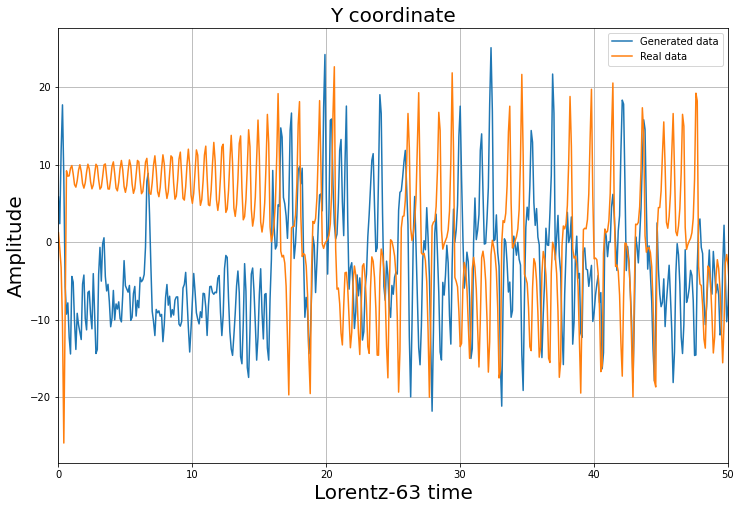

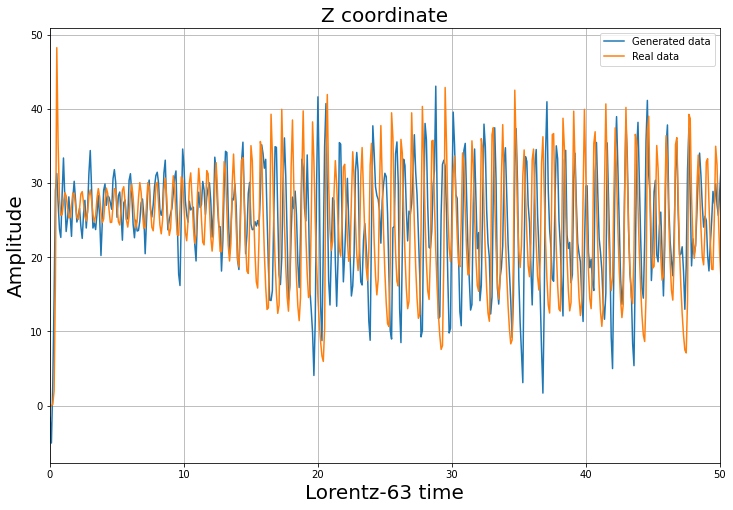

In [15]:
real_series_length = 1000
x = X[0,...].reshape(X.shape[1]*X.shape[2],X.shape[3])[:real_series_length]
#max_matrix = np.repeat(np.max(abs(x_train),axis=0).reshape(1,3),1000,axis=0)
#x_train = np.divide(x_train,max_matrix)

plt.figure(figsize=(12,8))
plt.plot(time,generated_data[:,0])
plt.plot(time,x[:,0])
plt.xlim([0,50])
plt.grid()
plt.xlabel('Lorentz-63 time', size=20)
plt.ylabel('Amplitude', size=20)
plt.title('X coordinate', size=20)
plt.legend(['Generated data','Real data'])
plt.savefig('x.png')

plt.figure(figsize=(12,8))
plt.plot(time,generated_data[:,1])
plt.plot(time,x[:,1])
plt.xlim([0,50])
plt.grid()
plt.xlabel('Lorentz-63 time', size=20)
plt.ylabel('Amplitude', size=20)
plt.title('Y coordinate', size=20)
plt.legend(['Generated data','Real data'])
plt.savefig('y.png')

plt.figure(figsize=(12,8))
plt.plot(time,generated_data[:,2])
plt.plot(time,x[:,2])
plt.xlim([0,50])
plt.grid()
plt.xlabel('Lorentz-63 time', size=20)
plt.ylabel('Amplitude', size=20)
plt.title('Z coordinate', size=20)
plt.legend(['Generated data','Real data'])
plt.savefig('z.png')

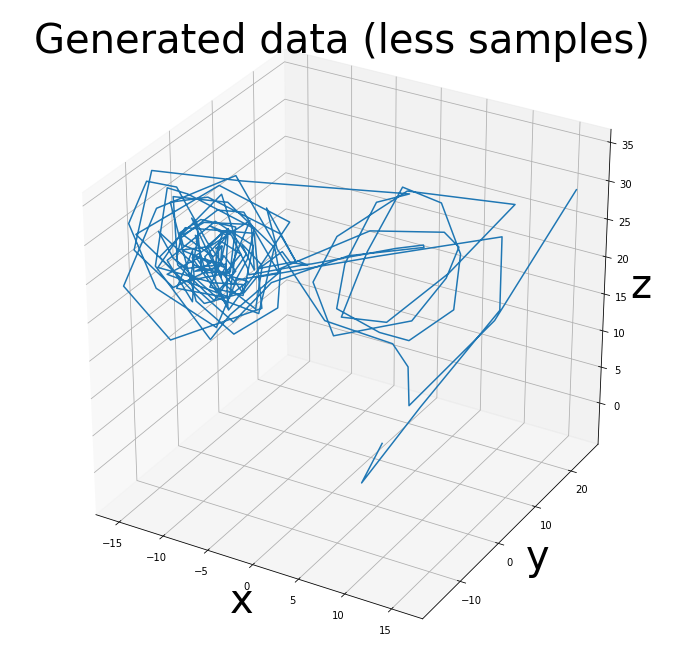

In [129]:
Nmax = 200
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')
ax.plot(generated_data[:Nmax,0], generated_data[:Nmax,1], generated_data[:Nmax,2])
ax.set_xlabel('x', size=40);ax.set_ylabel('y', size=40);ax.set_zlabel('z', size=40)
ax.set_title("Generated data (less samples)", size=40)
plt.savefig('butterfly_zoomed.png')

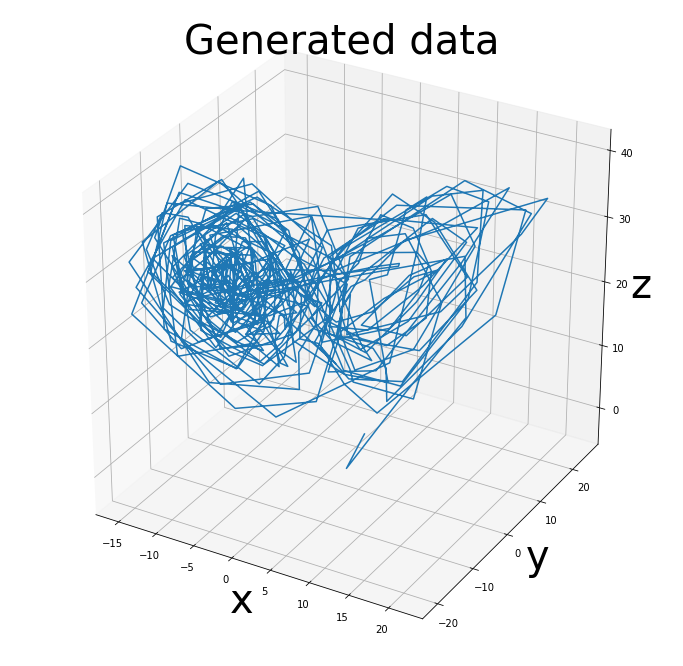

In [128]:
Nmax = 500
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')
ax.plot(generated_data[:Nmax,0], generated_data[:Nmax,1], generated_data[:Nmax,2])
ax.set_xlabel('x', size=40);ax.set_ylabel('y', size=40);ax.set_zlabel('z', size=40)
ax.set_title('Generated data', size=40)
plt.savefig('butterfly.png')

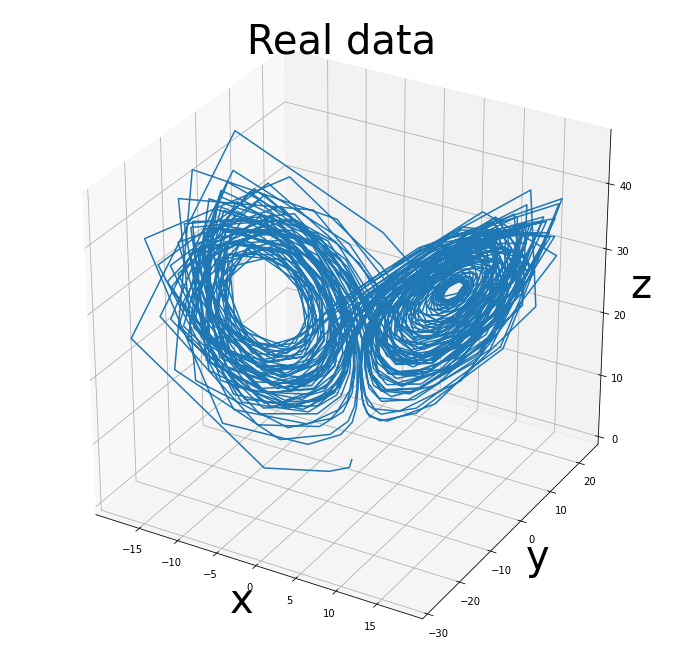

In [123]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')
ax.plot(x[:,0], x[:,1], x[:,2])
ax.set_xlabel('x', size=40);ax.set_ylabel('y', size=40);ax.set_zlabel('z', size=40)
ax.set_title('Real data', size=40)
plt.savefig('butterfly_real.png')

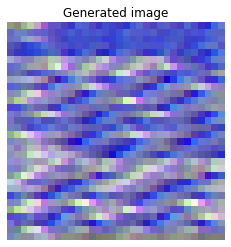

In [102]:
generated_data = loadded_gan.generate(1)

max_vec = np.max(np.max(abs(generated_data),axis=1),axis=1)

max_matrix = np.expand_dims(np.expand_dims(max_vec,axis=1),axis=2)
max_matrix = np.repeat(np.repeat(max_matrix,n_rows,axis=1),n_cols,axis=2)

generated_data = np.add(np.divide(generated_data,2*max_matrix),0.5)

plt.imshow(generated_data[0,:])
plt.axis('off')
plt.title('Generated image')
plt.savefig('genImg.png')

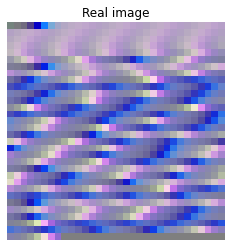

In [103]:
max_vec = np.max(np.max(abs(X),axis=1),axis=1)

max_matrix = np.expand_dims(np.expand_dims(max_vec,axis=1),axis=2)
max_matrix = np.repeat(np.repeat(max_matrix,n_rows,axis=1),n_cols,axis=2)

X_normalized = np.add(np.divide(X,2*max_matrix),0.5)
plt.imshow(X_normalized[0,...])
plt.axis('off')
plt.title('Real image')
plt.savefig('realImg.png')

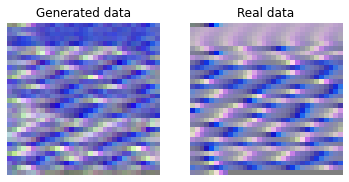

In [114]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
plt.imshow(generated_data[0,...])
plt.axis('off')
ax2 = fig.add_subplot(122)
plt.imshow(X_normalized[0,...])
plt.axis('off')
ax1.title.set_text('Generated data')
ax2.title.set_text('Real data')
plt.savefig('images.png')

### Lyapunov exponent for generated data

In [16]:
dt=0.1
for i in range(3):
    
    lyap_generated = nolds.lyap_e(generated_data[:,i], tau=dt)
    print('Coordinate %d' %i)
    print('Lyapunov exponentes - Eckmann algorithm: ', lyap_generated)
    print('Maximum Lyapunov exponent - Rosenstein algorithm: ',nolds.lyap_r(generated_data[:,i], tau=dt))

Coordinate 0
Lyapunov exponentes - Eckmann algorithm:  [ 1.3506098   0.31345364 -0.6386072  -2.539553  ]
Maximum Lyapunov exponent - Rosenstein algorithm:  0.46432290937667514


/opt/conda/envs/fastai/lib/python3.7/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 250
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


Coordinate 1
Lyapunov exponentes - Eckmann algorithm:  [ 1.2678502   0.24137372 -0.6012642  -2.3512857 ]
Maximum Lyapunov exponent - Rosenstein algorithm:  0.38945600442718914


/opt/conda/envs/fastai/lib/python3.7/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 250
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


Coordinate 2
Lyapunov exponentes - Eckmann algorithm:  [ 0.85314447  0.20065337 -0.77580255 -2.466179  ]
Maximum Lyapunov exponent - Rosenstein algorithm:  0.013139739959325594


/opt/conda/envs/fastai/lib/python3.7/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 250
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/conda/envs/fastai/lib/python3.7/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 52
  warnings.warn(msg.format(lag), RuntimeWarning)


### Lyapunov exponent for real data

In [17]:
dt=0.1
for i in range(3):
    
    lyap_generated = nolds.lyap_e(x[:,i], tau=dt)
    print('Coordinate %d' %i)
    print('Lyapunov exponentes - Eckmann algorithm: ', lyap_generated)
    print('Maximum Lyapunov exponent - Rosenstein algorithm: ',nolds.lyap_r(x[:,i], tau=dt))

Coordinate 0
Lyapunov exponentes - Eckmann algorithm:  [ 2.8854666   1.1020529  -0.78506285 -4.7122083 ]
Maximum Lyapunov exponent - Rosenstein algorithm:  0.8006133298228554


/opt/conda/envs/fastai/lib/python3.7/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 250
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


Coordinate 1
Lyapunov exponentes - Eckmann algorithm:  [ 3.0546863  1.2719357 -1.0060598 -5.67737  ]
Maximum Lyapunov exponent - Rosenstein algorithm:  0.7431933539254327


/opt/conda/envs/fastai/lib/python3.7/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 250
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


Coordinate 2
Lyapunov exponentes - Eckmann algorithm:  [ 3.6362734   0.40032914 -1.3336816  -5.4358807 ]
Maximum Lyapunov exponent - Rosenstein algorithm:  0.0017741431798755033


/opt/conda/envs/fastai/lib/python3.7/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 250
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/opt/conda/envs/fastai/lib/python3.7/site-packages/nolds/measures.py:268: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 52
  warnings.warn(msg.format(lag), RuntimeWarning)
